# 101 Course of transfer learning and Fine tune 2021-01-01

## [How-to] 1. k-fold for cross validation

#### Create a simple k-fold for train classification model.

* In this short course you learned:

* data pipline

* transfer learning

* fine tune

* callbacks


todo: move to note.py


In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [2]:
print(tf.__version__)
print(cv2.__version__)

2.3.1
4.3.0


In [3]:
from pytictoc import TicToc

t_timer = TicToc() #create instance of class

t_timer.tic() #Start timer

### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# CSVNAME = ""


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# data-train # # current best dataset.1424-79.
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'
CSVNAME = "K1345K10L195"

# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'
# CSVNAME = ""


# # data-train-HPL-1123
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'
# CSVNAME = ""


df = pd.read_csv(ann)
df[1120:]

images  x1   y1  x2   y2
1120  image_6195.jpg  52  127  75  370
1121  image_6196.jpg  62  138  29  383
1122  image_6197.jpg  54  135  78  380
1123  image_6198.jpg  60  125  29  384
1124  image_6199.jpg  51  147  70  353
...              ...  ..  ...  ..  ...
1340  image_6419.jpg  60  135  70  381
1341  image_6421.jpg  53  157  76  376
1342  image_6422.jpg  49  154  33  375
1343  image_6423.jpg  64  149  76  381
1344  image_6424.jpg  55  147  36  385

[225 rows x 5 columns]

In [8]:
len(df)

1345

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

images  x1   y1  x2   y2
0  image_0944.png  69  135  77  369
1  image_0263.png  64  133  88  367
2  image_6187.jpg  57  136  72  383
3  image_6393.jpg  53  145  76  384
4  image_0093.png  69  150  73  377
5  image_6036.png  61  160  34  384
6  image_0331.png  50  125  76  365
7  image_6010.png  56  174  37  381
8  image_0431.png  55  103  71  384
9  image_0848.png  73  133  80  381

See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1345

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0944.png' 69 135 77 369
take sample: b'image_0263.png' 64 133 88 367
take sample: b'image_6187.jpg' 57 136 72 383
take sample: b'image_6393.jpg' 53 145 76 384
take sample: b'image_0093.png' 69 150 73 377


In [15]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0093.png


In [16]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [17]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [18]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0944.png' 69 135
b'image_0263.png' 64 133
b'image_6187.jpg' 57 136
b'image_6393.jpg' 53 145


In [19]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0944.png' 69 135 77 369
b'image_0944.png' 69 135 77 369
b'image_0944.png' 69 135 77 369
b'image_0944.png' 69 135 77 369
===== Create iterator once and pull out to above cell. =====
b'image_0944.png' 69 135 77 369
b'image_0263.png' 64 133 88 367
b'image_6187.jpg' 57 136 72 383
b'image_6393.jpg' 53 145 76 384


#### Process path to image tensor in DS

In [20]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [21]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [22]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

for img, [x, y] in train_ds_map_toe.take(1):
    print(f'take sample: {x} {y}')
    
print('f', f.dtype)
print('x', x.dtype)

take sample: 69 55
f <dtype: 'string'>
x <dtype: 'int64'>


In [23]:
x

<tf.Tensor: shape=(), dtype=int64, numpy=69>

In [24]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

[2021-02-23] New k-split ds

In [25]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(f'whole samples = {len(train_ds_map_toe)}')
# print(f'val_size = {val_size}')

# print('ds_train = ', tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print('ds_valid = ', tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [26]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

In [27]:
# ## testing cell
# kf = []
# for k in range(5):
#     kf.append(train_ds_map_heel.shard(num_shards=5, index=k))
#     print("k =", k,"num=", tf.data.experimental.cardinality(kf[k]).numpy())

In [28]:
# kf

In [29]:

# for img, [x,y] in kf[1].take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# print('y', y.dtype)

In [30]:
# ## testing cell

# range_k_0 = train_ds_map_heel.window(5)

# print(len(range_k_0))
# print(tf.data.experimental.cardinality(range_k_0).numpy())

In [31]:
# ## testing cell

# def get_train_valid_k_split():
#     x = tf.data.Dataset.range(1000)
#     val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    
#     for k in range(5):
#         train_num = x.take(val_size + k*val_size)
#         valid_num = x.skip(k*val_size)
        
#         print("k=", k)
#         print(tf.data.experimental.cardinality(train_num).numpy())
#         print(tf.data.experimental.cardinality(valid_num).numpy())
    
    
# get_train_valid_k_split()

In [32]:
## testing cell

# 
# tf.slice
# tf.data.experimental.choose_from_datasets


# x = list_ds
# val_size = int(tf.data.experimental.cardinality(list_ds).numpy() * 0.2)
x = tf.data.Dataset.range(10)

def check_KFold_ds(x, K=5):
    
    val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
    print("val_size=", val_size)
    
    for k in range(K):
#         k_train = x.take(val_size + k*val_size)
#         k_valid = x.skip(k*val_size)
#         k_train = tf.slice(x, k*val_size, val_size) #only for pure tensors not 
#         k_valid = x.skip(k*val_size)

        # may skip twicce to performe kflod
        t_take = x.take(k*val_size)
        t_skip = x.skip(k*val_size+val_size)
        k_train = t_take.concatenate(t_skip)
        
        v_skip = x.skip(k*val_size)
        k_valid = v_skip.take(val_size)

        print("k =", k,"k*val_size+val_size", k*val_size+val_size, "k_train num=", tf.data.experimental.cardinality(k_train).numpy())


        # x = tf.data.Dataset.range(10)
#         for n in k_train:
#             print(n.numpy())
#         for n in k_valid:
#             print(n.numpy())
        
        # list_ds
#         for img, x1, y1, x2, y2 in k_train:
#             print(x1, y1)

        # train_ds_map_toe
#         for img, (x, y) in k_train:
#             print(x.numpy(), y.numpy())

    
    
    
check_KFold_ds(x)
# check_KFold_ds(list_ds)    
# check_KFold_ds(train_ds_map_toe)

val_size= 2
k = 0 k*val_size+val_size 2 k_train num= 8
k = 1 k*val_size+val_size 4 k_train num= 8
k = 2 k*val_size+val_size 6 k_train num= 8
k = 3 k*val_size+val_size 8 k_train num= 8
k = 4 k*val_size+val_size 10 k_train num= 8


In [33]:
# x = tf.data.Dataset.range(10)
# val_size = int(tf.data.experimental.cardinality(x).numpy() * 0.2)
# print("val_size=", val_size)

def get_KFold_ds(x, K=0):
        
    k = K
    # may skip twicce to perform kflod
    # train ds
    t_take = x.take(k*val_size)
    t_skip = x.skip(k*val_size+val_size)
    k_train = t_take.concatenate(t_skip)
    # val ds
    v_skip = x.skip(k*val_size)
    k_valid = v_skip.take(val_size)

    return k_train, k_valid

In [34]:
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)
t, v = get_KFold_ds(train_ds_map_toe, 1)

print(tf.data.experimental.cardinality(t).numpy())
print(tf.data.experimental.cardinality(v).numpy())

# for n in v:
#     print(n.numpy())

1211
134


In [35]:
train_ds_map_toe

<ParallelMapDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

In [36]:
v

<TakeDataset shapes: ((120, 120, 3), (2,)), types: (tf.uint8, tf.int64)>

# Albumentation pipeline

In [37]:

# # for NO keypoint augment
# transforms = A.Compose([
# #             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
# #             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
    
#             # try other augm, seems to strong...
#             A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
#             A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True),
#             A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.8, 1.5), per_channel=False, elementwise=False),
#             A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.25),

# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label




# # Testing keypoints augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=1),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.HorizontalFlip(p=0.5),
#             ]
#             , 
#             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )





# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1.0),
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.9, 0.99), ratio=(1.0, 1.0), interpolation=0, p=0.7),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine(scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
    #2021-02-26
#             A.IAAPerspective(scale=(0.05, 0.1), keep_size=True, always_apply=False, p=0.5),#fallout image make train stop. NOT support keypoints!!!!!
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 








###  for AToe ###
# some pp will outside of image bcs p2 is close to 400.



# Testing keypoints augment
transforms_AToe = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=65, quality_upper=100, p=0.5),#A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA(alpha=0.1, always_apply=False, p=1),#A.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
            A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE(clip_limit=(1, 8), tile_grid_size=(8, 8), always_apply=False, p=0.5), #A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5)
    
            A.HorizontalFlip(p=0.5),
#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
            A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.7),
#             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


# Testing keypoints augment
# @tf.function
def aug_fn_AToe(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms_AToe(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data_AToe(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn_AToe, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 




def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [38]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


def configure_for_performance_cache_train_AToe(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data_AToe, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds





# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [39]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [40]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
# valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# # Heel ds_pre
# train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
# valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

#### Check ds_prefetch samples

In [41]:
# # create it_ds once
# it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

In [42]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_toe_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')


In [43]:
# # create it_ds once
# it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

In [44]:
# %%time

# # for albu keypoint

# # for original return aug_img, , aug_xy 


# image_batch, label_batch = next(it_train_ds_pre_heel_s)

# fig = plt.figure(figsize=(8, 8))
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')

In [45]:
# # create it_ds once
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

In [46]:
# %%time

# # for albu keypoint

# # for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)

# plt.figure(figsize=(8, 8))
# # for images, labels in valid_ds_pre_toe_s.take(1):
# print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
# for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")

#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

#     print(f'Check lables: {label_batch[i]}')
        

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [47]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [48]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [49]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [50]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [51]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [52]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [53]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [54]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [55]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [56]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [57]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [58]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [59]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [60]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [61]:
ed_metric_2d_mean(y_true, y_pred).numpy()

2.1213202

In [62]:
ed_metric_2d_mean(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=2.1213202>

# EFNE Training

maybe mae better than ed loss?

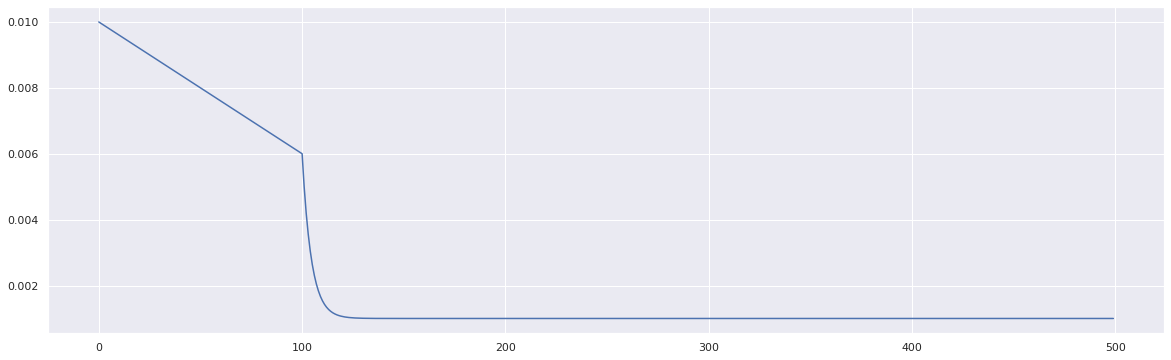

In [63]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.8

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [64]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.01


In [65]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 0.01

1	 0.00996

2	 0.00992

3	 0.00988

4	 0.00984

5	 0.0098

6	 0.00976

7	 0.00972

8	 0.00968

9	 0.009640000000000001

10	 0.009600000000000001

11	 0.00956

12	 0.00952

13	 0.00948

14	 0.00944

15	 0.0094

16	 0.00936

17	 0.00932

18	 0.00928

19	 0.00924

20	 0.0092

21	 0.00916

22	 0.00912

23	 0.00908

24	 0.00904

25	 0.009000000000000001

26	 0.00896

27	 0.00892

28	 0.00888

29	 0.00884

30	 0.0088

31	 0.00876

32	 0.00872

33	 0.00868

34	 0.00864

35	 0.0086

36	 0.00856

37	 0.00852

38	 0.00848

39	 0.00844

40	 0.0084

41	 0.00836

42	 0.008320000000000001

43	 0.00828

44	 0.00824

45	 0.0082

46	 0.00816

47	 0.00812

48	 0.00808

49	 0.00804

50	 0.008

51	 0.00796

52	 0.00792

53	 0.00788

54	 0.00784

55	 0.0078

56	 0.0077599999999999995

57	 0.007719999999999999

58	 0.00768

59	 0.00764

60	 0.0076

61	 0.00756

62	 0.007520000000000001

63	 0.0074800000000000005

64	 0.00744

65	 0.0074

66	 0.00736

67	 0.00732

68	 0.00728

69	 0.00724

70	 0.007

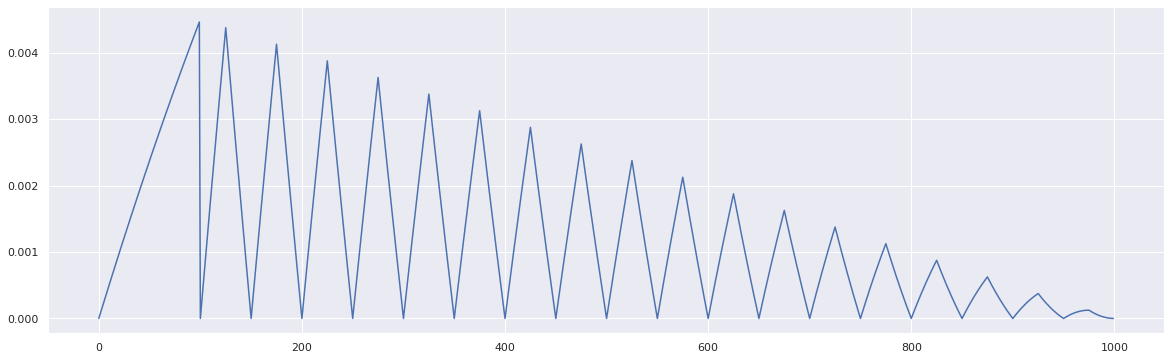

In [66]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))
    x = np.abs(iterations/step_size - 2*cycle + 1)
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#     print(decay)
    return lr * (base_part-decay) * lr_decay # supressed the lr!


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [67]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [68]:
# 2.4999999999999966e-08 ~ 0.004459954505 1e-2~1e-6 

In [69]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUp(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-2 # currently best for foot pp
#     base_lr = 1e-8# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-2
#     first_decay_steps = 100


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUp(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

In [70]:
# %%time
# """
# cosine_decay_restarts是cosine_decay的cycle版本。
# first_decay_steps是指第一次完全下降的step數，
# t_mul是指每一次循環的步數都將乘以t_mul倍，
# m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
# alpha
# """

# from matplotlib.ticker import FormatStrFormatter



# ep_num = 1000



# def CosineDecayCLRWarmUpLSW(epoch):
    
#     #step_size = 25 # currently best for foot pp
#     max_lr = 1e-3 # currently best for foot pp
#     base_lr = 1e-6# 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 20
#     lr_sus_ep  = 0
#     lr_decay   = 0.8


#     initial_learning_rate = 1e-3
#     first_decay_steps = 50


#     lr_decayed_fn = (
#       tf.keras.experimental.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps,
#           t_mul=1.0,
#           m_mul=0.8,
#           alpha = 0.000001,
#           name="CCosineDecayRestarts"))
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
#     else:
#         lr = lr_decayed_fn(epoch-lr_ramp_ep)
#     return lr



# rng = [i for i in range(ep_num)]
# y = [CosineDecayCLRWarmUpLSW(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# # plt.ylim(.0000000000000001, .01)# for too large loss
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
# plt.plot(rng, y)

CPU times: user 576 ms, sys: 57.3 ms, total: 633 ms
Wall time: 528 ms


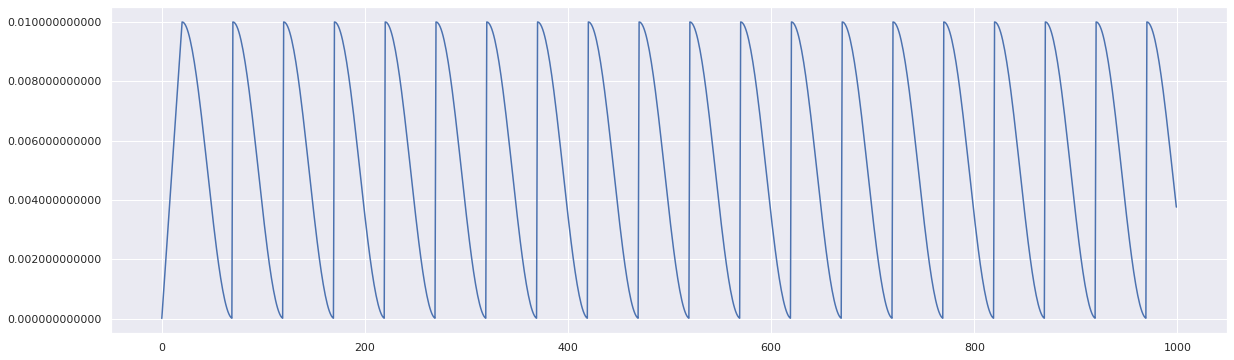

In [71]:
%%time
"""
cosine_decay_restarts是cosine_decay的cycle版本。
first_decay_steps是指第一次完全下降的step數，
t_mul是指每一次循環的步數都將乘以t_mul倍，
m_mul指每一次循環重新開始時的初始lr是上一次循環初始值的m_mul倍。
alpha
"""

from matplotlib.ticker import FormatStrFormatter



ep_num = 1000



def CosineDecayCLRWarmUpLSW_2(epoch):
    
    #step_size = 25 # currently best for foot pp
    max_lr = 1e-2 # currently best for foot pp
    base_lr = 1e-6# 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 20
    lr_sus_ep  = 0
    #lr_decay   = 0.8


    initial_learning_rate = 1e-2
    first_decay_steps = 50


    lr_decayed_fn = (
      tf.keras.experimental.CosineDecayRestarts(
          initial_learning_rate,
          first_decay_steps,
          t_mul=1,
          m_mul=1,
          alpha = 0.000001,
          name="CCosineDecayRestarts"))
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr    
    else:
        lr = lr_decayed_fn(epoch-lr_ramp_ep)
    return lr



rng = [i for i in range(ep_num)]
y = [CosineDecayCLRWarmUpLSW_2(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
# plt.ylim(.0000000000000001, .01)# for too large loss
ax.yaxis.set_major_formatter(FormatStrFormatter('%.12f'))# for too small loss
plt.plot(rng, y)

In [72]:
print('{} ~ {}'.format(min(y), max(y)))

1e-06 ~ 0.009999999776482582


In [73]:
# 1.8774175103430935e-08 ~ 0.0010000000474974513 1e-3 1e-6

In [74]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [75]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [76]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [77]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [78]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [79]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [80]:
model_name = 'EfficientNetB0'

In [81]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th, K):
    return './' + log_dir_name + '/' + th + '_K' + K + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
# # th = 'heel'

# # print(get_best_model_name(th,K))

# best_model_name = get_best_model_name(th, K)


# best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
#                              save_best_only = True, 
#                              save_weights_only = False,
#                              monitor = monitor, 
#                              mode = 'auto', verbose = 1)
# print('best_model_name:', best_model_name)

In [82]:
logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
# #     lr_reduceonplateau,
#     tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
#     PrintLRtoe()
# ]

In [84]:
# Transfer learning from pre-trained weights
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model

In [85]:
# """Supervised pre-training 減少每次fold都要重新train的時間
# 只先改toe"""

# # Transfer learning from pre-trained weights
# def load_pretrained_efn_model():
#     pre_model_toe_name = "20210224-200728/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5"
#     model = tf.keras.models.load_model(pre_model_toe_name,compile=False)

#     # Freeze the pretrained weights
#     model.trainable = False
# #     print("base_model.trainable : ", base_model.trainable)

# #     # Rebuild top
# #     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# #     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
# #     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
# #     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

# #     # Compile new model
# #     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 4 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             print('layer trainable +1', layer.name)
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model

In [86]:
def unfreeze_model(model):
#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166  block3a_expand_conv 195
#
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == 'block3a_expand_conv': 
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [87]:
# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2
# with strategy.scope():
#     model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

In [88]:
# len(model_toe.layers)

In [89]:
# tt = 0
# nt = 0
# for layer in model_toe.layers:
#     if layer.trainable:
#         tt +=1
#         print(f'{layer.name}')
#     else:
#         nt +=1
# print(f'tt: {tt}, nt:{nt}')

In [90]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print('\n*********************************** Start fine tune ***********************************')
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')
    print('*********************************** Start fine tune ***********************************')

In [91]:
# count_model_trainOrNot_layers(model_toe)

In [92]:
# model_toe.summary()

In [93]:
# %%time

# # fit the model on all data
# history_toe = model_toe.fit(train_ds_pre_toe_s, 
#                       verbose=1, 
#                       epochs=ep_num_transf, 
#                       validation_data=valid_ds_pre_toe_s, 
#                       callbacks=callbacks)#, validation_split=0.1)

# K-Fold Training

2021-02-23 v1

### Toe K-model

In [94]:
%%time

# big K = 5 (fold 0 ~ 4) 
KFlodNum = 10



history_toe = []
history_toe_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("\n \n K = ", k, "\n")
    # Toe split
    train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
    # Toe ds_pre
    train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
    valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
#     # heel split
#     train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
#     # Heel ds_pre
#     train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
#     valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    th = 'toe'
    # th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_toe_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_toe_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRtoe()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_toe = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
#         model_toe = load_pretrained_efn_model() # from 20210224-200728 ed5.3
#         count_model_trainOrNot_layers(model_toe)
        
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_tl)#, validation_split=0.1)
    history_toe.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_toe)
    count_model_trainOrNot_layers(model_toe)
    # fit the model on all data
    hist = model_toe.fit(train_ds_pre_toe_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_toe_s, 
                          callbacks=callbacks_toe_fn)#, validation_split=0.1)
    history_toe_finetune.append(hist)



 
 K =  0 

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens


[20210302-2308-10] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
19/19 [==============================] - ETA: 0s - loss: 14.7215
Epoch 00018: val_loss did not improve from 10.64180
19/19 [==============================] - 0s 21ms/step - loss: 14.7215 - val_loss: 10.9239

[20210302-2308-14] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
16/19 [========================>.....] - ETA: 0s - loss: 14.5029
Epoch 00019: val_loss improved from 10.64180 to 10.63986, saving model to ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 43ms/step - loss: 14.4577 - val_loss: 10.6399

[20210302-2308-18] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 14.6225
Epoch 00020: val_loss did not improve from 10.63986
19/19 [==============================] - 0s 21ms/step - loss: 14.6225 - val_loss: 10.8125

[20210302-2308-23] Learning rate for 

16/19 [========================>.....] - ETA: 0s - loss: 13.8056
Epoch 00044: val_loss improved from 10.37108 to 10.35808, saving model to ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 13.7852 - val_loss: 10.3581

[20210302-2310-08] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - loss: 13.8960
Epoch 00045: val_loss did not improve from 10.35808
19/19 [==============================] - 1s 30ms/step - loss: 13.9632 - val_loss: 10.5708

[20210302-2310-12] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
18/19 [===========================>..] - ETA: 0s - loss: 14.0113
Epoch 00046: val_loss improved from 10.35808 to 10.34185, saving model to ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 13.9647 - val_loss: 10.3418

[20210302-2310-17] Learning rate 


[20210302-2312-01] Learning rate for epoch 71 is 0.007199999876320362
Epoch 71/500
19/19 [==============================] - ETA: 0s - loss: 13.3810
Epoch 00071: val_loss did not improve from 10.29374
19/19 [==============================] - 0s 21ms/step - loss: 13.3810 - val_loss: 10.5633

[20210302-2312-05] Learning rate for epoch 72 is 0.007160000037401915
Epoch 72/500
16/19 [========================>.....] - ETA: 0s - loss: 13.2912
Epoch 00072: val_loss did not improve from 10.29374
19/19 [==============================] - 0s 22ms/step - loss: 13.3260 - val_loss: 10.4623

[20210302-2312-09] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
18/19 [===========================>..] - ETA: 0s - loss: 13.7246
Epoch 00073: val_loss did not improve from 10.29374
19/19 [==============================] - 0s 21ms/step - loss: 13.6975 - val_loss: 10.3721

[20210302-2312-14] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
16/19 [========================>.....] - ET


[20210302-2315-19] Learning rate for epoch 10 is 0.0004464008961804211
Epoch 10/1000
19/19 [==============================] - ETA: 0s - loss: 11.2011
Epoch 00010: val_loss improved from 8.42443 to 8.40224, saving model to ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 89ms/step - loss: 11.2011 - val_loss: 8.4022

[20210302-2315-25] Learning rate for epoch 11 is 0.0004954455071128905
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 11.1180
Epoch 00011: val_loss did not improve from 8.40224
19/19 [==============================] - 1s 61ms/step - loss: 11.1180 - val_loss: 8.7198

[20210302-2315-30] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.9792
Epoch 00012: val_loss did not improve from 8.40224
19/19 [==============================] - 1s 61ms/step - loss: 10.9792 - val_loss: 8.4480

[20210302-2315-35] Learning rate for e


[20210302-2317-40] Learning rate for epoch 37 is 0.0017355084419250488
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 8.5960
Epoch 00037: val_loss did not improve from 6.91997
19/19 [==============================] - 1s 62ms/step - loss: 8.5960 - val_loss: 8.1849

[20210302-2317-45] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
19/19 [==============================] - ETA: 0s - loss: 8.4177
Epoch 00038: val_loss did not improve from 6.91997
19/19 [==============================] - 1s 61ms/step - loss: 8.4177 - val_loss: 7.6004

[20210302-2317-50] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 8.6802
Epoch 00039: val_loss improved from 6.91997 to 6.78218, saving model to ./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 89ms/step - loss: 8.6802 - val_loss: 6.7822

[20210302-2317-56] Learning rate for epoch 4


[20210302-2320-01] Learning rate for epoch 64 is 0.002951723290607333
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 7.6823
Epoch 00064: val_loss did not improve from 5.65673
19/19 [==============================] - 1s 62ms/step - loss: 7.6823 - val_loss: 6.5925

[20210302-2320-06] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 7.8885
Epoch 00065: val_loss did not improve from 5.65673
19/19 [==============================] - 1s 61ms/step - loss: 7.8885 - val_loss: 5.9789

[20210302-2320-11] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 7.8182
Epoch 00066: val_loss did not improve from 5.65673
19/19 [==============================] - 1s 62ms/step - loss: 7.8182 - val_loss: 6.8133

[20210302-2320-16] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
19/19 [==============================] - ETA: 0s 


[20210302-2322-25] Learning rate for epoch 92 is 0.004135990981012583
Epoch 92/1000
19/19 [==============================] - ETA: 0s - loss: 7.3128
Epoch 00092: val_loss did not improve from 5.39196
19/19 [==============================] - 1s 61ms/step - loss: 7.3128 - val_loss: 6.5502

[20210302-2322-30] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
19/19 [==============================] - ETA: 0s - loss: 7.2664
Epoch 00093: val_loss did not improve from 5.39196
19/19 [==============================] - 1s 61ms/step - loss: 7.2664 - val_loss: 6.6744

[20210302-2322-35] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 7.3236
Epoch 00094: val_loss did not improve from 5.39196
19/19 [==============================] - 1s 61ms/step - loss: 7.3236 - val_loss: 6.6522

[20210302-2322-40] Learning rate for epoch 95 is 0.004258227068930864
Epoch 95/1000
19/19 [==============================] - ETA: 0s - 

19/19 [==============================] - ETA: 0s - loss: 6.7488
Epoch 00119: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 6.7488 - val_loss: 6.5314

[20210302-2324-48] Learning rate for epoch 120 is 0.003347905818372965
Epoch 120/1000
19/19 [==============================] - ETA: 0s - loss: 7.1412
Epoch 00120: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 7.1412 - val_loss: 6.3033

[20210302-2324-54] Learning rate for epoch 121 is 0.0035200880374759436
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 7.1012
Epoch 00121: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 7.1012 - val_loss: 7.0147

[20210302-2324-59] Learning rate for epoch 122 is 0.003691870253533125
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 7.0734
Epoch 00122: val_loss did not improve from 5.17673
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 6.2802
Epoch 00153: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 6.2802 - val_loss: 5.4330

[20210302-2327-42] Learning rate for epoch 154 is 0.0005085726734250784
Epoch 154/1000
19/19 [==============================] - ETA: 0s - loss: 6.2016
Epoch 00154: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 6.2016 - val_loss: 5.5175

[20210302-2327-47] Learning rate for epoch 155 is 0.0006771553307771683
Epoch 155/1000
19/19 [==============================] - ETA: 0s - loss: 5.9779
Epoch 00155: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.9779 - val_loss: 5.5050

[20210302-2327-52] Learning rate for epoch 156 is 0.0008453379850834608
Epoch 156/1000
19/19 [==============================] - ETA: 0s - loss: 6.1353
Epoch 00156: val_loss did not improve from 5.17673
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.7423
Epoch 00181: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 6.7423 - val_loss: 8.0794

[20210302-2330-05] Learning rate for epoch 182 is 0.0031122982036322355
Epoch 182/1000
19/19 [==============================] - ETA: 0s - loss: 6.4755
Epoch 00182: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 62ms/step - loss: 6.4755 - val_loss: 6.8560

[20210302-2330-10] Learning rate for epoch 183 is 0.002944914624094963
Epoch 183/1000
19/19 [==============================] - ETA: 0s - loss: 6.3002
Epoch 00183: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 6.3002 - val_loss: 5.7515

[20210302-2330-15] Learning rate for epoch 184 is 0.0027779308147728443
Epoch 184/1000
19/19 [==============================] - ETA: 0s - loss: 6.3863
Epoch 00184: val_loss did not improve from 5.17673
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.8051
Epoch 00209: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.8051 - val_loss: 5.4024

[20210302-2332-28] Learning rate for epoch 210 is 0.0014240531018003821
Epoch 210/1000
19/19 [==============================] - ETA: 0s - loss: 5.8715
Epoch 00210: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.8715 - val_loss: 5.6265

[20210302-2332-33] Learning rate for epoch 211 is 0.0015802369453012943
Epoch 211/1000
19/19 [==============================] - ETA: 0s - loss: 5.8774
Epoch 00211: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.8774 - val_loss: 5.8822

[20210302-2332-38] Learning rate for epoch 212 is 0.001736020902171731
Epoch 212/1000
19/19 [==============================] - ETA: 0s - loss: 5.9241
Epoch 00212: val_loss did not improve from 5.17673
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.8720
Epoch 00237: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.8720 - val_loss: 6.1034

[20210302-2334-51] Learning rate for epoch 238 is 0.0019839832093566656
Epoch 238/1000
19/19 [==============================] - ETA: 0s - loss: 5.9914
Epoch 00238: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 60ms/step - loss: 5.9914 - val_loss: 5.9023

[20210302-2334-56] Learning rate for epoch 239 is 0.0018289980944246054
Epoch 239/1000
19/19 [==============================] - ETA: 0s - loss: 5.9928
Epoch 00239: val_loss did not improve from 5.17673
19/19 [==============================] - 1s 61ms/step - loss: 5.9928 - val_loss: 5.8325

[20210302-2335-01] Learning rate for epoch 240 is 0.0016744130989536643
Epoch 240/1000
19/19 [==============================] - ETA: 0s - loss: 6.0157
Epoch 00240: val_loss did not improve from 5.17673
19/19 [=====

19/19 [==============================] - 6s 342ms/step - loss: 74.9250 - val_loss: 56.7129

[20210302-2337-12] Learning rate for epoch 2 is 0.009960000403225422
Epoch 2/500
17/19 [=========================>....] - ETA: 0s - loss: 36.2033
Epoch 00002: val_loss improved from 56.71291 to 21.28519, saving model to ./20210302-230617/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 3s 174ms/step - loss: 34.9296 - val_loss: 21.2852

[20210302-2337-20] Learning rate for epoch 3 is 0.009920000098645687
Epoch 3/500
19/19 [==============================] - ETA: 0s - loss: 20.9808
Epoch 00003: val_loss improved from 21.28519 to 13.24154, saving model to ./20210302-230617/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 6s 312ms/step - loss: 20.9808 - val_loss: 13.2415

[20210302-2337-29] Learning rate for epoch 4 is 0.009879999794065952
Epoch 4/500
17/19 [=========================>....] - ETA: 0s - loss: 18.8570
Epoc


[20210302-2339-05] Learning rate for epoch 25 is 0.009039999917149544
Epoch 25/500
16/19 [========================>.....] - ETA: 0s - loss: 14.6863
Epoch 00025: val_loss improved from 10.17061 to 10.13575, saving model to ./20210302-230617/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 14.5308 - val_loss: 10.1357

[20210302-2339-09] Learning rate for epoch 26 is 0.008999999612569809
Epoch 26/500
18/19 [===========================>..] - ETA: 0s - loss: 14.0347
Epoch 00026: val_loss did not improve from 10.13575
19/19 [==============================] - 0s 22ms/step - loss: 14.1163 - val_loss: 10.1979

[20210302-2339-13] Learning rate for epoch 27 is 0.008960000239312649
Epoch 27/500
18/19 [===========================>..] - ETA: 0s - loss: 14.3623
Epoch 00027: val_loss improved from 10.13575 to 9.98626, saving model to ./20210302-230617/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - 2s 99ms/step - loss: 7.7814 - val_loss: 6.0590

[20210302-2347-17] Learning rate for epoch 56 is 0.00259896251372993
Epoch 56/1000
19/19 [==============================] - ETA: 0s - loss: 7.8592
Epoch 00056: val_loss did not improve from 6.05901
19/19 [==============================] - 1s 62ms/step - loss: 7.8592 - val_loss: 6.8150

[20210302-2347-22] Learning rate for epoch 57 is 0.0026434077881276608
Epoch 57/1000
19/19 [==============================] - ETA: 0s - loss: 7.6768
Epoch 00057: val_loss did not improve from 6.05901
19/19 [==============================] - 1s 61ms/step - loss: 7.6768 - val_loss: 6.5235

[20210302-2347-27] Learning rate for epoch 58 is 0.0026877527125179768
Epoch 58/1000
19/19 [==============================] - ETA: 0s - loss: 7.9341
Epoch 00058: val_loss did not improve from 6.05901
19/19 [==============================] - 1s 61ms/step - loss: 7.9341 - val_loss: 6.2119

[20210302-2347-32] Learning rate for epoch 59 

19/19 [==============================] - ETA: 0s - loss: 7.4672
Epoch 00083: val_loss did not improve from 5.42256
19/19 [==============================] - 1s 60ms/step - loss: 7.4672 - val_loss: 6.6188

[20210302-2349-41] Learning rate for epoch 84 is 0.0038056280463933945
Epoch 84/1000
19/19 [==============================] - ETA: 0s - loss: 7.2338
Epoch 00084: val_loss did not improve from 5.42256
19/19 [==============================] - 1s 60ms/step - loss: 7.2338 - val_loss: 6.3494

[20210302-2349-46] Learning rate for epoch 85 is 0.003847273299470544
Epoch 85/1000
19/19 [==============================] - ETA: 0s - loss: 7.5510
Epoch 00085: val_loss did not improve from 5.42256
19/19 [==============================] - 1s 60ms/step - loss: 7.5510 - val_loss: 6.3209

[20210302-2349-51] Learning rate for epoch 86 is 0.0038888186682015657
Epoch 86/1000
19/19 [==============================] - ETA: 0s - loss: 7.4329
Epoch 00086: val_loss did not improve from 5.42256
19/19 [============

19/19 [==============================] - ETA: 0s - loss: 6.7349
Epoch 00111: val_loss did not improve from 5.24677
19/19 [==============================] - 1s 64ms/step - loss: 6.7349 - val_loss: 5.7694

[20210302-2352-05] Learning rate for epoch 112 is 0.0019560488872230053
Epoch 112/1000
19/19 [==============================] - ETA: 0s - loss: 6.6398
Epoch 00112: val_loss did not improve from 5.24677
19/19 [==============================] - 1s 63ms/step - loss: 6.6398 - val_loss: 5.5063

[20210302-2352-11] Learning rate for epoch 113 is 0.002131430897861719
Epoch 113/1000
19/19 [==============================] - ETA: 0s - loss: 6.8459
Epoch 00113: val_loss did not improve from 5.24677
19/19 [==============================] - 1s 63ms/step - loss: 6.8459 - val_loss: 5.6877

[20210302-2352-16] Learning rate for epoch 114 is 0.0023064129054546356
Epoch 114/1000
19/19 [==============================] - ETA: 0s - loss: 6.8920
Epoch 00114: val_loss did not improve from 5.24677
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 6.8220
Epoch 00139: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 63ms/step - loss: 6.8220 - val_loss: 5.6430

[20210302-2354-32] Learning rate for epoch 140 is 0.0018944410840049386
Epoch 140/1000
19/19 [==============================] - ETA: 0s - loss: 6.5340
Epoch 00140: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 63ms/step - loss: 6.5340 - val_loss: 5.9522

[20210302-2354-38] Learning rate for epoch 141 is 0.0017202580347657204
Epoch 141/1000
19/19 [==============================] - ETA: 0s - loss: 6.5611
Epoch 00141: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 63ms/step - loss: 6.5611 - val_loss: 5.8767

[20210302-2354-43] Learning rate for epoch 142 is 0.0015464748721569777
Epoch 142/1000
19/19 [==============================] - ETA: 0s - loss: 6.5439
Epoch 00142: val_loss did not improve from 5.15659
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.6480
Epoch 00172: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 6.6480 - val_loss: 6.5818

[20210302-2357-25] Learning rate for epoch 173 is 0.0036432496272027493
Epoch 173/1000
19/19 [==============================] - ETA: 0s - loss: 7.0124
Epoch 00173: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 60ms/step - loss: 7.0124 - val_loss: 7.2956

[20210302-2357-30] Learning rate for epoch 174 is 0.003804233158007264
Epoch 174/1000
19/19 [==============================] - ETA: 0s - loss: 6.5684
Epoch 00174: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 60ms/step - loss: 6.5684 - val_loss: 6.2949

[20210302-2357-35] Learning rate for epoch 175 is 0.003964816685765982
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 6.9011
Epoch 00175: val_loss did not improve from 5.15659
19/19 [=======

19/19 [==============================] - ETA: 0s - loss: 5.9810
Epoch 00200: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.9810 - val_loss: 5.6429

[20210302-2359-47] Learning rate for epoch 201 is 4.0000000467443897e-07
Epoch 201/1000
19/19 [==============================] - ETA: 0s - loss: 5.9305
Epoch 00201: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.9305 - val_loss: 5.6440

[20210302-2359-52] Learning rate for epoch 202 is 0.0001601835247129202
Epoch 202/1000
19/19 [==============================] - ETA: 0s - loss: 5.8307
Epoch 00202: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.8307 - val_loss: 5.6172

[20210302-2359-57] Learning rate for epoch 203 is 0.00031956707243807614
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 5.7772
Epoch 00203: val_loss did not improve from 5.15659
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 6.6814
Epoch 00228: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 60ms/step - loss: 6.6814 - val_loss: 6.2404

[20210303-0002-09] Learning rate for epoch 229 is 0.003396846354007721
Epoch 229/1000
19/19 [==============================] - ETA: 0s - loss: 6.3654
Epoch 00229: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 6.3654 - val_loss: 6.3484

[20210303-0002-14] Learning rate for epoch 230 is 0.003238261677324772
Epoch 230/1000
19/19 [==============================] - ETA: 0s - loss: 6.4393
Epoch 00230: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 62ms/step - loss: 6.4393 - val_loss: 6.0017

[20210303-0002-19] Learning rate for epoch 231 is 0.00308007700368762
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 6.3267
Epoch 00231: val_loss did not improve from 5.15659
19/19 [=========

19/19 [==============================] - ETA: 0s - loss: 5.7062
Epoch 00256: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.7062 - val_loss: 5.8774

[20210303-0004-31] Learning rate for epoch 257 is 0.0008930827025324106
Epoch 257/1000
19/19 [==============================] - ETA: 0s - loss: 5.9841
Epoch 00257: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.9841 - val_loss: 6.0361

[20210303-0004-36] Learning rate for epoch 258 is 0.0010404675267636776
Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 5.8477
Epoch 00258: val_loss did not improve from 5.15659
19/19 [==============================] - 1s 61ms/step - loss: 5.8477 - val_loss: 5.7765

[20210303-0004-41] Learning rate for epoch 259 is 0.0011874522315338254
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.5690
Epoch 00259: val_loss did not improve from 5.15659
19/19 [=====


[20210303-0006-37] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 15.3098
Epoch 00014: val_loss improved from 10.81751 to 10.67076, saving model to ./20210302-230617/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 15.3098 - val_loss: 10.6708

[20210303-0006-42] Learning rate for epoch 15 is 0.009440000168979168
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 14.9584
Epoch 00015: val_loss did not improve from 10.67076
19/19 [==============================] - 0s 22ms/step - loss: 14.9584 - val_loss: 10.7593

[20210303-0006-46] Learning rate for epoch 16 is 0.009399999864399433
Epoch 16/500
17/19 [=========================>....] - ETA: 0s - loss: 14.6045
Epoch 00016: val_loss improved from 10.67076 to 10.66469, saving model to ./20210302-230617/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] 

19/19 [==============================] - ETA: 0s - loss: 13.5200
Epoch 00040: val_loss did not improve from 10.02310
19/19 [==============================] - 0s 21ms/step - loss: 13.5200 - val_loss: 10.3943

[20210303-0008-35] Learning rate for epoch 41 is 0.00839999970048666
Epoch 41/500
16/19 [========================>.....] - ETA: 0s - loss: 13.9469
Epoch 00041: val_loss did not improve from 10.02310
19/19 [==============================] - 0s 22ms/step - loss: 14.0107 - val_loss: 10.4740

[20210303-0008-40] Learning rate for epoch 42 is 0.0083600003272295
Epoch 42/500
16/19 [========================>.....] - ETA: 0s - loss: 14.3854
Epoch 00042: val_loss did not improve from 10.02310
19/19 [==============================] - 0s 21ms/step - loss: 14.3317 - val_loss: 10.5560

[20210303-0008-44] Learning rate for epoch 43 is 0.008320000022649765
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 13.4448
Epoch 00043: val_loss did not improve from 10.02310
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 13.8649
Epoch 00068: val_loss did not improve from 9.76895
19/19 [==============================] - 0s 21ms/step - loss: 13.8649 - val_loss: 10.0204

[20210303-0010-36] Learning rate for epoch 69 is 0.007280000019818544
Epoch 69/500
19/19 [==============================] - ETA: 0s - loss: 13.2803
Epoch 00069: val_loss did not improve from 9.76895
19/19 [==============================] - 0s 22ms/step - loss: 13.2803 - val_loss: 10.2075

[20210303-0010-40] Learning rate for epoch 70 is 0.007240000180900097
Epoch 70/500
17/19 [=========================>....] - ETA: 0s - loss: 13.5634
Epoch 00070: val_loss did not improve from 9.76895
19/19 [==============================] - 0s 22ms/step - loss: 13.5445 - val_loss: 10.6283

[20210303-0010-44] Learning rate for epoch 71 is 0.007199999876320362
Epoch 71/500
18/19 [===========================>..] - ETA: 0s - loss: 13.3139
Epoch 00071: val_loss did not improve from 9.76895
19/19 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.7837
Epoch 00254: val_loss did not improve from 5.42150
19/19 [==============================] - 1s 61ms/step - loss: 5.7837 - val_loss: 5.8491

[20210303-0103-03] Learning rate for epoch 255 is 0.0005971133359707892
Epoch 255/1000
19/19 [==============================] - ETA: 0s - loss: 5.5992
Epoch 00255: val_loss did not improve from 5.42150
19/19 [==============================] - 1s 61ms/step - loss: 5.5992 - val_loss: 5.9314

[20210303-0103-08] Learning rate for epoch 256 is 0.0007452979916706681
Epoch 256/1000
19/19 [==============================] - ETA: 0s - loss: 5.8647
Epoch 00256: val_loss did not improve from 5.42150
19/19 [==============================] - 1s 61ms/step - loss: 5.8647 - val_loss: 5.9319

[20210303-0103-13] Learning rate for epoch 257 is 0.0008930827025324106
Epoch 257/1000
19/19 [==============================] - ETA: 0s - loss: 5.5840
Epoch 00257: val_loss did not improve from 5.42150
19/19 [=====

18/19 [===========================>..] - ETA: 0s - loss: 14.6703
Epoch 00019: val_loss did not improve from 10.52939
19/19 [==============================] - 0s 21ms/step - loss: 14.7220 - val_loss: 10.5756

[20210303-0105-07] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
16/19 [========================>.....] - ETA: 0s - loss: 14.4489
Epoch 00020: val_loss did not improve from 10.52939
19/19 [==============================] - 0s 22ms/step - loss: 14.4665 - val_loss: 10.6581

[20210303-0105-11] Learning rate for epoch 21 is 0.009200000204145908
Epoch 21/500
19/19 [==============================] - ETA: 0s - loss: 14.3167
Epoch 00021: val_loss improved from 10.52939 to 10.20045, saving model to ./20210302-230617/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 14.3167 - val_loss: 10.2004

[20210303-0105-15] Learning rate for epoch 22 is 0.009159999899566174
Epoch 22/500
17/19 [=========================>....]

17/19 [=========================>....] - ETA: 0s - loss: 13.8960
Epoch 00046: val_loss did not improve from 10.17951
19/19 [==============================] - 0s 21ms/step - loss: 13.8432 - val_loss: 10.4144

[20210303-0107-04] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
19/19 [==============================] - ETA: 0s - loss: 13.8443
Epoch 00047: val_loss did not improve from 10.17951
19/19 [==============================] - 0s 22ms/step - loss: 13.8443 - val_loss: 10.3196

[20210303-0107-08] Learning rate for epoch 48 is 0.00812000036239624
Epoch 48/500
17/19 [=========================>....] - ETA: 0s - loss: 13.6282
Epoch 00048: val_loss did not improve from 10.17951
19/19 [==============================] - 0s 22ms/step - loss: 13.5686 - val_loss: 10.2192

[20210303-0107-12] Learning rate for epoch 49 is 0.008080000057816505
Epoch 49/500
19/19 [==============================] - ETA: 0s - loss: 13.7269
Epoch 00049: val_loss did not improve from 10.17951
19/19 [======


[20210303-0109-01] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
18/19 [===========================>..] - ETA: 0s - loss: 13.4105
Epoch 00074: val_loss did not improve from 9.97574
19/19 [==============================] - 0s 21ms/step - loss: 13.4911 - val_loss: 10.1807

[20210303-0109-05] Learning rate for epoch 75 is 0.007040000054985285
Epoch 75/500
16/19 [========================>.....] - ETA: 0s - loss: 13.3983
Epoch 00075: val_loss did not improve from 9.97574
19/19 [==============================] - 0s 22ms/step - loss: 13.3837 - val_loss: 10.2465

[20210303-0109-09] Learning rate for epoch 76 is 0.007000000216066837
Epoch 76/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1382
Epoch 00076: val_loss did not improve from 9.97574
19/19 [==============================] - 0s 21ms/step - loss: 13.1198 - val_loss: 10.2271

[20210303-0109-14] Learning rate for epoch 77 is 0.0069599999114871025
Epoch 77/500
19/19 [==============================] - ETA:

19/19 [==============================] - ETA: 0s - loss: 11.2589
Epoch 00010: val_loss did not improve from 8.26647
19/19 [==============================] - 1s 61ms/step - loss: 11.2589 - val_loss: 8.4768

[20210303-0111-50] Learning rate for epoch 11 is 0.0004954455071128905
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 11.1726
Epoch 00011: val_loss did not improve from 8.26647
19/19 [==============================] - 1s 61ms/step - loss: 11.1726 - val_loss: 9.1999

[20210303-0111-55] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.9411
Epoch 00012: val_loss did not improve from 8.26647
19/19 [==============================] - 1s 61ms/step - loss: 10.9411 - val_loss: 10.2576

[20210303-0112-00] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 10.9011
Epoch 00013: val_loss did not improve from 8.26647
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 8.7032
Epoch 00037: val_loss did not improve from 7.11698
19/19 [==============================] - 1s 61ms/step - loss: 8.7032 - val_loss: 7.5790

[20210303-0114-09] Learning rate for epoch 38 is 0.0017818533815443516
Epoch 38/1000
19/19 [==============================] - ETA: 0s - loss: 8.5581
Epoch 00038: val_loss did not improve from 7.11698
19/19 [==============================] - 1s 60ms/step - loss: 8.5581 - val_loss: 7.8795

[20210303-0114-15] Learning rate for epoch 39 is 0.0018280982039868832
Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 8.4820
Epoch 00039: val_loss did not improve from 7.11698
19/19 [==============================] - 1s 60ms/step - loss: 8.4820 - val_loss: 7.7412

[20210303-0114-20] Learning rate for epoch 40 is 0.0018742431420832872
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 8.6691
Epoch 00040: val_loss did not improve from 7.11698
19/19 [===========

19/19 [==============================] - ETA: 0s - loss: 7.9112
Epoch 00064: val_loss did not improve from 6.02149
19/19 [==============================] - 1s 61ms/step - loss: 7.9112 - val_loss: 6.9620

[20210303-0116-30] Learning rate for epoch 65 is 0.0029953685589134693
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 7.7929
Epoch 00065: val_loss did not improve from 6.02149
19/19 [==============================] - 1s 60ms/step - loss: 7.7929 - val_loss: 6.0589

[20210303-0116-35] Learning rate for epoch 66 is 0.0030389137100428343
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 7.6338
Epoch 00066: val_loss did not improve from 6.02149
19/19 [==============================] - 1s 62ms/step - loss: 7.6338 - val_loss: 6.7546

[20210303-0116-40] Learning rate for epoch 67 is 0.003082358743995428
Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 7.6393
Epoch 00067: val_loss did not improve from 6.02149
19/19 [============

19/19 [==============================] - ETA: 0s - loss: 7.3105
Epoch 00092: val_loss did not improve from 5.99634
19/19 [==============================] - 1s 59ms/step - loss: 7.3105 - val_loss: 6.2543

[20210303-0118-52] Learning rate for epoch 93 is 0.004176836460828781
Epoch 93/1000
19/19 [==============================] - ETA: 0s - loss: 7.3850
Epoch 00093: val_loss did not improve from 5.99634
19/19 [==============================] - 1s 60ms/step - loss: 7.3850 - val_loss: 6.4100

[20210303-0118-57] Learning rate for epoch 94 is 0.004217581823468208
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 7.2101
Epoch 00094: val_loss did not improve from 5.99634
19/19 [==============================] - 1s 59ms/step - loss: 7.2101 - val_loss: 7.0043

[20210303-0119-02] Learning rate for epoch 95 is 0.004258227068930864
Epoch 95/1000
19/19 [==============================] - ETA: 0s - loss: 7.6374
Epoch 00095: val_loss did not improve from 5.99634
19/19 [==============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.8433
Epoch 00243: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 62ms/step - loss: 5.8433 - val_loss: 6.1080

[20210303-0209-18] Learning rate for epoch 244 is 0.0010600725654512644
Epoch 244/1000
19/19 [==============================] - ETA: 0s - loss: 5.8661
Epoch 00244: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 61ms/step - loss: 5.8661 - val_loss: 6.0646

[20210303-0209-23] Learning rate for epoch 245 is 0.0009074872941710055
Epoch 245/1000
19/19 [==============================] - ETA: 0s - loss: 5.9997
Epoch 00245: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 61ms/step - loss: 5.9997 - val_loss: 5.9596

[20210303-0209-29] Learning rate for epoch 246 is 0.0007553020259365439
Epoch 246/1000
19/19 [==============================] - ETA: 0s - loss: 5.6595
Epoch 00246: val_loss did not improve from 5.74414
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 6.0818
Epoch 00271: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 61ms/step - loss: 6.0818 - val_loss: 6.4119

[20210303-0211-42] Learning rate for epoch 272 is 0.0030618582386523485
Epoch 272/1000
19/19 [==============================] - ETA: 0s - loss: 6.2270
Epoch 00272: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 63ms/step - loss: 6.2270 - val_loss: 6.7066

[20210303-0211-47] Learning rate for epoch 273 is 0.0032032437156885862
Epoch 273/1000
19/19 [==============================] - ETA: 0s - loss: 6.1890
Epoch 00273: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 62ms/step - loss: 6.1890 - val_loss: 6.2558

[20210303-0211-52] Learning rate for epoch 274 is 0.0033442291896790266
Epoch 274/1000
19/19 [==============================] - ETA: 0s - loss: 5.9910
Epoch 00274: val_loss did not improve from 5.74414
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.4473
Epoch 00299: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 62ms/step - loss: 5.4473 - val_loss: 6.0364

[20210303-0214-05] Learning rate for epoch 300 is 0.0001405364746460691
Epoch 300/1000
19/19 [==============================] - ETA: 0s - loss: 5.5340
Epoch 00300: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 61ms/step - loss: 5.5340 - val_loss: 6.0292

[20210303-0214-10] Learning rate for epoch 301 is 3.4999999343199306e-07
Epoch 301/1000
19/19 [==============================] - ETA: 0s - loss: 5.6094
Epoch 00301: val_loss did not improve from 5.74414
19/19 [==============================] - 1s 62ms/step - loss: 5.6094 - val_loss: 6.0274

[20210303-0214-15] Learning rate for epoch 302 is 0.00014013552572578192
Epoch 302/1000
19/19 [==============================] - ETA: 0s - loss: 5.4670
Epoch 00302: val_loss did not improve from 5.74414
19/19 [===

19/19 [==============================] - 1s 39ms/step - loss: 15.7524 - val_loss: 10.5779

[20210303-0216-12] Learning rate for epoch 12 is 0.009560000151395798
Epoch 12/500
19/19 [==============================] - ETA: 0s - loss: 15.7665
Epoch 00012: val_loss did not improve from 10.57794
19/19 [==============================] - 0s 22ms/step - loss: 15.7665 - val_loss: 10.7295

[20210303-0216-17] Learning rate for epoch 13 is 0.009519999846816063
Epoch 13/500
18/19 [===========================>..] - ETA: 0s - loss: 15.7989
Epoch 00013: val_loss did not improve from 10.57794
19/19 [==============================] - 0s 21ms/step - loss: 15.7535 - val_loss: 10.6583

[20210303-0216-21] Learning rate for epoch 14 is 0.009479999542236328
Epoch 14/500
16/19 [========================>.....] - ETA: 0s - loss: 15.0614
Epoch 00014: val_loss did not improve from 10.57794
19/19 [==============================] - 0s 22ms/step - loss: 15.0590 - val_loss: 11.1773

[20210303-0216-25] Learning rate for

18/19 [===========================>..] - ETA: 0s - loss: 13.7362
Epoch 00037: val_loss improved from 9.49303 to 9.46600, saving model to ./20210302-230617/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 13.6757 - val_loss: 9.4660

[20210303-0218-08] Learning rate for epoch 38 is 0.00851999968290329
Epoch 38/500
18/19 [===========================>..] - ETA: 0s - loss: 14.0384
Epoch 00038: val_loss did not improve from 9.46600
19/19 [==============================] - 0s 22ms/step - loss: 14.0281 - val_loss: 9.6516

[20210303-0218-14] Learning rate for epoch 39 is 0.00848000030964613
Epoch 39/500
16/19 [========================>.....] - ETA: 0s - loss: 13.7420
Epoch 00039: val_loss improved from 9.46600 to 9.37246, saving model to ./20210302-230617/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 42ms/step - loss: 13.7005 - val_loss: 9.3725

[20210303-0218-18] Learning rate for epoch


[20210303-0220-06] Learning rate for epoch 65 is 0.007439999841153622
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 13.5090
Epoch 00065: val_loss did not improve from 9.31832
19/19 [==============================] - 0s 21ms/step - loss: 13.5090 - val_loss: 9.9586

[20210303-0220-10] Learning rate for epoch 66 is 0.007400000002235174
Epoch 66/500
16/19 [========================>.....] - ETA: 0s - loss: 13.2485
Epoch 00066: val_loss did not improve from 9.31832
19/19 [==============================] - 0s 22ms/step - loss: 13.3040 - val_loss: 9.5698

[20210303-0220-14] Learning rate for epoch 67 is 0.007360000163316727
Epoch 67/500
19/19 [==============================] - ETA: 0s - loss: 13.4852
Epoch 00067: val_loss did not improve from 9.31832
19/19 [==============================] - 0s 21ms/step - loss: 13.4852 - val_loss: 9.6818

[20210303-0220-19] Learning rate for epoch 68 is 0.007319999858736992
Epoch 68/500
17/19 [=========================>....] - ETA: 0s 

17/19 [=========================>....] - ETA: 0s - loss: 13.2872
Epoch 00093: val_loss did not improve from 9.23255
19/19 [==============================] - 0s 21ms/step - loss: 13.4002 - val_loss: 9.9424

[20210303-0222-11] Learning rate for epoch 94 is 0.006279999855905771
Epoch 94/500
19/19 [==============================] - ETA: 0s - loss: 13.4419
Epoch 00094: val_loss did not improve from 9.23255
19/19 [==============================] - 0s 22ms/step - loss: 13.4419 - val_loss: 9.7664

[20210303-0222-15] Learning rate for epoch 95 is 0.006240000016987324
Epoch 95/500
18/19 [===========================>..] - ETA: 0s - loss: 13.4407
Epoch 00095: val_loss did not improve from 9.23255
19/19 [==============================] - 0s 21ms/step - loss: 13.4517 - val_loss: 10.0913

[20210303-0222-20] Learning rate for epoch 96 is 0.006200000178068876
Epoch 96/500
17/19 [=========================>....] - ETA: 0s - loss: 13.1117
Epoch 00096: val_loss did not improve from 9.23255
19/19 [=========

[20210303-0224-53] Learning rate for epoch 11 is 0.0004954455071128905
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 10.9287
Epoch 00011: val_loss did not improve from 7.97643
19/19 [==============================] - 1s 61ms/step - loss: 10.9287 - val_loss: 8.7005

[20210303-0224-58] Learning rate for epoch 12 is 0.0005443901172839105
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 10.5722
Epoch 00012: val_loss did not improve from 7.97643
19/19 [==============================] - 1s 61ms/step - loss: 10.5722 - val_loss: 8.5982

[20210303-0225-03] Learning rate for epoch 13 is 0.0005932347266934812
Epoch 13/1000
19/19 [==============================] - ETA: 0s - loss: 10.8533
Epoch 00013: val_loss improved from 7.97643 to 7.97464, saving model to ./20210302-230617/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 2s 89ms/step - loss: 10.8533 - val_loss: 7.9746

[20210303-0225-09] Learning rate for ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 6.4393
Epoch 00280: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 59ms/step - loss: 6.4393 - val_loss: 6.4444

[20210303-0316-28] Learning rate for epoch 281 is 0.0028800719883292913
Epoch 281/1000
19/19 [==============================] - ETA: 0s - loss: 6.4198
Epoch 00281: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 60ms/step - loss: 6.4198 - val_loss: 7.0629

[20210303-0316-33] Learning rate for epoch 282 is 0.0027322862297296524
Epoch 282/1000
19/19 [==============================] - ETA: 0s - loss: 6.2454
Epoch 00282: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 60ms/step - loss: 6.2454 - val_loss: 7.3059

[20210303-0316-38] Learning rate for epoch 283 is 0.002584900474175811
Epoch 283/1000
19/19 [==============================] - ETA: 0s - loss: 6.1472
Epoch 00283: val_loss did not improve from 5.48747
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.5459
Epoch 00308: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 59ms/step - loss: 5.5459 - val_loss: 5.5635

[20210303-0318-48] Learning rate for epoch 309 is 0.0011074353242293
Epoch 309/1000
19/19 [==============================] - ETA: 0s - loss: 5.6917
Epoch 00309: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 59ms/step - loss: 5.6917 - val_loss: 5.7699

[20210303-0318-53] Learning rate for epoch 310 is 0.001244021113961935
Epoch 310/1000
19/19 [==============================] - ETA: 0s - loss: 5.4725
Epoch 00310: val_loss did not improve from 5.48747
19/19 [==============================] - 1s 59ms/step - loss: 5.4725 - val_loss: 5.9141

[20210303-0318-58] Learning rate for epoch 311 is 0.0013802070170640945
Epoch 311/1000
19/19 [==============================] - ETA: 0s - loss: 5.5512
Epoch 00311: val_loss did not improve from 5.48747
19/19 [=========


[20210303-0320-49] Learning rate for epoch 18 is 0.009320000186562538
Epoch 18/500
16/19 [========================>.....] - ETA: 0s - loss: 14.9786
Epoch 00018: val_loss did not improve from 10.53569
19/19 [==============================] - 0s 21ms/step - loss: 14.9230 - val_loss: 10.9661

[20210303-0320-54] Learning rate for epoch 19 is 0.009279999881982803
Epoch 19/500
16/19 [========================>.....] - ETA: 0s - loss: 14.5261
Epoch 00019: val_loss did not improve from 10.53569
19/19 [==============================] - 0s 21ms/step - loss: 14.5797 - val_loss: 10.8340

[20210303-0320-58] Learning rate for epoch 20 is 0.009239999577403069
Epoch 20/500
18/19 [===========================>..] - ETA: 0s - loss: 14.7937
Epoch 00020: val_loss did not improve from 10.53569
19/19 [==============================] - 0s 21ms/step - loss: 14.8131 - val_loss: 10.7522

[20210303-0321-02] Learning rate for epoch 21 is 0.009200000204145908
Epoch 21/500
16/19 [========================>.....] - ET


[20210303-0322-45] Learning rate for epoch 45 is 0.00824000034481287
Epoch 45/500
16/19 [========================>.....] - ETA: 0s - loss: 13.8856
Epoch 00045: val_loss did not improve from 10.20124
19/19 [==============================] - 0s 21ms/step - loss: 13.8966 - val_loss: 10.7191

[20210303-0322-49] Learning rate for epoch 46 is 0.008200000040233135
Epoch 46/500
19/19 [==============================] - ETA: 0s - loss: 13.7336
Epoch 00046: val_loss did not improve from 10.20124
19/19 [==============================] - 0s 21ms/step - loss: 13.7336 - val_loss: 10.4498

[20210303-0322-53] Learning rate for epoch 47 is 0.0081599997356534
Epoch 47/500
18/19 [===========================>..] - ETA: 0s - loss: 13.6467
Epoch 00047: val_loss did not improve from 10.20124
19/19 [==============================] - 0s 21ms/step - loss: 13.6510 - val_loss: 10.7116

[20210303-0322-57] Learning rate for epoch 48 is 0.00812000036239624
Epoch 48/500
16/19 [========================>.....] - ETA: 0

19/19 [==============================] - 1s 39ms/step - loss: 13.2323 - val_loss: 10.0901

[20210303-0324-43] Learning rate for epoch 73 is 0.007120000198483467
Epoch 73/500
19/19 [==============================] - ETA: 0s - loss: 13.5557
Epoch 00073: val_loss did not improve from 10.09012
19/19 [==============================] - 0s 21ms/step - loss: 13.5557 - val_loss: 10.1695

[20210303-0324-47] Learning rate for epoch 74 is 0.007079999893903732
Epoch 74/500
16/19 [========================>.....] - ETA: 0s - loss: 13.6908
Epoch 00074: val_loss did not improve from 10.09012
19/19 [==============================] - 0s 21ms/step - loss: 13.6846 - val_loss: 10.2120

[20210303-0324-52] Learning rate for epoch 75 is 0.007040000054985285
Epoch 75/500
16/19 [========================>.....] - ETA: 0s - loss: 13.2871
Epoch 00075: val_loss did not improve from 10.09012
19/19 [==============================] - 0s 21ms/step - loss: 13.2748 - val_loss: 10.2806

[20210303-0324-56] Learning rate for


[20210303-0326-38] Learning rate for epoch 100 is 0.006039999891072512
Epoch 100/500
18/19 [===========================>..] - ETA: 0s - loss: 13.1066
Epoch 00100: val_loss did not improve from 9.98150
19/19 [==============================] - 0s 22ms/step - loss: 12.9883 - val_loss: 9.9983

[20210303-0326-44] Learning rate for epoch 101 is 0.006000000052154064
Epoch 101/500
18/19 [===========================>..] - ETA: 0s - loss: 13.3041
Epoch 00101: val_loss did not improve from 9.98150
19/19 [==============================] - 0s 22ms/step - loss: 13.3577 - val_loss: 10.0750

[20210303-0326-48] Learning rate for epoch 102 is 0.004999999888241291
Epoch 102/500
19/19 [==============================] - ETA: 0s - loss: 13.3263
Epoch 00102: val_loss improved from 9.98150 to 9.93949, saving model to ./20210302-230617/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 13.3263 - val_loss: 9.9395

[20210303-0326-52] Learning rate for 


[20210303-0328-38] Learning rate for epoch 128 is 0.0010120893130078912
Epoch 128/500
19/19 [==============================] - ETA: 0s - loss: 13.1896
Epoch 00128: val_loss did not improve from 9.93949
19/19 [==============================] - 0s 21ms/step - loss: 13.1896 - val_loss: 10.1212

[20210303-0328-43] Learning rate for epoch 129 is 0.0010096713667735457
Epoch 129/500
19/19 [==============================] - ETA: 0s - loss: 13.0583
Epoch 00129: val_loss did not improve from 9.93949
19/19 [==============================] - 0s 21ms/step - loss: 13.0583 - val_loss: 10.1632

[20210303-0328-47] Learning rate for epoch 130 is 0.0010077371262013912
Epoch 130/500
16/19 [========================>.....] - ETA: 0s - loss: 13.1901
Epoch 00130: val_loss did not improve from 9.93949
19/19 [==============================] - 0s 22ms/step - loss: 13.1605 - val_loss: 10.1367

[20210303-0328-51] Learning rate for epoch 131 is 0.0010061897337436676
Epoch 131/500
17/19 [=========================>.

19/19 [==============================] - ETA: 0s - loss: 9.5932
Epoch 00021: val_loss did not improve from 7.40465
19/19 [==============================] - 1s 58ms/step - loss: 9.5932 - val_loss: 8.7088

[20210303-0331-29] Learning rate for epoch 22 is 0.0010283367009833455
Epoch 22/1000
19/19 [==============================] - ETA: 0s - loss: 9.6833
Epoch 00022: val_loss did not improve from 7.40465
19/19 [==============================] - 1s 58ms/step - loss: 9.6833 - val_loss: 8.3494

[20210303-0331-34] Learning rate for epoch 23 is 0.0010761814191937447
Epoch 23/1000
19/19 [==============================] - ETA: 0s - loss: 9.5896
Epoch 00023: val_loss did not improve from 7.40465
19/19 [==============================] - 1s 60ms/step - loss: 9.5896 - val_loss: 8.1261

[20210303-0331-39] Learning rate for epoch 24 is 0.0011239261366426945
Epoch 24/1000
19/19 [==============================] - ETA: 0s - loss: 9.3879
Epoch 00024: val_loss improved from 7.40465 to 7.22788, saving model 


[20210303-0333-42] Learning rate for epoch 48 is 0.0022398026194423437
Epoch 48/1000
19/19 [==============================] - ETA: 0s - loss: 7.7464
Epoch 00048: val_loss did not improve from 5.78941
19/19 [==============================] - 1s 60ms/step - loss: 7.7464 - val_loss: 7.1042

[20210303-0333-47] Learning rate for epoch 49 is 0.002285047434270382
Epoch 49/1000
19/19 [==============================] - ETA: 0s - loss: 7.6826
Epoch 00049: val_loss did not improve from 5.78941
19/19 [==============================] - 1s 59ms/step - loss: 7.6826 - val_loss: 6.2054

[20210303-0333-52] Learning rate for epoch 50 is 0.0023301925975829363
Epoch 50/1000
19/19 [==============================] - ETA: 0s - loss: 7.8087
Epoch 00050: val_loss did not improve from 5.78941
19/19 [==============================] - 1s 60ms/step - loss: 7.8087 - val_loss: 6.1326

[20210303-0333-57] Learning rate for epoch 51 is 0.002375237410888076
Epoch 51/1000
19/19 [==============================] - ETA: 0s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.6043
Epoch 00299: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.6043 - val_loss: 5.4817

[20210303-0423-23] Learning rate for epoch 300 is 0.0001405364746460691
Epoch 300/1000
19/19 [==============================] - ETA: 0s - loss: 5.6449
Epoch 00300: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.6449 - val_loss: 5.4955

[20210303-0423-28] Learning rate for epoch 301 is 3.4999999343199306e-07
Epoch 301/1000
19/19 [==============================] - ETA: 0s - loss: 5.8174
Epoch 00301: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.8174 - val_loss: 5.4976

[20210303-0423-33] Learning rate for epoch 302 is 0.00014013552572578192
Epoch 302/1000
19/19 [==============================] - ETA: 0s - loss: 5.3710
Epoch 00302: val_loss did not improve from 5.25336
19/19 [===

19/19 [==============================] - ETA: 0s - loss: 6.1541
Epoch 00327: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 6.1541 - val_loss: 6.5791

[20210303-0425-43] Learning rate for epoch 328 is 0.003095826832577586
Epoch 328/1000
19/19 [==============================] - ETA: 0s - loss: 5.9462
Epoch 00328: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.9462 - val_loss: 6.0821

[20210303-0425-48] Learning rate for epoch 329 is 0.0029568402096629143
Epoch 329/1000
19/19 [==============================] - ETA: 0s - loss: 6.0905
Epoch 00329: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 6.0905 - val_loss: 6.1512

[20210303-0425-53] Learning rate for epoch 330 is 0.0028182535897940397
Epoch 330/1000
19/19 [==============================] - ETA: 0s - loss: 6.0549
Epoch 00330: val_loss did not improve from 5.25336
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.3973
Epoch 00355: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.3973 - val_loss: 5.6724

[20210303-0428-04] Learning rate for epoch 356 is 0.0006452579982578754
Epoch 356/1000
19/19 [==============================] - ETA: 0s - loss: 5.6226
Epoch 00356: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.6226 - val_loss: 5.6076

[20210303-0428-09] Learning rate for epoch 357 is 0.0007730447105132043
Epoch 357/1000
19/19 [==============================] - ETA: 0s - loss: 5.4580
Epoch 00357: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.4580 - val_loss: 5.7124

[20210303-0428-14] Learning rate for epoch 358 is 0.0009004314779303968
Epoch 358/1000
19/19 [==============================] - ETA: 0s - loss: 5.4269
Epoch 00358: val_loss did not improve from 5.25336
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 5.8668
Epoch 00383: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.8668 - val_loss: 6.2736

[20210303-0430-23] Learning rate for epoch 384 is 0.002097898628562689
Epoch 384/1000
19/19 [==============================] - ETA: 0s - loss: 5.8840
Epoch 00384: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.8840 - val_loss: 5.9102

[20210303-0430-28] Learning rate for epoch 385 is 0.0019713109359145164
Epoch 385/1000
19/19 [==============================] - ETA: 0s - loss: 5.6947
Epoch 00385: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 60ms/step - loss: 5.6947 - val_loss: 6.2097

[20210303-0430-33] Learning rate for epoch 386 is 0.0018451230134814978
Epoch 386/1000
19/19 [==============================] - ETA: 0s - loss: 5.9116
Epoch 00386: val_loss did not improve from 5.25336
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 5.4535
Epoch 00411: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.4535 - val_loss: 5.8041

[20210303-0432-43] Learning rate for epoch 412 is 0.0012959649320691824
Epoch 412/1000
19/19 [==============================] - ETA: 0s - loss: 5.4952
Epoch 00412: val_loss did not improve from 5.25336
19/19 [==============================] - 1s 59ms/step - loss: 5.4952 - val_loss: 5.7303
CPU times: user 8h 55min 1s, sys: 1h 28min 51s, total: 10h 23min 53s
Wall time: 5h 26min 30s


In [95]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
#     h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

t_vl

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[5.17672872543335,
 5.15658712387085,
 5.003458023071289,
 5.421496391296387,
 5.785824298858643,
 5.744140625,
 4.864356517791748,
 5.48746919631958,
 5.105069637298584,
 5.253360748291016]

In [96]:
np.savetxt(f'{log_dir_name}/toe_FNED.txt', t_vl)

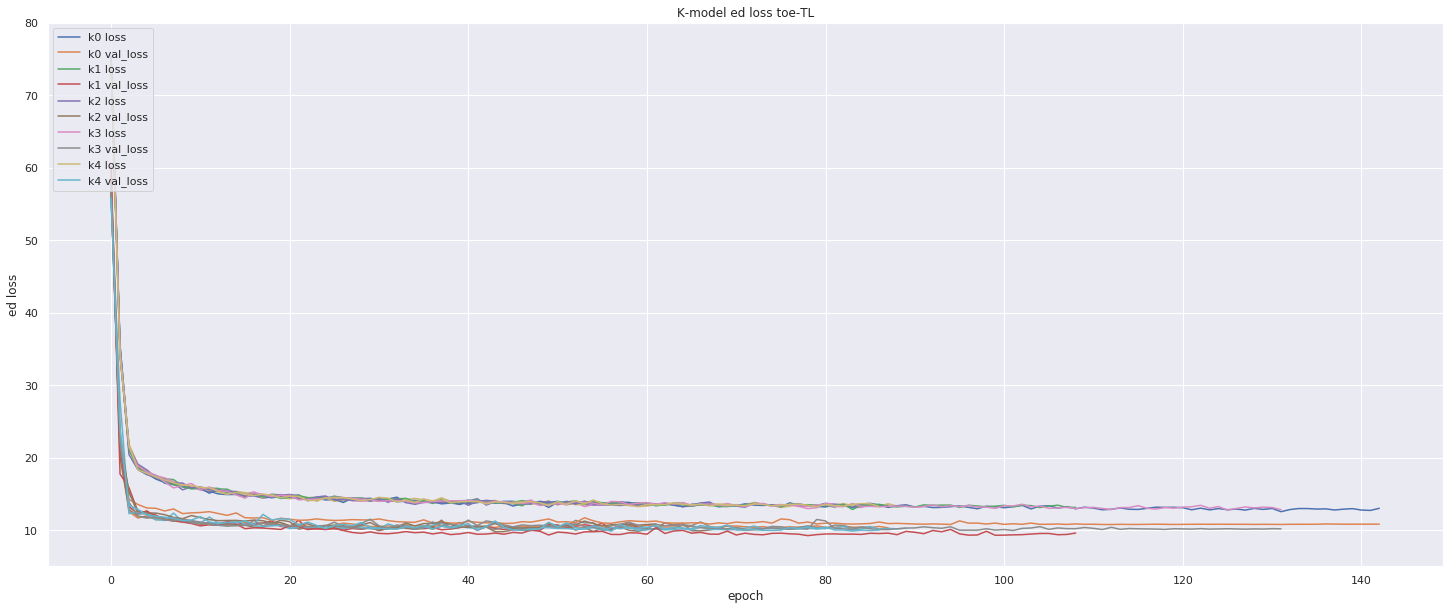

In [97]:
# Sum plot losses toe-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])

    
plt.title('K-model ed loss toe-TL')
plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_TL.png', bbox_inches = 'tight')

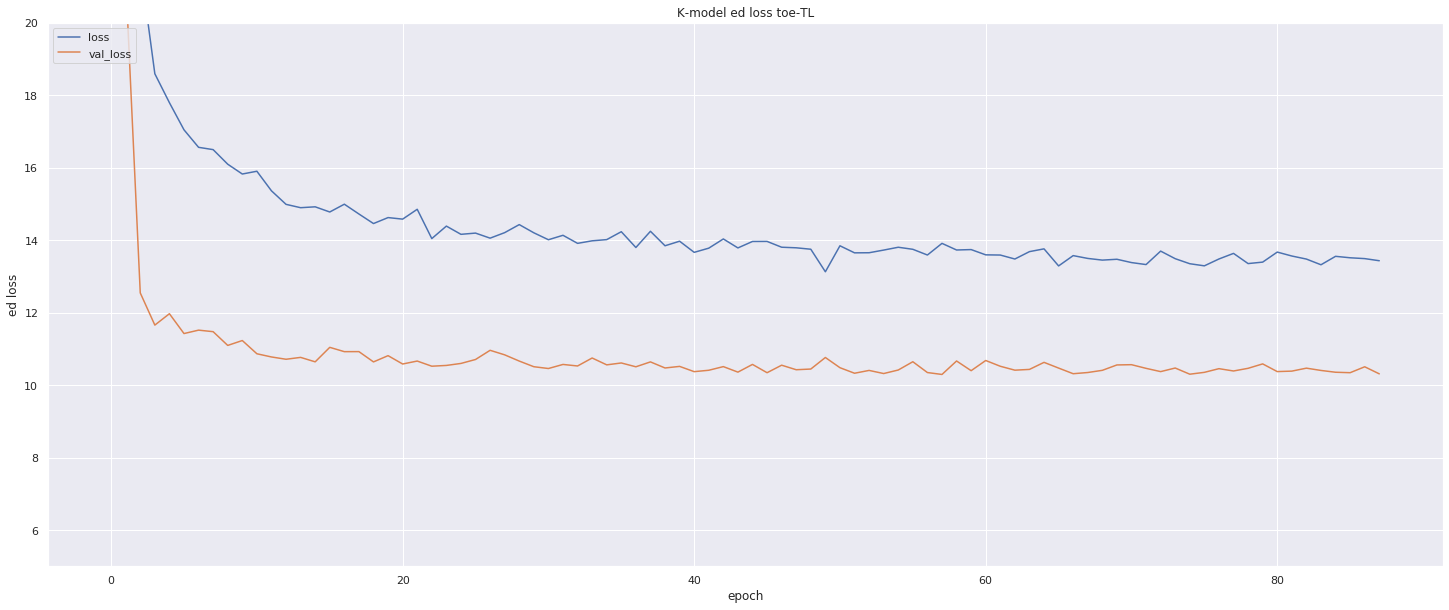

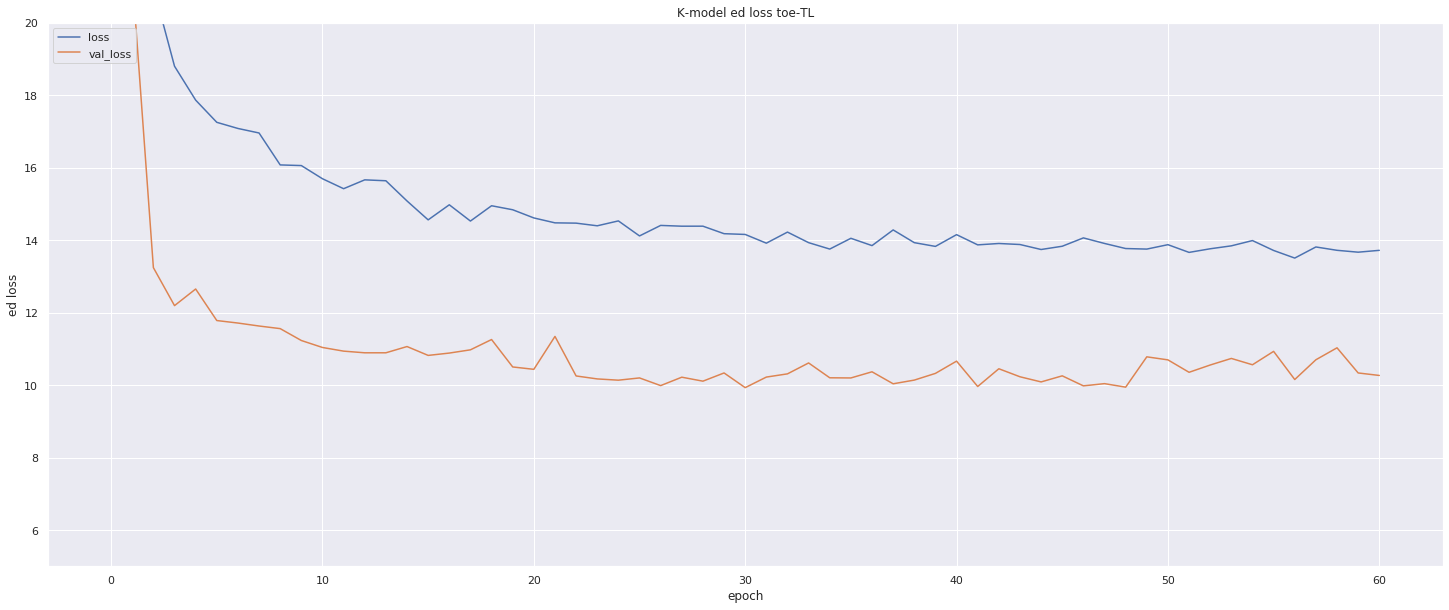

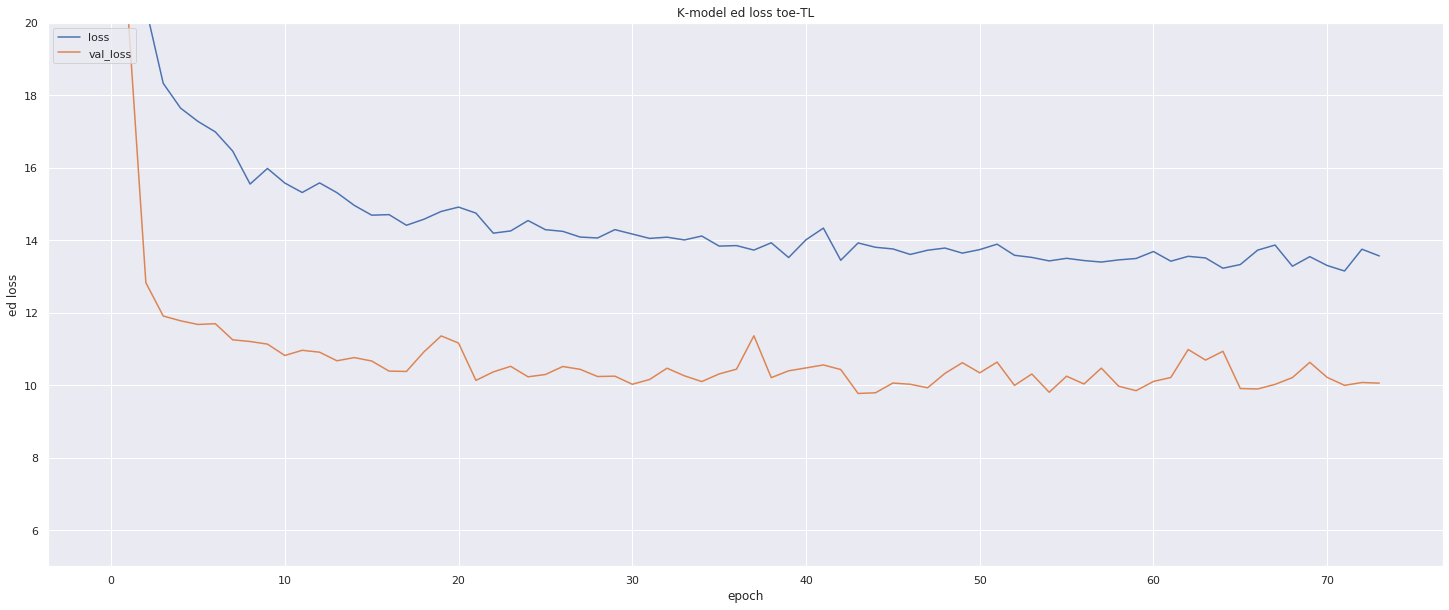

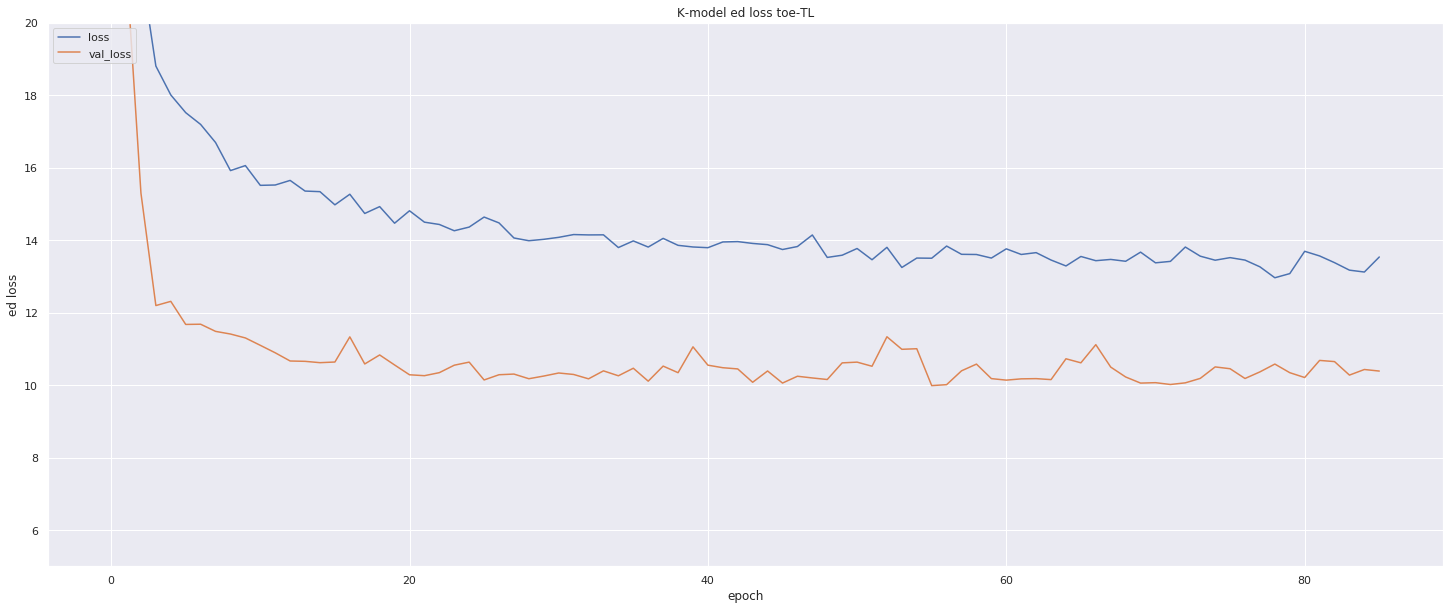

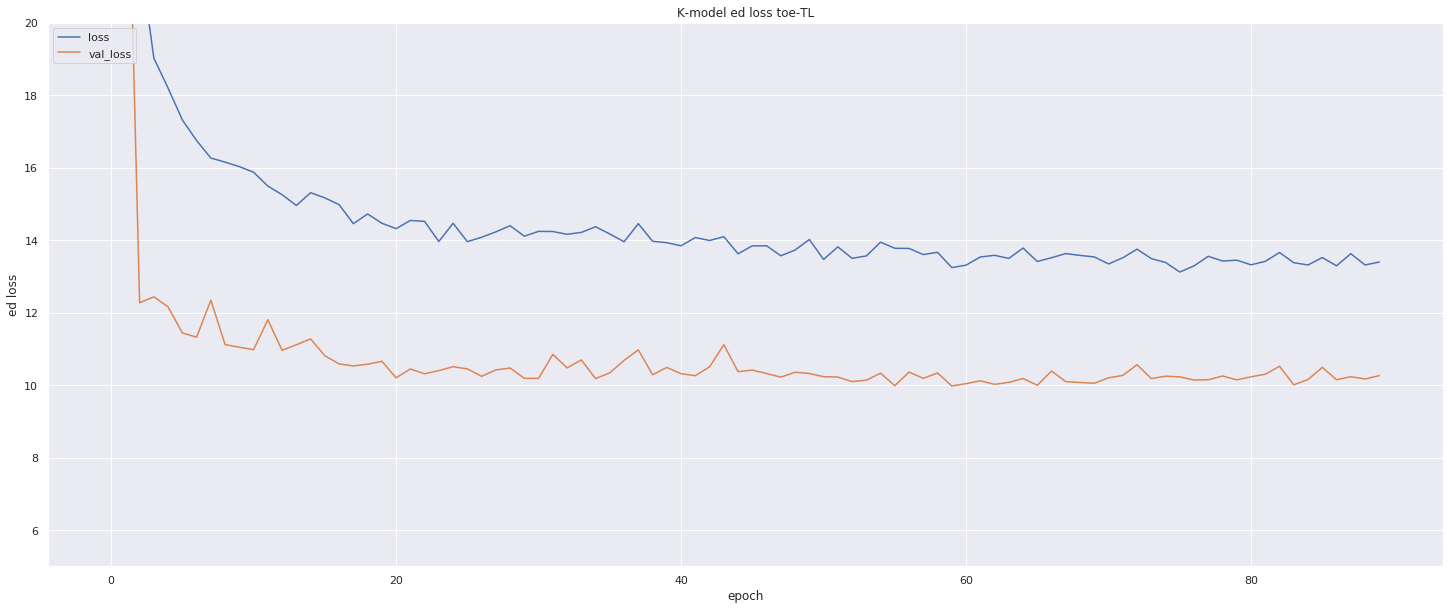

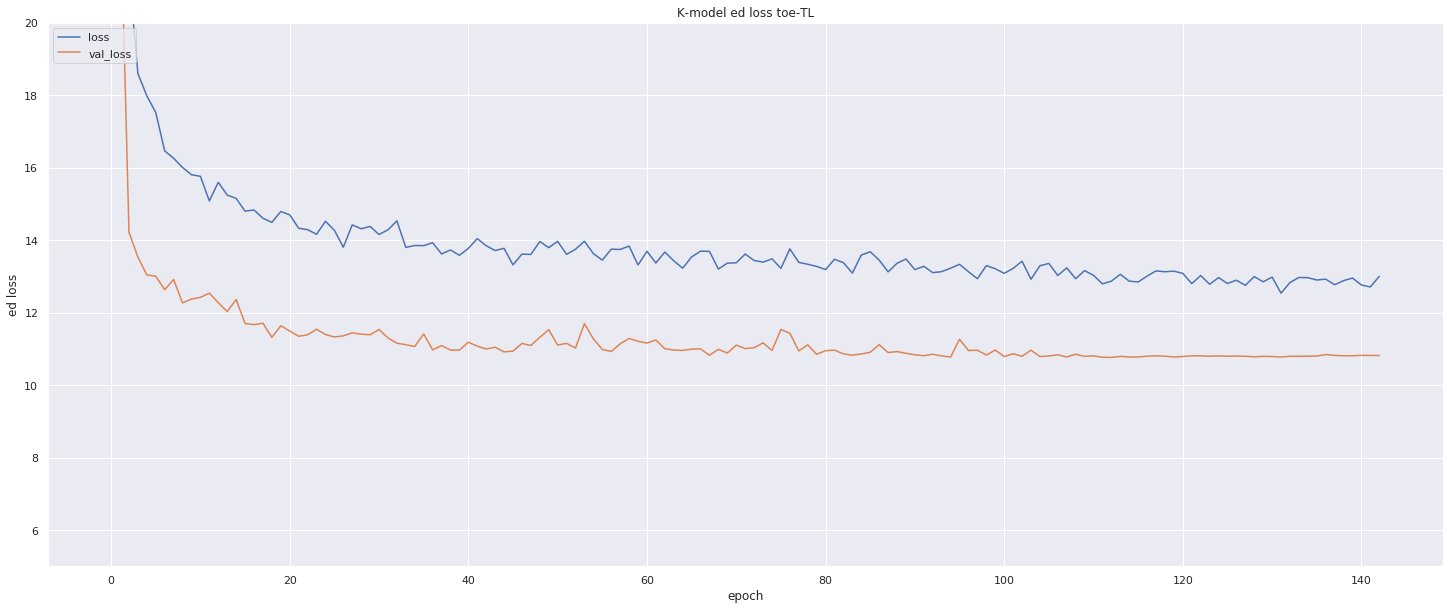

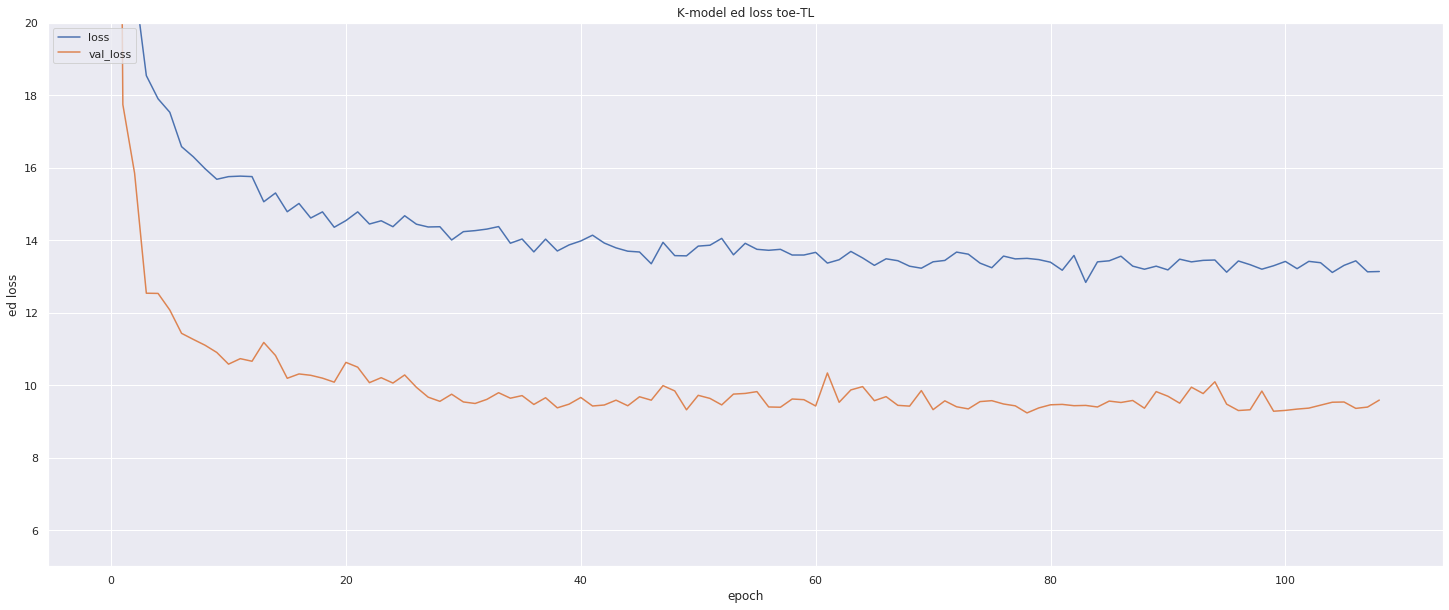

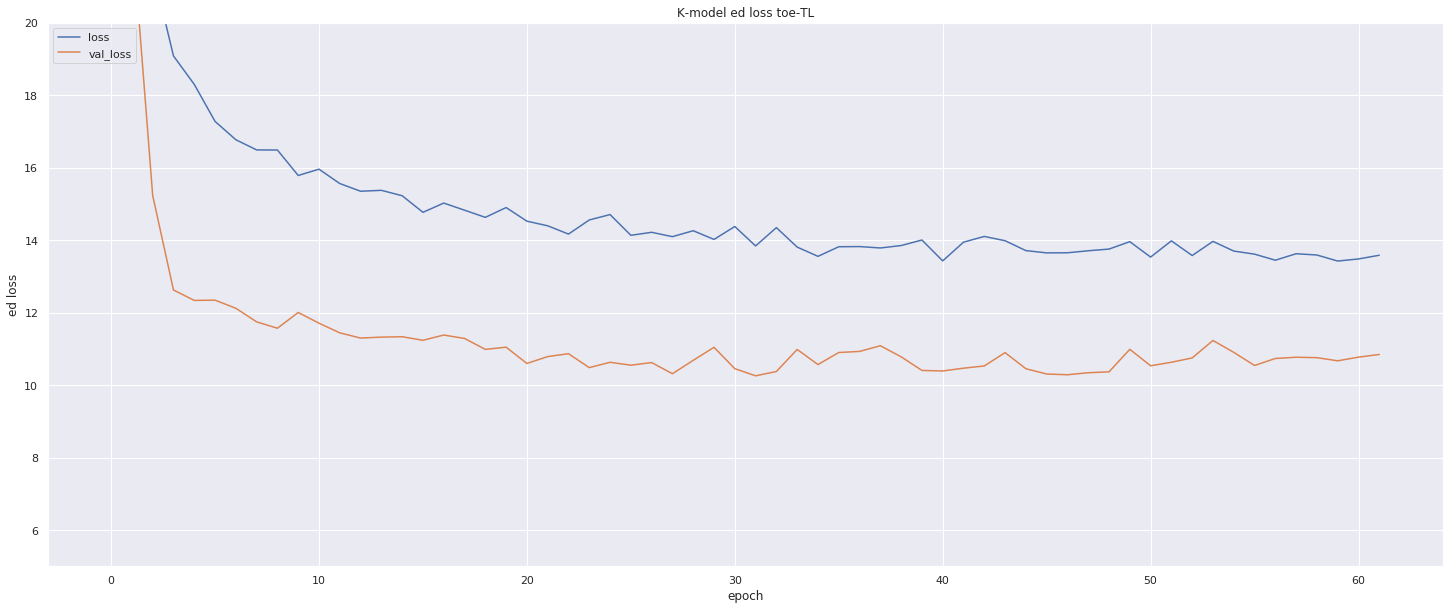

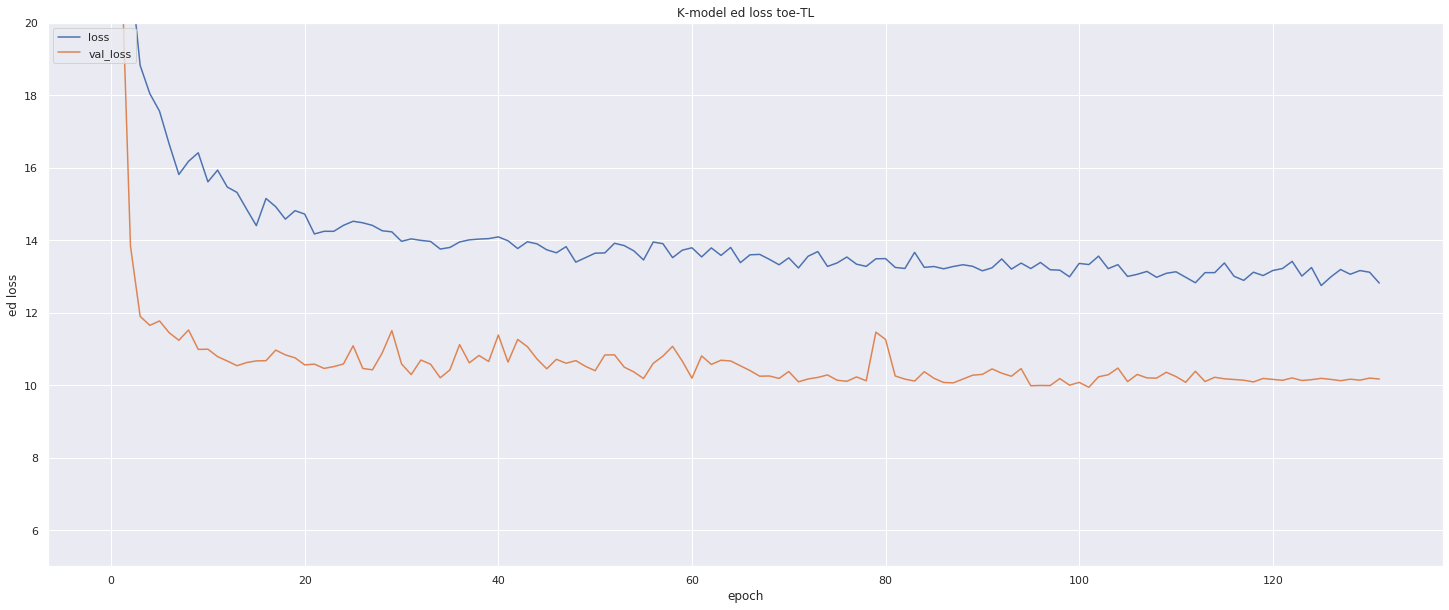

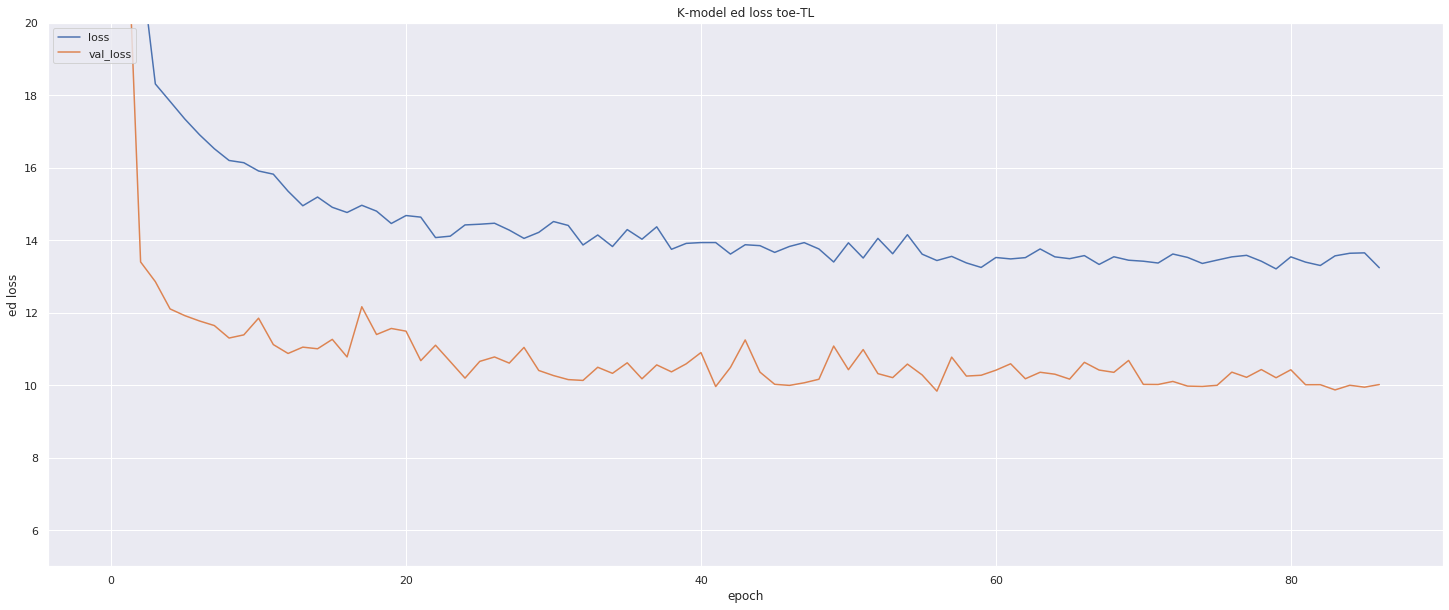

In [98]:
# Single plot loss toe-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe[k].history['loss'])
    plt.plot(history_toe[k].history['val_loss'])
    plt.title('K-model ed loss toe-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


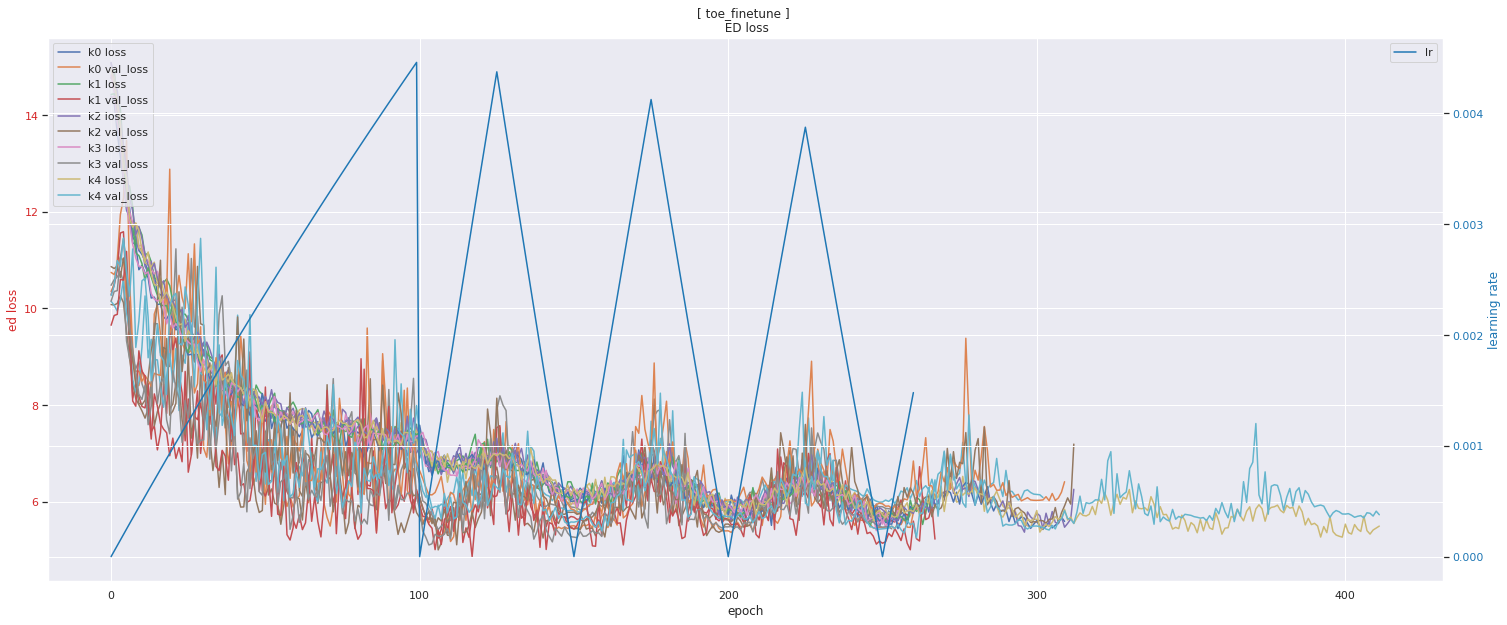

In [99]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
# h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
#     h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


t_vl = np.mean(t_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_ft_Ksum-clr_ed{round(t_vl,4)}.png', bbox_inches = 'tight')

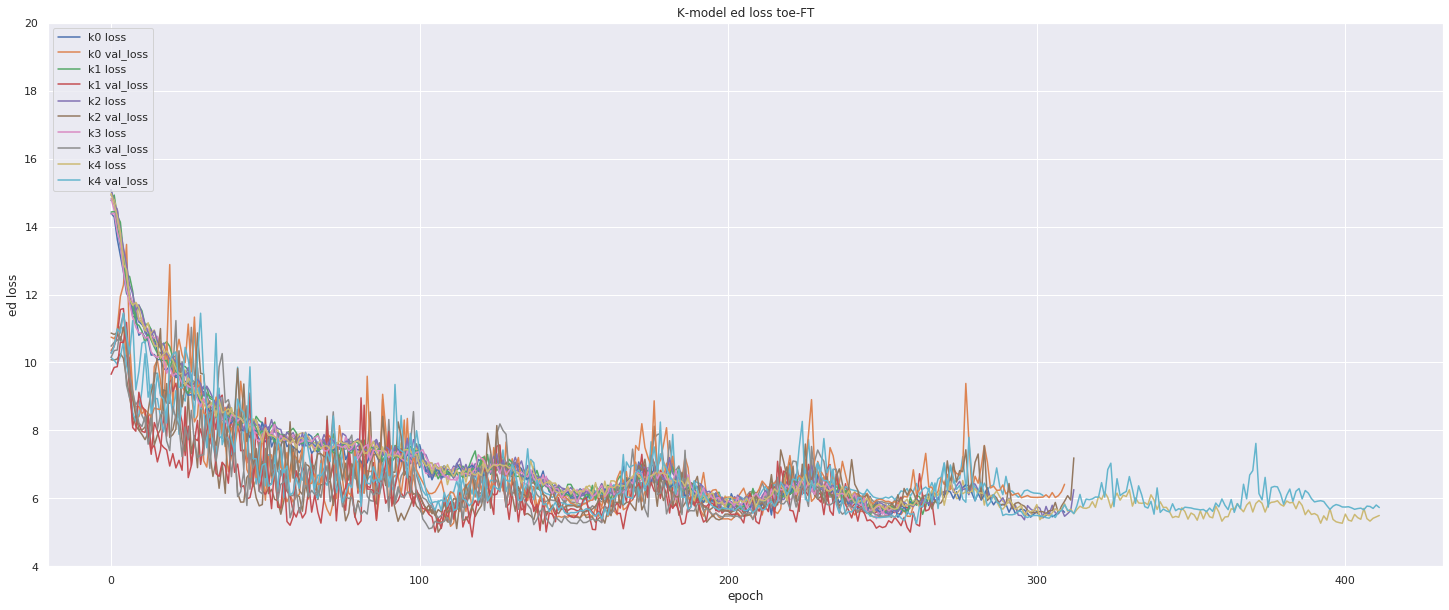

In [100]:
# Sum plot losses toe-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss toe-FT')
plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_Ksum_FT.png', bbox_inches = 'tight')

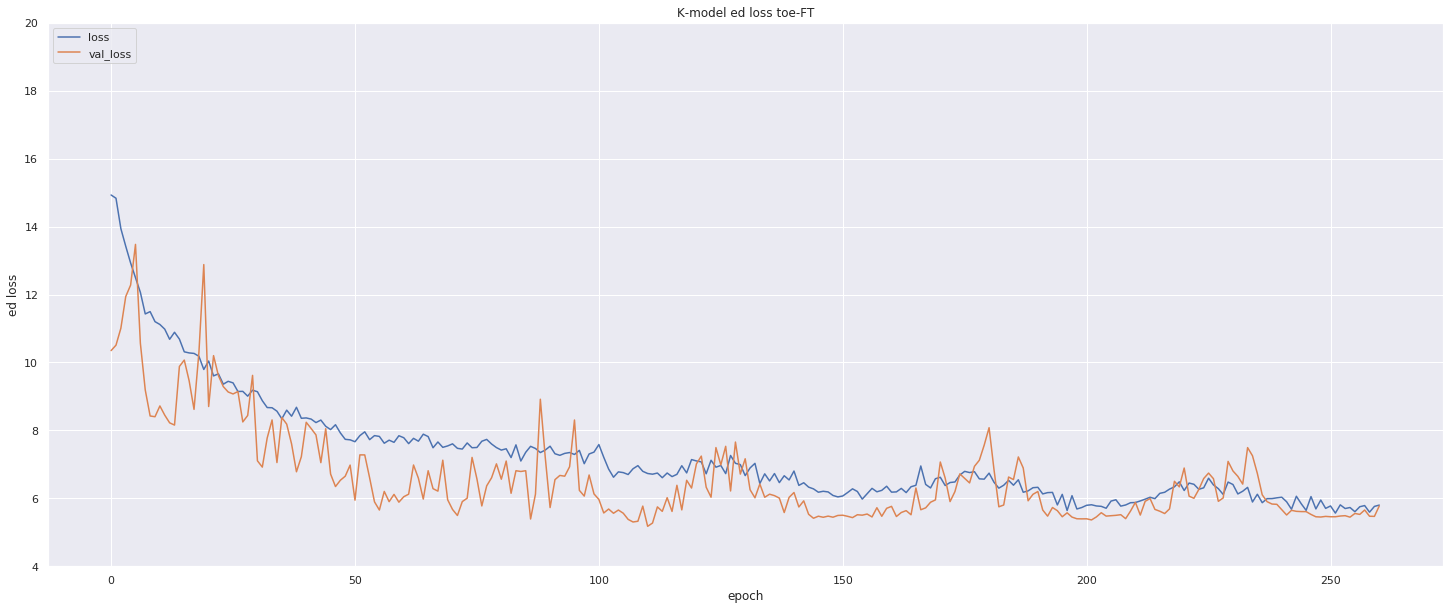

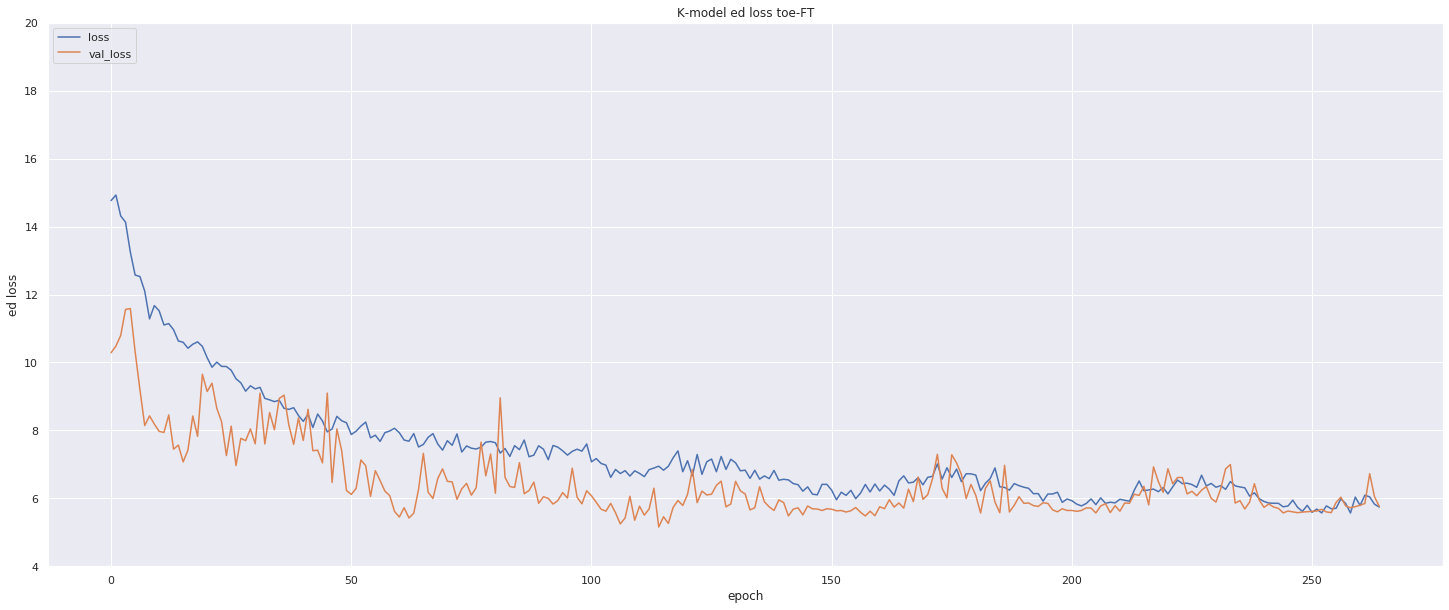

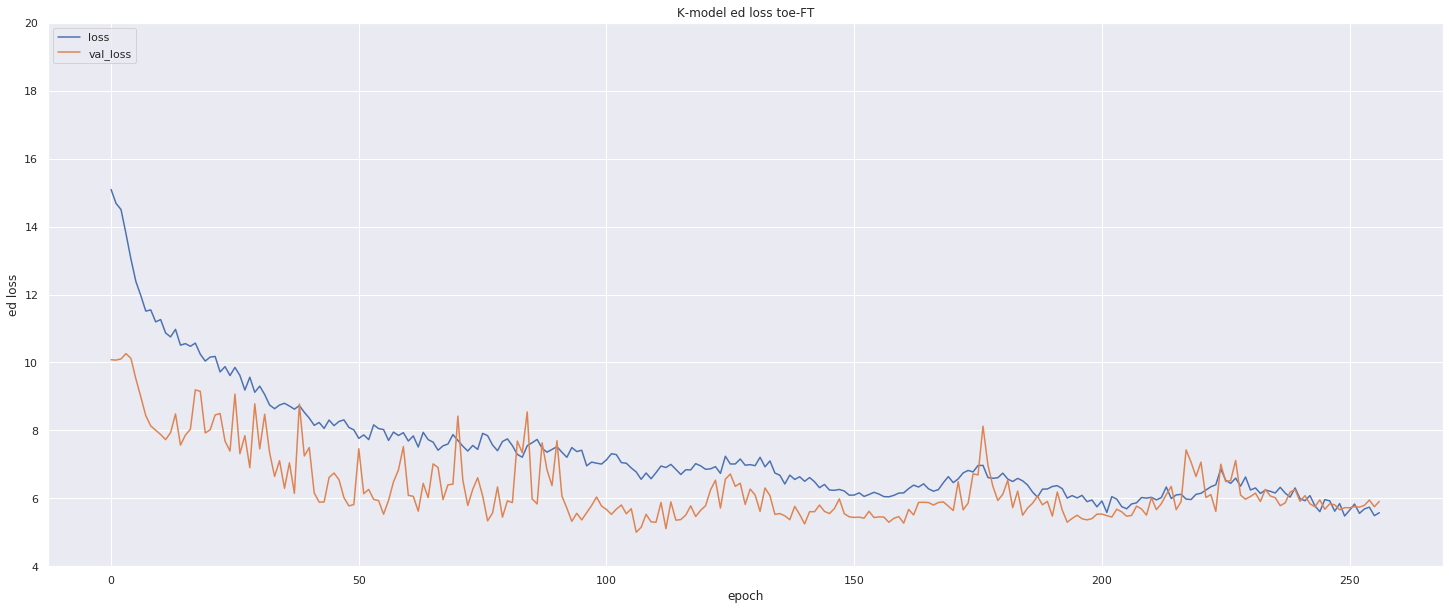

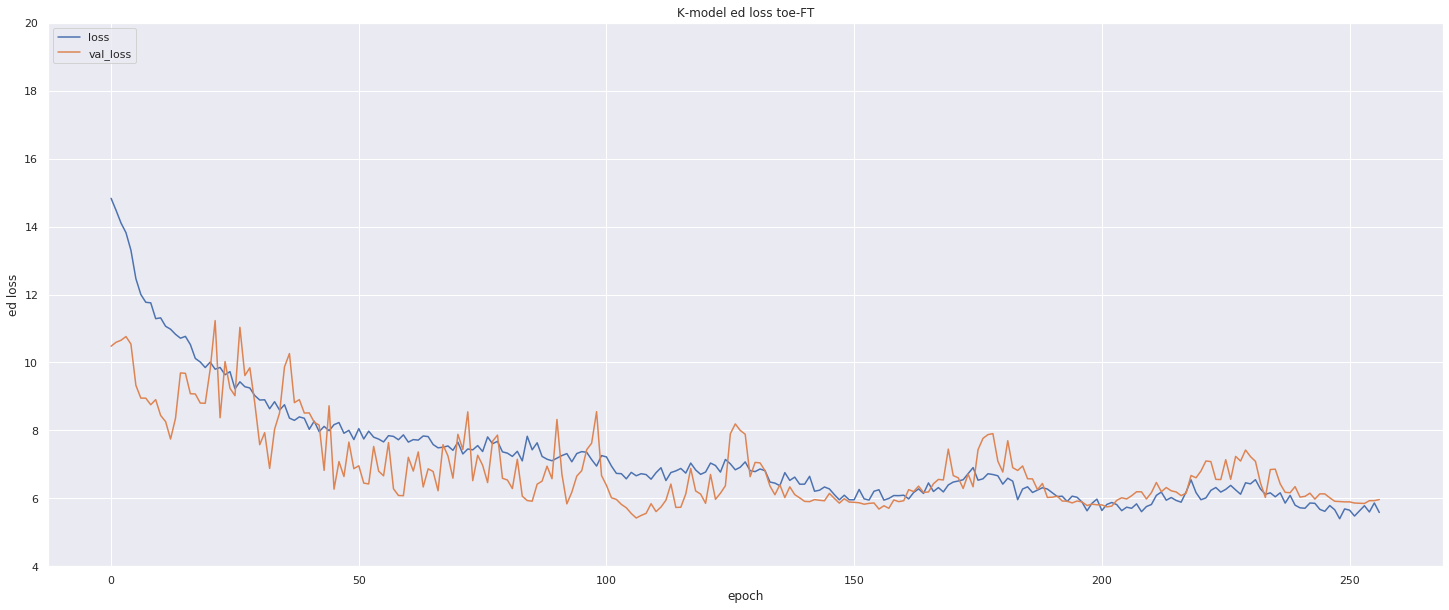

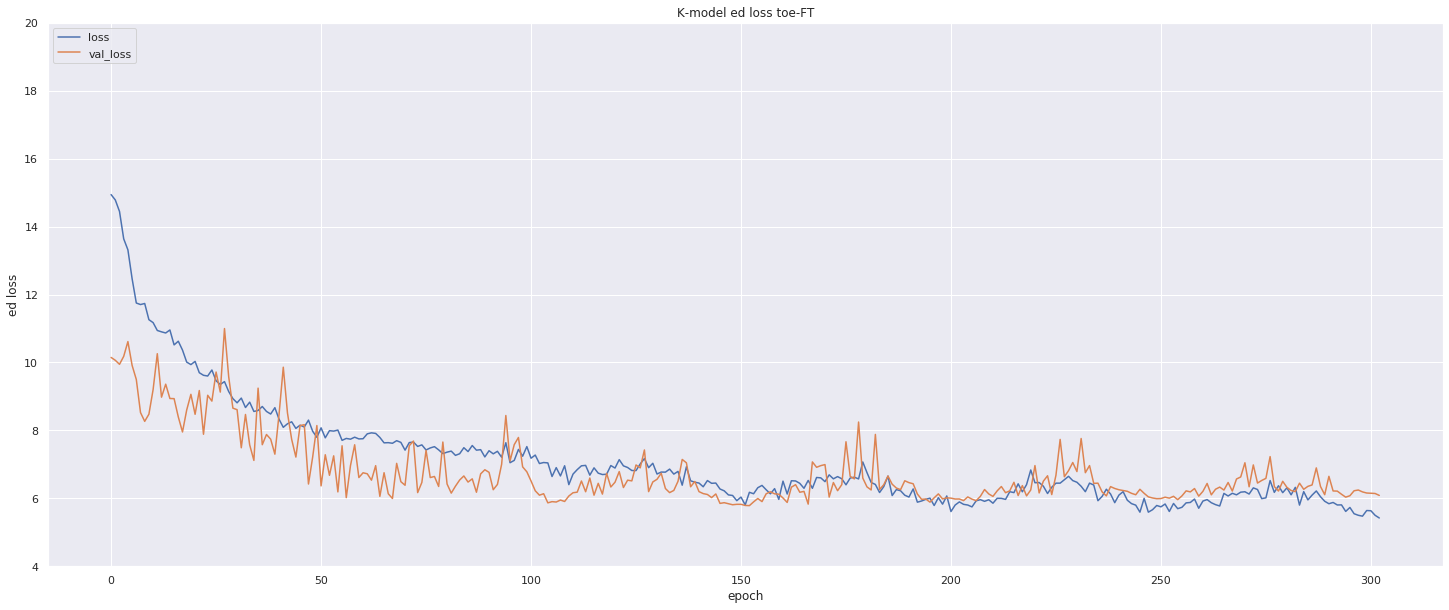

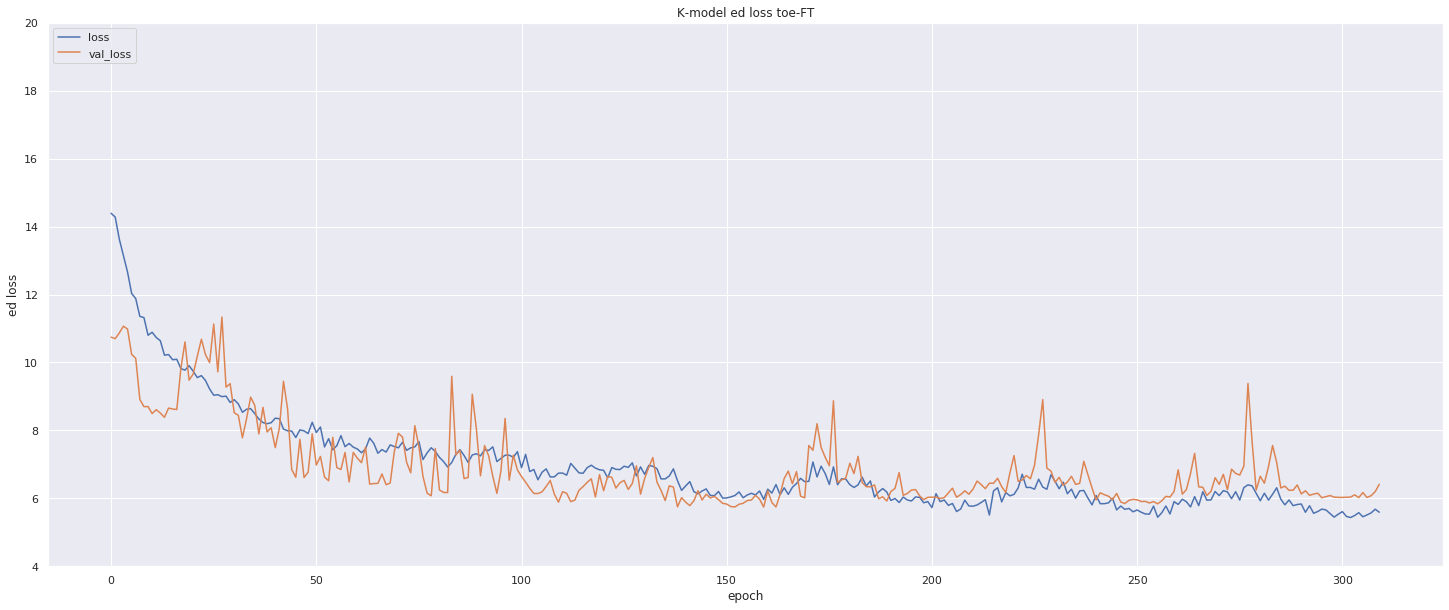

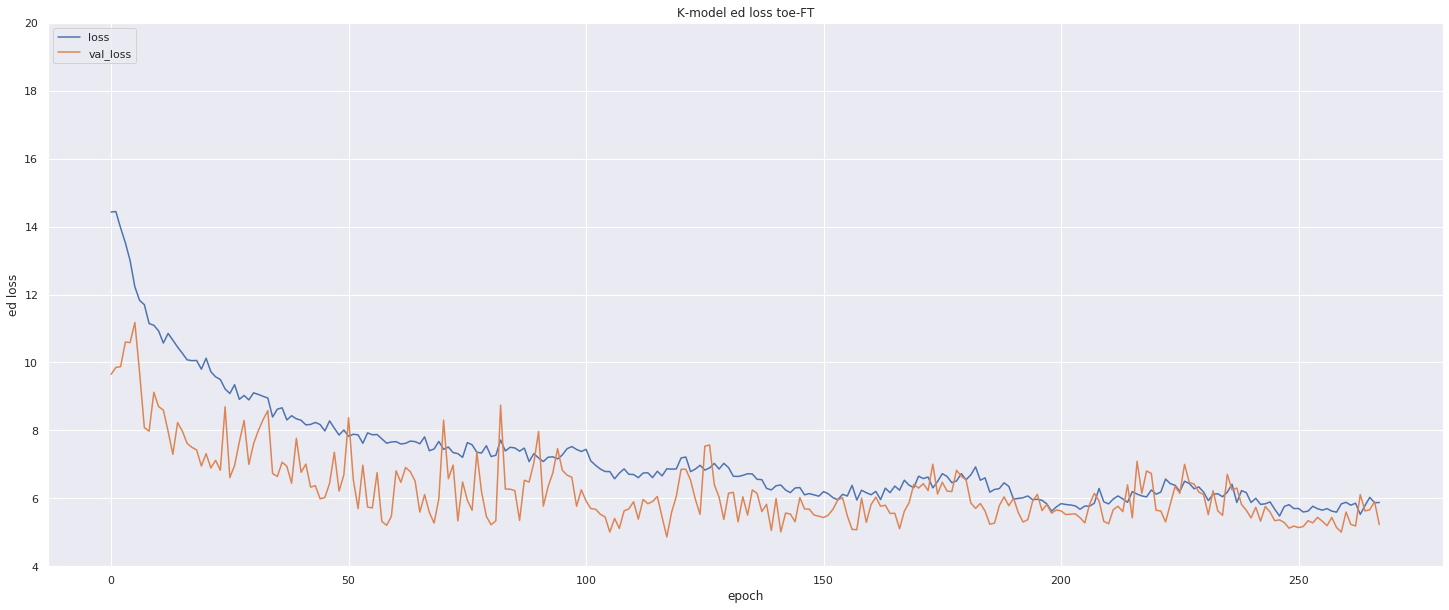

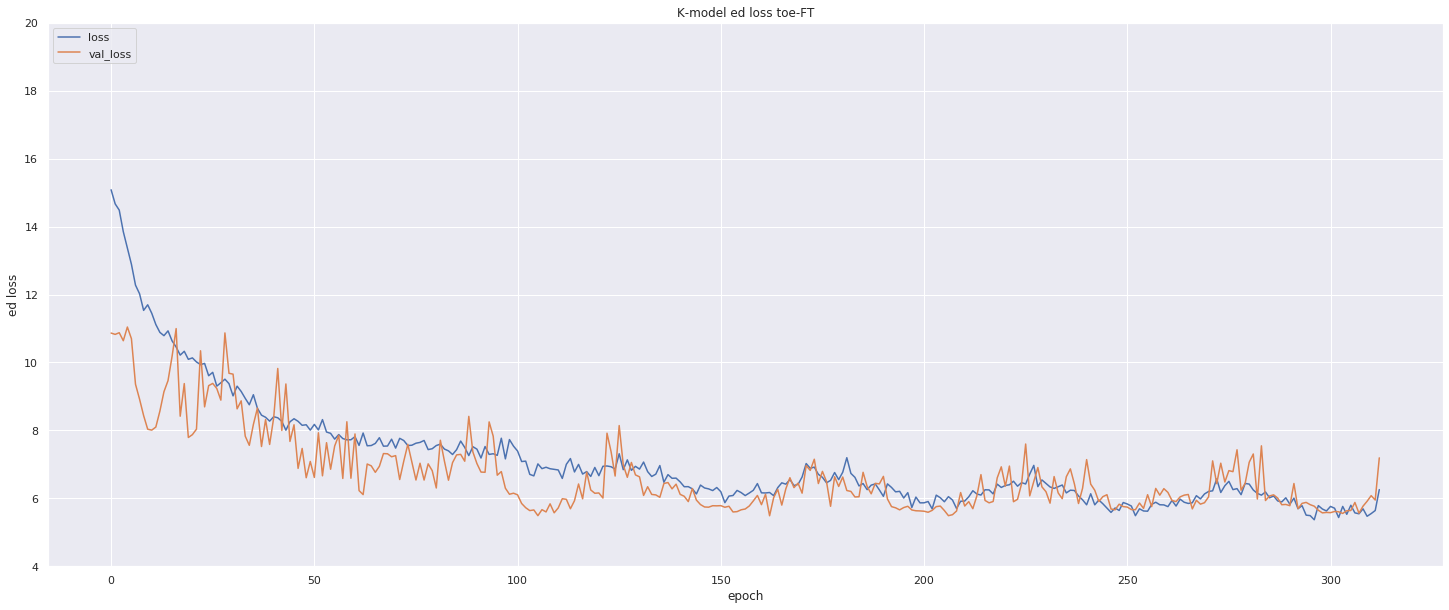

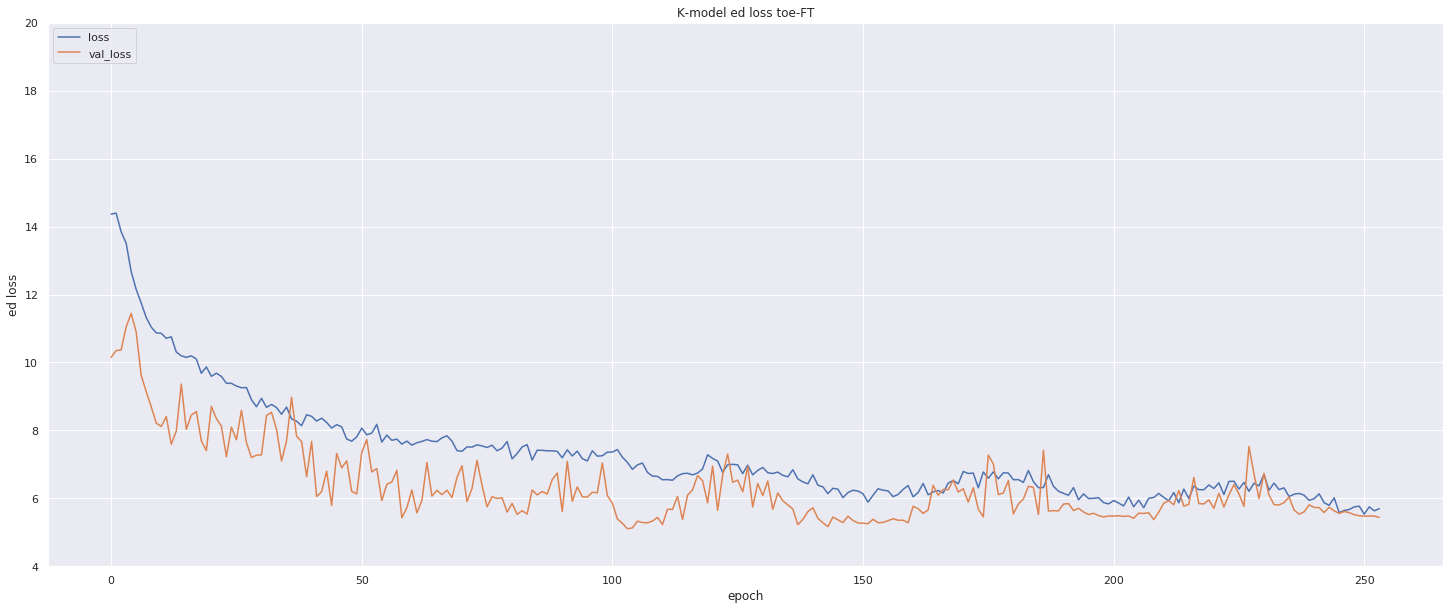

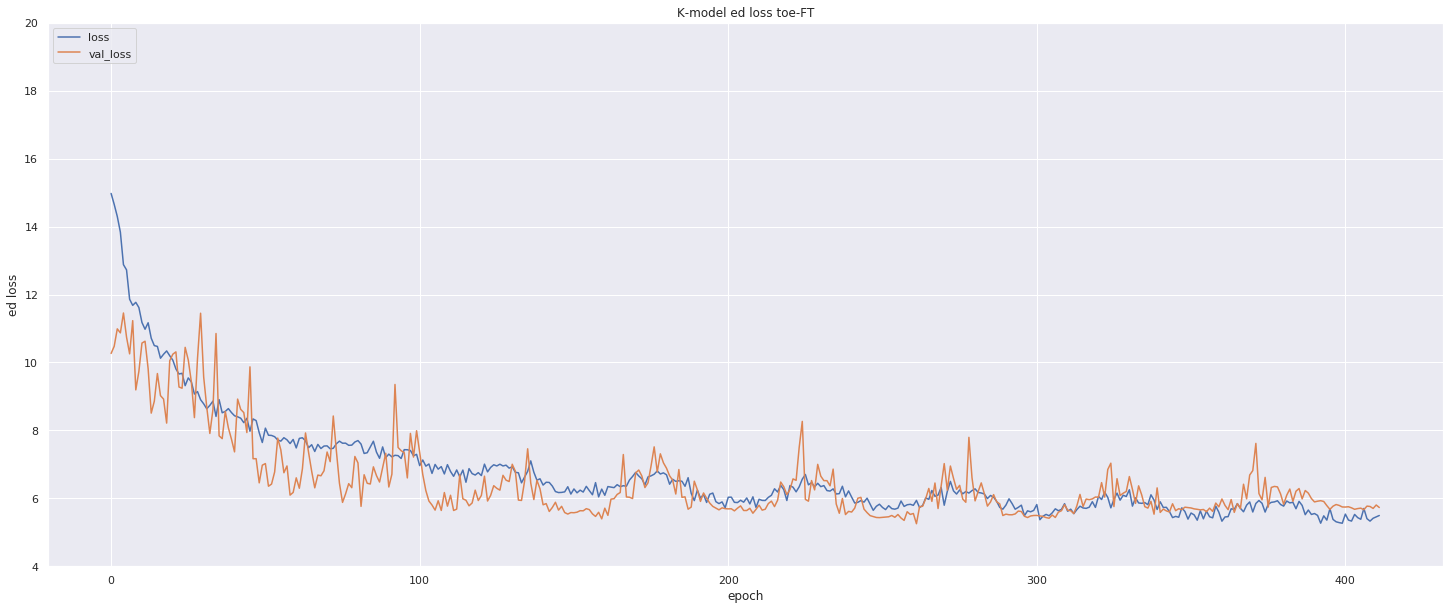

In [101]:
# Single plot loss toe-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_toe_finetune[k].history['loss'])
    plt.plot(history_toe_finetune[k].history['val_loss'])
    plt.title('K-model ed loss toe-FT')
    plt.ylabel('ed loss'), plt.ylim(4, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_toe_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_toe_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Heel K-model

In [102]:
%%time

# big K = 5 (fold 0 ~ 4) 
# KFlodNum = 5 # follow Toe's K.



history_heel = []
history_heel_finetune = []

#above until 'train_ds_map_toe now' to 'train_ds_map_toe_s', 'valid_ds_map_toe_s'
for k in range(KFlodNum):
    
    
    # Split data to train/valid with K-Fold #
    print("K=", k)
#     # Toe split
#     train_ds_map_toe_s, valid_ds_map_toe_s = get_KFold_ds(train_ds_map_toe, K=k)
    
#     # Toe ds_pre
#     train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
#     valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)
    
    
    # heel split
    train_ds_map_heel_s, valid_ds_map_heel_s = get_KFold_ds(train_ds_map_heel, K=k)
    # Heel ds_pre
    train_ds_pre_heel_s = configure_for_performance_cache_train_AToe(train_ds_map_heel_s, augment=True)
    valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)
    
    
    # Train K-Model with transfer learnling #
    
    # Toe model, TL
    #th = 'toe'
    th = 'heel'
    best_model_name = get_best_model_name(th, K=str(k))
    best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = monitor, 
                                 mode = 'auto', verbose = 1)
    callbacks_heel_tl = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=30), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
                        PrintLRtoe()
                        ]
    callbacks_heel_fn = [
                    #     tensorboard_callback,
                        best_model_save,
                        tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=150), #patience=step_size or ep_num
                    #     lr_reduceonplateau,
                        tf.keras.callbacks.LearningRateScheduler(clr3),#lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp, CosineDecayCLRWarmUpLSW
                        PrintLRheel()
                    ]
    print('best_model_name:', best_model_name)


    top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
    drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
    outputnum = 2
    with strategy.scope():
        model_heel = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num_transf, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_tl)#, validation_split=0.1)
    history_heel.append(hist)
    
      
    # Train K-Model with fine tune #
    
    # Toe model, FT
    unfreeze_model(model_heel)
    count_model_trainOrNot_layers(model_heel)
    # fit the model on all data
    hist = model_heel.fit(train_ds_pre_heel_s, 
                          verbose=1, 
                          epochs=ep_num, 
                          validation_data=valid_ds_pre_heel_s, 
                          callbacks=callbacks_heel_fn)#, validation_split=0.1)
    history_heel_finetune.append(hist)


K= 0
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
best_model_name: ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
base_model.trainable :  False

[20210303-0433-09] Learning rate for epoch 1 is 0.0012959649320691824
Epoch 1/500
19/19 [==============================] - ETA: 0s - loss: 106.0287
Epoch 00001: val_loss improved from inf to 80.18867, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w1

19/19 [==============================] - ETA: 0s - loss: 16.4484
Epoch 00021: val_loss improved from 13.50450 to 13.25815, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 16.4484 - val_loss: 13.2581

[20210303-0435-05] Learning rate for epoch 22 is 0.0012959649320691824
Epoch 22/500
19/19 [==============================] - ETA: 0s - loss: 16.3582
Epoch 00022: val_loss improved from 13.25815 to 12.97921, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 16.3582 - val_loss: 12.9792

[20210303-0435-09] Learning rate for epoch 23 is 0.0012959649320691824
Epoch 23/500
19/19 [==============================] - ETA: 0s - loss: 16.3668
Epoch 00023: val_loss improved from 12.97921 to 12.81170, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [======================


[20210303-0436-47] Learning rate for epoch 46 is 0.0012959649320691824
Epoch 46/500
18/19 [===========================>..] - ETA: 0s - loss: 15.6062
Epoch 00046: val_loss improved from 9.50736 to 9.19887, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 15.5635 - val_loss: 9.1989

[20210303-0436-52] Learning rate for epoch 47 is 0.0012959649320691824
Epoch 47/500
19/19 [==============================] - ETA: 0s - loss: 15.4136
Epoch 00047: val_loss did not improve from 9.19887
19/19 [==============================] - 0s 22ms/step - loss: 15.4136 - val_loss: 11.0536

[20210303-0436-56] Learning rate for epoch 48 is 0.0012959649320691824
Epoch 48/500
18/19 [===========================>..] - ETA: 0s - loss: 15.3818
Epoch 00048: val_loss improved from 9.19887 to 8.98926, saving model to ./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] -

18/19 [===========================>..] - ETA: 0s - loss: 15.6072
Epoch 00073: val_loss did not improve from 8.51793
19/19 [==============================] - 0s 22ms/step - loss: 15.6490 - val_loss: 8.8580

[20210303-0438-43] Learning rate for epoch 74 is 0.0012959649320691824
Epoch 74/500
19/19 [==============================] - ETA: 0s - loss: 15.6004
Epoch 00074: val_loss did not improve from 8.51793
19/19 [==============================] - 0s 21ms/step - loss: 15.6004 - val_loss: 9.6161

[20210303-0438-47] Learning rate for epoch 75 is 0.0012959649320691824
Epoch 75/500
18/19 [===========================>..] - ETA: 0s - loss: 15.1204
Epoch 00075: val_loss did not improve from 8.51793
19/19 [==============================] - 0s 21ms/step - loss: 15.2051 - val_loss: 9.0432

[20210303-0438-51] Learning rate for epoch 76 is 0.0012959649320691824
Epoch 76/500
17/19 [=========================>....] - ETA: 0s - loss: 15.1640
Epoch 00076: val_loss did not improve from 8.51793
19/19 [=======

Epoch 1/1000
19/19 [==============================] - ETA: 0s - loss: 24.5532
Epoch 00001: val_loss did not improve from 8.51793

[20210303-0441-06] Learning rate for epoch 1 is 4.999999987376214e-07
19/19 [==============================] - 18s 932ms/step - loss: 24.5532 - val_loss: 13.9871
Epoch 2/1000
19/19 [==============================] - ETA: 0s - loss: 23.4031
Epoch 00002: val_loss did not improve from 8.51793

[20210303-0441-13] Learning rate for epoch 2 is 5.044450517743826e-05
19/19 [==============================] - 3s 140ms/step - loss: 23.4031 - val_loss: 15.0795
Epoch 3/1000
19/19 [==============================] - ETA: 0s - loss: 18.3414
Epoch 00003: val_loss did not improve from 8.51793

[20210303-0441-34] Learning rate for epoch 3 is 0.00010028902033809572
19/19 [==============================] - 17s 917ms/step - loss: 18.3414 - val_loss: 13.0703
Epoch 4/1000
19/19 [==============================] - ETA: 0s - loss: 15.3783
Epoch 00004: val_loss did not improve from 8.5

Epoch 28/1000
19/19 [==============================] - ETA: 0s - loss: 7.9952
Epoch 00028: val_loss did not improve from 4.29886

[20210303-0443-36] Learning rate for epoch 28 is 0.0013139051152393222
19/19 [==============================] - 1s 58ms/step - loss: 7.9952 - val_loss: 149.0622
Epoch 29/1000
19/19 [==============================] - ETA: 0s - loss: 7.8801
Epoch 00029: val_loss did not improve from 4.29886

[20210303-0443-41] Learning rate for epoch 29 is 0.0013611499452963471
19/19 [==============================] - 1s 59ms/step - loss: 7.8801 - val_loss: 9.1644
Epoch 30/1000
19/19 [==============================] - ETA: 0s - loss: 7.3151
Epoch 00030: val_loss did not improve from 4.29886

[20210303-0443-46] Learning rate for epoch 30 is 0.001408294658176601
19/19 [==============================] - 1s 59ms/step - loss: 7.3151 - val_loss: 7.3813
Epoch 31/1000
19/19 [==============================] - ETA: 0s - loss: 7.5094
Epoch 00031: val_loss did not improve from 4.29886

[2

Epoch 56/1000
19/19 [==============================] - ETA: 0s - loss: 6.7832
Epoch 00056: val_loss did not improve from 3.50397

[20210303-0445-52] Learning rate for epoch 56 is 0.00259896251372993
19/19 [==============================] - 1s 59ms/step - loss: 6.7832 - val_loss: 190.0500
Epoch 57/1000
19/19 [==============================] - ETA: 0s - loss: 6.6597
Epoch 00057: val_loss did not improve from 3.50397

[20210303-0445-57] Learning rate for epoch 57 is 0.0026434077881276608
19/19 [==============================] - 1s 60ms/step - loss: 6.6597 - val_loss: 62.9568
Epoch 58/1000
19/19 [==============================] - ETA: 0s - loss: 6.8299
Epoch 00058: val_loss did not improve from 3.50397

[20210303-0446-02] Learning rate for epoch 58 is 0.0026877527125179768
19/19 [==============================] - 1s 59ms/step - loss: 6.8299 - val_loss: 61.3251
Epoch 59/1000
19/19 [==============================] - ETA: 0s - loss: 6.8880
Epoch 00059: val_loss did not improve from 3.50397

[

Epoch 85/1000
19/19 [==============================] - ETA: 0s - loss: 6.3891
Epoch 00085: val_loss did not improve from 3.50397

[20210303-0448-12] Learning rate for epoch 85 is 0.003847273299470544
19/19 [==============================] - 1s 59ms/step - loss: 6.3891 - val_loss: 23.5294
Epoch 86/1000
19/19 [==============================] - ETA: 0s - loss: 6.6165
Epoch 00086: val_loss did not improve from 3.50397

[20210303-0448-17] Learning rate for epoch 86 is 0.0038888186682015657
19/19 [==============================] - 1s 59ms/step - loss: 6.6165 - val_loss: 8.9633
Epoch 87/1000
19/19 [==============================] - ETA: 0s - loss: 6.2223
Epoch 00087: val_loss did not improve from 3.50397

[20210303-0448-21] Learning rate for epoch 87 is 0.00393026415258646
19/19 [==============================] - 1s 59ms/step - loss: 6.2223 - val_loss: 8.7878
Epoch 88/1000
19/19 [==============================] - ETA: 0s - loss: 6.3823
Epoch 00088: val_loss did not improve from 3.50397

[2021

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.9469
Epoch 00195: val_loss did not improve from 3.59180

[20210303-0539-02] Learning rate for epoch 195 is 0.0009675062610767782
19/19 [==============================] - 1s 60ms/step - loss: 5.9469 - val_loss: 3.6028
Epoch 196/1000
19/19 [==============================] - ETA: 0s - loss: 5.8427
Epoch 00196: val_loss did not improve from 3.59180

[20210303-0539-07] Learning rate for epoch 196 is 0.0008053220226429403
19/19 [==============================] - 1s 59ms/step - loss: 5.8427 - val_loss: 3.5968
Epoch 197/1000
19/19 [==============================] - ETA: 0s - loss: 5.5429
Epoch 00197: val_loss did not improve from 3.59180

[20210303-0539-12] Learning rate for epoch 197 is 0.0006435376708395779
19/19 [==============================] - 1s 59ms/step - loss: 5.5429 - val_loss: 3.8076
Epoch 198/1000
19/19 [==============================] - ETA: 0s - loss: 5.6133
Epoch 00198: val_loss did not improve from 3.59180

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.7838
Epoch 00223: val_loss did not improve from 3.59180

[20210303-0541-17] Learning rate for epoch 223 is 0.0034232467878609896
19/19 [==============================] - 1s 60ms/step - loss: 5.7838 - val_loss: 4.4877
Epoch 224/1000
19/19 [==============================] - ETA: 0s - loss: 5.7048
Epoch 00224: val_loss did not improve from 3.59180

[20210303-0541-22] Learning rate for epoch 224 is 0.0035742311738431454
19/19 [==============================] - 1s 60ms/step - loss: 5.7048 - val_loss: 6.2935
Epoch 225/1000
19/19 [==============================] - ETA: 0s - loss: 5.9923
Epoch 00225: val_loss did not improve from 3.59180

[20210303-0541-27] Learning rate for epoch 225 is 0.003724815556779504
19/19 [==============================] - 1s 59ms/step - loss: 5.9923 - val_loss: 5.1076
Epoch 226/1000
19/19 [==============================] - ETA: 0s - loss: 5.9278
Epoch 00226: val_loss did not improve from 3.59180

[20210303-05

Epoch 251/1000
19/19 [==============================] - ETA: 0s - loss: 6.1087
Epoch 00251: val_loss improved from 3.58251 to 3.58146, saving model to ./20210302-230617/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0543-34] Learning rate for epoch 251 is 3.7500001326407073e-07
19/19 [==============================] - 2s 90ms/step - loss: 6.1087 - val_loss: 3.5815
Epoch 252/1000
19/19 [==============================] - ETA: 0s - loss: 5.3331
Epoch 00252: val_loss did not improve from 3.58146

[20210303-0543-39] Learning rate for epoch 252 is 0.00015015952521935105
19/19 [==============================] - 1s 60ms/step - loss: 5.3331 - val_loss: 3.5961
Epoch 253/1000
19/19 [==============================] - ETA: 0s - loss: 5.4163
Epoch 00253: val_loss did not improve from 3.58146

[20210303-0543-44] Learning rate for epoch 253 is 0.0002995440736413002
19/19 [==============================] - 1s 61ms/step - loss: 5.4163 - val_loss: 3.6397
Epoch 254/1000
19/19 [==============

Epoch 279/1000
19/19 [==============================] - ETA: 0s - loss: 5.9432
Epoch 00279: val_loss did not improve from 3.58146

[20210303-0545-52] Learning rate for epoch 279 is 0.0031768432818353176
19/19 [==============================] - 1s 59ms/step - loss: 5.9432 - val_loss: 5.7653
Epoch 280/1000
19/19 [==============================] - ETA: 0s - loss: 5.7565
Epoch 00280: val_loss did not improve from 3.58146

[20210303-0545-57] Learning rate for epoch 280 is 0.0030282577499747276
19/19 [==============================] - 1s 60ms/step - loss: 5.7565 - val_loss: 4.0532
Epoch 281/1000
19/19 [==============================] - ETA: 0s - loss: 5.8930
Epoch 00281: val_loss did not improve from 3.58146

[20210303-0546-02] Learning rate for epoch 281 is 0.0028800719883292913
19/19 [==============================] - 1s 60ms/step - loss: 5.8930 - val_loss: 5.8370
Epoch 282/1000
19/19 [==============================] - ETA: 0s - loss: 5.7180
Epoch 00282: val_loss did not improve from 3.581

19/19 [==============================] - ETA: 0s - loss: 5.2906
Epoch 00307: val_loss did not improve from 3.58146

[20210303-0548-07] Learning rate for epoch 307 is 0.0008330637356266379
19/19 [==============================] - 1s 61ms/step - loss: 5.2906 - val_loss: 3.7559
Epoch 308/1000
19/19 [==============================] - ETA: 0s - loss: 5.3419
Epoch 00308: val_loss did not improve from 3.58146

[20210303-0548-12] Learning rate for epoch 308 is 0.0009704494732432067
19/19 [==============================] - 1s 60ms/step - loss: 5.3419 - val_loss: 3.7794
Epoch 309/1000
19/19 [==============================] - ETA: 0s - loss: 4.9923
Epoch 00309: val_loss did not improve from 3.58146

[20210303-0548-17] Learning rate for epoch 309 is 0.0011074353242293
19/19 [==============================] - 1s 59ms/step - loss: 4.9923 - val_loss: 3.7735
Epoch 310/1000
19/19 [==============================] - ETA: 0s - loss: 5.1028
Epoch 00310: val_loss did not improve from 3.58146

[20210303-0548

19/19 [==============================] - ETA: 0s - loss: 5.6309
Epoch 00335: val_loss did not improve from 3.58146

[20210303-0550-23] Learning rate for epoch 335 is 0.0021313198376446962
19/19 [==============================] - 1s 60ms/step - loss: 5.6309 - val_loss: 56.1653
Epoch 336/1000
19/19 [==============================] - ETA: 0s - loss: 5.4609
Epoch 00336: val_loss did not improve from 3.58146

[20210303-0550-28] Learning rate for epoch 336 is 0.001995133003219962
19/19 [==============================] - 1s 60ms/step - loss: 5.4609 - val_loss: 8.8260
Epoch 337/1000
16/19 [========================>.....] - ETA: 0s - loss: 4.9347

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.0585
Epoch 00416: val_loss did not improve from 3.29423

[20210303-0637-43] Learning rate for epoch 416 is 0.0017551169730722904
19/19 [==============================] - 1s 59ms/step - loss: 5.0585 - val_loss: 3.8578
Epoch 417/1000
19/19 [==============================] - ETA: 0s - loss: 5.1942
Epoch 00417: val_loss did not improve from 3.29423

[20210303-0637-48] Learning rate for epoch 417 is 0.0018689051503315568
19/19 [==============================] - 1s 59ms/step - loss: 5.1942 - val_loss: 3.6719
Epoch 418/1000
19/19 [==============================] - ETA: 0s - loss: 5.8626
Epoch 00418: val_loss did not improve from 3.29423

[20210303-0637-53] Learning rate for epoch 418 is 0.001982293324545026
19/19 [==============================] - 1s 59ms/step - loss: 5.8626 - val_loss: 3.6817
Epoch 419/1000
19/19 [==============================] - ETA: 0s - loss: 5.1698
Epoch 00419: val_loss did not improve from 3.29423

[20210303-06

19/19 [==============================] - ETA: 0s - loss: 5.7155
Epoch 00444: val_loss did not improve from 3.29423

[20210303-0639-58] Learning rate for epoch 444 is 0.0007800005259923637
19/19 [==============================] - 1s 59ms/step - loss: 5.7155 - val_loss: 3.6479
Epoch 445/1000
19/19 [==============================] - ETA: 0s - loss: 5.1563
Epoch 00445: val_loss did not improve from 3.29423

[20210303-0640-02] Learning rate for epoch 445 is 0.000667411251924932
19/19 [==============================] - 1s 59ms/step - loss: 5.1563 - val_loss: 3.4798
Epoch 446/1000
19/19 [==============================] - ETA: 0s - loss: 5.2950
Epoch 00446: val_loss did not improve from 3.29423

[20210303-0640-07] Learning rate for epoch 446 is 0.0005552219809032977
19/19 [==============================] - 1s 60ms/step - loss: 5.2950 - val_loss: 3.4220
Epoch 447/1000
19/19 [==============================] - ETA: 0s - loss: 4.9768
Epoch 00447: val_loss did not improve from 3.29423

[20210303-06

19/19 [==============================] - 1s 41ms/step - loss: 17.0665 - val_loss: 17.6096

[20210303-0642-02] Learning rate for epoch 13 is 0.0012959649320691824
Epoch 13/500
18/19 [===========================>..] - ETA: 0s - loss: 17.0370
Epoch 00013: val_loss improved from 17.60961 to 17.52848, saving model to ./20210302-230617/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 16.9593 - val_loss: 17.5285

[20210303-0642-06] Learning rate for epoch 14 is 0.0012959649320691824
Epoch 14/500
18/19 [===========================>..] - ETA: 0s - loss: 16.5545
Epoch 00014: val_loss improved from 17.52848 to 17.24008, saving model to ./20210302-230617/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 41ms/step - loss: 16.5666 - val_loss: 17.2401

[20210303-0642-11] Learning rate for epoch 15 is 0.0012959649320691824
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 17.0

19/19 [==============================] - 1s 40ms/step - loss: 15.9839 - val_loss: 10.7999

[20210303-0643-42] Learning rate for epoch 36 is 0.0012959649320691824
Epoch 36/500
18/19 [===========================>..] - ETA: 0s - loss: 15.9053
Epoch 00036: val_loss improved from 10.79995 to 10.60940, saving model to ./20210302-230617/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 15.8866 - val_loss: 10.6094

[20210303-0643-46] Learning rate for epoch 37 is 0.0012959649320691824
Epoch 37/500
19/19 [==============================] - ETA: 0s - loss: 16.1175
Epoch 00037: val_loss did not improve from 10.60940
19/19 [==============================] - 0s 21ms/step - loss: 16.1175 - val_loss: 10.7223

[20210303-0643-50] Learning rate for epoch 38 is 0.0012959649320691824
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 16.1960
Epoch 00038: val_loss did not improve from 10.60940
19/19 [===========================


[20210303-0645-29] Learning rate for epoch 62 is 0.0012959649320691824
Epoch 62/500
17/19 [=========================>....] - ETA: 0s - loss: 15.1499
Epoch 00062: val_loss did not improve from 9.41636
19/19 [==============================] - 0s 21ms/step - loss: 15.0818 - val_loss: 9.8816

[20210303-0645-33] Learning rate for epoch 63 is 0.0012959649320691824
Epoch 63/500
19/19 [==============================] - ETA: 0s - loss: 15.6479
Epoch 00063: val_loss did not improve from 9.41636
19/19 [==============================] - 0s 21ms/step - loss: 15.6479 - val_loss: 9.8530

[20210303-0645-37] Learning rate for epoch 64 is 0.0012959649320691824
Epoch 64/500
18/19 [===========================>..] - ETA: 0s - loss: 15.4196
Epoch 00064: val_loss did not improve from 9.41636
19/19 [==============================] - 0s 21ms/step - loss: 15.5248 - val_loss: 10.1333

[20210303-0645-41] Learning rate for epoch 65 is 0.0012959649320691824
Epoch 65/500
18/19 [===========================>..] - ETA

Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 12.4403
Epoch 00008: val_loss did not improve from 8.09059

[20210303-0648-10] Learning rate for epoch 8 is 0.00034801175934262574
19/19 [==============================] - 1s 59ms/step - loss: 12.4403 - val_loss: 9.1945
Epoch 9/1000
19/19 [==============================] - ETA: 0s - loss: 12.0262
Epoch 00009: val_loss did not improve from 8.09059

[20210303-0648-15] Learning rate for epoch 9 is 0.00039725631359033287
19/19 [==============================] - 1s 59ms/step - loss: 12.0262 - val_loss: 11.6522
Epoch 10/1000
19/19 [==============================] - ETA: 0s - loss: 12.4135
Epoch 00010: val_loss did not improve from 8.09059

[20210303-0648-20] Learning rate for epoch 10 is 0.0004464008961804211
19/19 [==============================] - 1s 59ms/step - loss: 12.4135 - val_loss: 10.6612
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 12.1305
Epoch 00011: val_loss did not improve from 8.090

19/19 [==============================] - ETA: 0s - loss: 7.0972
Epoch 00034: val_loss did not improve from 4.20359

[20210303-0650-19] Learning rate for epoch 34 is 0.00159587396774441
19/19 [==============================] - 1s 59ms/step - loss: 7.0972 - val_loss: 5.5290
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 7.2031
Epoch 00035: val_loss did not improve from 4.20359

[20210303-0650-24] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 1s 59ms/step - loss: 7.2031 - val_loss: 4.3096
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 7.1094
Epoch 00036: val_loss did not improve from 4.20359

[20210303-0650-28] Learning rate for epoch 36 is 0.0016890636179596186
19/19 [==============================] - 1s 59ms/step - loss: 7.1094 - val_loss: 8.6579
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 6.8181
Epoch 00037: val_loss did not improve from 4.20359

[20210303-0650-33] L

Epoch 62/1000
19/19 [==============================] - ETA: 0s - loss: 6.9135
Epoch 00062: val_loss did not improve from 4.02996

[20210303-0652-35] Learning rate for epoch 62 is 0.0028641331009566784
19/19 [==============================] - 1s 60ms/step - loss: 6.9135 - val_loss: 4.0990
Epoch 63/1000
19/19 [==============================] - ETA: 0s - loss: 6.4950
Epoch 00063: val_loss did not improve from 4.02996

[20210303-0652-39] Learning rate for epoch 63 is 0.0029079781379550695
19/19 [==============================] - 1s 60ms/step - loss: 6.4950 - val_loss: 6.7318
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 6.4289
Epoch 00064: val_loss did not improve from 4.02996

[20210303-0652-44] Learning rate for epoch 64 is 0.002951723290607333
19/19 [==============================] - 1s 60ms/step - loss: 6.4289 - val_loss: 5.2129
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 6.0875
Epoch 00065: val_loss did not improve from 4.02996

[202

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 5.3321
Epoch 00256: val_loss did not improve from 2.92426

[20210303-0740-28] Learning rate for epoch 256 is 0.0007452979916706681
19/19 [==============================] - 1s 58ms/step - loss: 5.3321 - val_loss: 3.4583
Epoch 257/1000
19/19 [==============================] - ETA: 0s - loss: 5.5044
Epoch 00257: val_loss did not improve from 2.92426

[20210303-0740-33] Learning rate for epoch 257 is 0.0008930827025324106
19/19 [==============================] - 1s 60ms/step - loss: 5.5044 - val_loss: 3.2201
Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 5.3715
Epoch 00258: val_loss did not improve from 2.92426

[20210303-0740-37] Learning rate for epoch 258 is 0.0010404675267636776
19/19 [==============================] - 1s 59ms/step - loss: 5.3715 - val_loss: 3.4878
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.5762
Epoch 00259: val_loss did not improve from 2.92426

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 16.9133
Epoch 00018: val_loss did not improve from 16.48035
19/19 [==============================] - 0s 21ms/step - loss: 16.9133 - val_loss: 16.8431

[20210303-0742-23] Learning rate for epoch 19 is 0.0012959649320691824
Epoch 19/500
17/19 [=========================>....] - ETA: 0s - loss: 16.7632
Epoch 00019: val_loss improved from 16.48035 to 15.70127, saving model to ./20210302-230617/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 16.7619 - val_loss: 15.7013

[20210303-0742-28] Learning rate for epoch 20 is 0.0012959649320691824
Epoch 20/500
18/19 [===========================>..] - ETA: 0s - loss: 17.3797
Epoch 00020: val_loss improved from 15.70127 to 15.70076, saving model to ./20210302-230617/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 17.3429 - val_loss: 15.7008

[20210303-0742-32] Learning 

19/19 [==============================] - 1s 40ms/step - loss: 15.7765 - val_loss: 9.9359

[20210303-0743-59] Learning rate for epoch 41 is 0.0012959649320691824
Epoch 41/500
19/19 [==============================] - ETA: 0s - loss: 15.7392
Epoch 00041: val_loss did not improve from 9.93590
19/19 [==============================] - 0s 21ms/step - loss: 15.7392 - val_loss: 10.0503

[20210303-0744-03] Learning rate for epoch 42 is 0.0012959649320691824
Epoch 42/500
16/19 [========================>.....] - ETA: 0s - loss: 15.8225
Epoch 00042: val_loss did not improve from 9.93590
19/19 [==============================] - 0s 21ms/step - loss: 15.9118 - val_loss: 10.4933

[20210303-0744-07] Learning rate for epoch 43 is 0.0012959649320691824
Epoch 43/500
19/19 [==============================] - ETA: 0s - loss: 16.0298
Epoch 00043: val_loss did not improve from 9.93590
19/19 [==============================] - 0s 21ms/step - loss: 16.0298 - val_loss: 12.3602

[20210303-0744-11] Learning rate for 

18/19 [===========================>..] - ETA: 0s - loss: 15.3745
Epoch 00067: val_loss did not improve from 9.24526
19/19 [==============================] - 0s 21ms/step - loss: 15.4177 - val_loss: 9.4307

[20210303-0745-50] Learning rate for epoch 68 is 0.0012959649320691824
Epoch 68/500
18/19 [===========================>..] - ETA: 0s - loss: 14.9970
Epoch 00068: val_loss did not improve from 9.24526
19/19 [==============================] - 0s 21ms/step - loss: 15.0501 - val_loss: 9.5327

[20210303-0745-54] Learning rate for epoch 69 is 0.0012959649320691824
Epoch 69/500
18/19 [===========================>..] - ETA: 0s - loss: 15.5324
Epoch 00069: val_loss did not improve from 9.24526
19/19 [==============================] - 0s 21ms/step - loss: 15.4703 - val_loss: 9.8196

[20210303-0745-58] Learning rate for epoch 70 is 0.0012959649320691824
Epoch 70/500
18/19 [===========================>..] - ETA: 0s - loss: 15.5171
Epoch 00070: val_loss did not improve from 9.24526
19/19 [=======


[20210303-0747-40] Learning rate for epoch 95 is 0.0012959649320691824
Epoch 95/500
19/19 [==============================] - ETA: 0s - loss: 15.7507
Epoch 00095: val_loss did not improve from 9.11464
19/19 [==============================] - 0s 21ms/step - loss: 15.7507 - val_loss: 9.1671

[20210303-0747-44] Learning rate for epoch 96 is 0.0012959649320691824
Epoch 96/500
18/19 [===========================>..] - ETA: 0s - loss: 15.4280
Epoch 00096: val_loss did not improve from 9.11464
19/19 [==============================] - 0s 21ms/step - loss: 15.5368 - val_loss: 9.6643

[20210303-0747-48] Learning rate for epoch 97 is 0.0012959649320691824
Epoch 97/500
18/19 [===========================>..] - ETA: 0s - loss: 15.5181
Epoch 00097: val_loss did not improve from 9.11464
19/19 [==============================] - 0s 21ms/step - loss: 15.6322 - val_loss: 9.2469

[20210303-0747-52] Learning rate for epoch 98 is 0.0012959649320691824
Epoch 98/500
18/19 [===========================>..] - ETA:

19/19 [==============================] - ETA: 0s - loss: 14.8910
Epoch 00123: val_loss did not improve from 9.11464
19/19 [==============================] - 0s 21ms/step - loss: 14.8910 - val_loss: 9.5840

[20210303-0749-37] Learning rate for epoch 124 is 0.0012959649320691824
Epoch 124/500
19/19 [==============================] - ETA: 0s - loss: 14.8451
Epoch 00124: val_loss did not improve from 9.11464
19/19 [==============================] - 0s 21ms/step - loss: 14.8451 - val_loss: 9.4250

*********************************** Start fine tune ***********************************
tt: 195, nt:46, total layers:241
*********************************** Start fine tune ***********************************
Epoch 1/1000
19/19 [==============================] - ETA: 0s - loss: 24.5894
Epoch 00001: val_loss did not improve from 9.11464

[20210303-0750-10] Learning rate for epoch 1 is 4.999999987376214e-07
19/19 [==============================] - 14s 715ms/step - loss: 24.5894 - val_loss: 15.8843
E

Epoch 25/1000
19/19 [==============================] - ETA: 0s - loss: 7.4884
Epoch 00025: val_loss did not improve from 4.34789

[20210303-0752-24] Learning rate for epoch 25 is 0.001171570853330195
19/19 [==============================] - 1s 60ms/step - loss: 7.4884 - val_loss: 5.0824
Epoch 26/1000
19/19 [==============================] - ETA: 0s - loss: 7.5140
Epoch 00026: val_loss did not improve from 4.34789

[20210303-0752-29] Learning rate for epoch 26 is 0.001219115569256246
19/19 [==============================] - 1s 59ms/step - loss: 7.5140 - val_loss: 5.7301
Epoch 27/1000
19/19 [==============================] - ETA: 0s - loss: 7.2352
Epoch 00027: val_loss did not improve from 4.34789

[20210303-0752-34] Learning rate for epoch 27 is 0.0012665604008361697
19/19 [==============================] - 1s 60ms/step - loss: 7.2352 - val_loss: 7.7954
Epoch 28/1000
19/19 [==============================] - ETA: 0s - loss: 7.9762
Epoch 00028: val_loss did not improve from 4.34789

[2021

19/19 [==============================] - ETA: 0s - loss: 6.5739
Epoch 00053: val_loss did not improve from 4.27761

[20210303-0754-39] Learning rate for epoch 53 is 0.002465027617290616
19/19 [==============================] - 1s 60ms/step - loss: 6.5739 - val_loss: 30.6198
Epoch 54/1000
19/19 [==============================] - ETA: 0s - loss: 6.8994
Epoch 00054: val_loss did not improve from 4.27761

[20210303-0754-44] Learning rate for epoch 54 is 0.0025097725447267294
19/19 [==============================] - 1s 59ms/step - loss: 6.8994 - val_loss: 25.1498
Epoch 55/1000
19/19 [==============================] - ETA: 0s - loss: 7.1362
Epoch 00055: val_loss did not improve from 4.27761

[20210303-0754-49] Learning rate for epoch 55 is 0.0025544175878167152
19/19 [==============================] - 1s 59ms/step - loss: 7.1362 - val_loss: 4.5443
Epoch 56/1000
19/19 [==============================] - ETA: 0s - loss: 6.8542
Epoch 00056: val_loss did not improve from 4.27761

[20210303-0754-5

19/19 [==============================] - ETA: 0s - loss: 6.5084
Epoch 00081: val_loss did not improve from 4.00323

[20210303-0756-54] Learning rate for epoch 81 is 0.0036800920497626066
19/19 [==============================] - 1s 59ms/step - loss: 6.5084 - val_loss: 431.9641
Epoch 82/1000
19/19 [==============================] - ETA: 0s - loss: 7.0350
Epoch 00082: val_loss did not improve from 4.00323

[20210303-0756-59] Learning rate for epoch 82 is 0.003722037188708782
19/19 [==============================] - 1s 59ms/step - loss: 7.0350 - val_loss: 672.3046
Epoch 83/1000
19/19 [==============================] - ETA: 0s - loss: 6.5379
Epoch 00083: val_loss did not improve from 4.00323

[20210303-0757-03] Learning rate for epoch 83 is 0.003763882676139474
19/19 [==============================] - 1s 60ms/step - loss: 6.5379 - val_loss: 211.5485
Epoch 84/1000
19/19 [==============================] - ETA: 0s - loss: 6.7881
Epoch 00084: val_loss did not improve from 4.00323

[20210303-075

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19/19 [==============================] - ETA: 0s - loss: 4.8497
Epoch 00499: val_loss did not improve from 3.30790

[20210303-0830-39] Learning rate for epoch 499 is 0.00020103092538192868
19/19 [==============================] - 1s 60ms/step - loss: 4.8497 - val_loss: 3.3909
Epoch 500/1000
19/19 [==============================] - ETA: 0s - loss: 4.9497
Epoch 00500: val_loss did not improve from 3.30790

[20210303-0830-44] Learning rate for epoch 500 is 0.00010044047667179257
19/19 [==============================] - 1s 59ms/step - loss: 4.9497 - val_loss: 3.4074
Epoch 501/1000
19/19 [==============================] - ETA: 0s - loss: 4.8454
Epoch 00501: val_loss did not improve from 3.30790

[20210303-0830-49] Learning rate for epoch 501 is 2.499999993688107e-07
19/19 [==============================] - 1s 60ms/step - loss: 4.8454 - val_loss: 3.4027
Epoch 502/1000
19/19 [==============================] - ETA: 0s - loss: 4.8761
Epoch 00502: val_loss did not improve from 3.30790

[20210303

19/19 [==============================] - ETA: 0s - loss: 5.5240
Epoch 00527: val_loss did not improve from 3.30790

[20210303-0832-54] Learning rate for epoch 527 is 0.0022752094082534313
19/19 [==============================] - 1s 60ms/step - loss: 5.5240 - val_loss: 3.8675
Epoch 528/1000
19/19 [==============================] - ETA: 0s - loss: 4.6177
Epoch 00528: val_loss did not improve from 3.30790

[20210303-0832-59] Learning rate for epoch 528 is 0.002175818895921111
19/19 [==============================] - 1s 60ms/step - loss: 4.6177 - val_loss: 3.9379
Epoch 529/1000
19/19 [==============================] - ETA: 0s - loss: 5.0135
Epoch 00529: val_loss did not improve from 3.30790

[20210303-0833-04] Learning rate for epoch 529 is 0.0020768283866345882
19/19 [==============================] - 1s 61ms/step - loss: 5.0135 - val_loss: 4.2436
Epoch 530/1000
19/19 [==============================] - ETA: 0s - loss: 5.2096
Epoch 00530: val_loss did not improve from 3.30790

[20210303-08

19/19 [==============================] - ETA: 0s - loss: 4.6340
Epoch 00555: val_loss did not improve from 3.30790

[20210303-0835-09] Learning rate for epoch 555 is 0.0003569873224478215
19/19 [==============================] - 1s 59ms/step - loss: 4.6340 - val_loss: 3.4785
Epoch 556/1000
19/19 [==============================] - ETA: 0s - loss: 4.8673
Epoch 00556: val_loss did not improve from 3.30790

[20210303-0835-14] Learning rate for epoch 556 is 0.0004451780114322901
19/19 [==============================] - 1s 59ms/step - loss: 4.8673 - val_loss: 3.5018
Epoch 557/1000
19/19 [==============================] - ETA: 0s - loss: 4.5000
Epoch 00557: val_loss did not improve from 3.30790

[20210303-0835-19] Learning rate for epoch 557 is 0.0005329687264747918
19/19 [==============================] - 1s 60ms/step - loss: 4.5000 - val_loss: 3.4270
Epoch 558/1000
19/19 [==============================] - ETA: 0s - loss: 4.5869
Epoch 00558: val_loss did not improve from 3.30790

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 4.7880
Epoch 00583: val_loss did not improve from 3.30790

[20210303-0837-24] Learning rate for epoch 583 is 0.0015048584900796413
19/19 [==============================] - 1s 60ms/step - loss: 4.7880 - val_loss: 3.4932
Epoch 584/1000
19/19 [==============================] - ETA: 0s - loss: 5.1315
Epoch 00584: val_loss did not improve from 3.30790

[20210303-0837-29] Learning rate for epoch 584 is 0.001417866675183177
19/19 [==============================] - 1s 59ms/step - loss: 5.1315 - val_loss: 4.1561
Epoch 585/1000
19/19 [==============================] - ETA: 0s - loss: 4.6953
Epoch 00585: val_loss did not improve from 3.30790

[20210303-0837-33] Learning rate for epoch 585 is 0.00133127486333251
19/19 [==============================] - 1s 59ms/step - loss: 4.6953 - val_loss: 3.7595
Epoch 586/1000
19/19 [==============================] - ETA: 0s - loss: 4.9219
Epoch 00586: val_loss did not improve from 3.30790

[20210303-0837

19/19 [==============================] - 1s 40ms/step - loss: 18.2760 - val_loss: 19.5003

[20210303-0839-32] Learning rate for epoch 9 is 0.0012959649320691824
Epoch 9/500
19/19 [==============================] - ETA: 0s - loss: 17.5669
Epoch 00009: val_loss improved from 19.50030 to 18.92367, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 17.5669 - val_loss: 18.9237

[20210303-0839-37] Learning rate for epoch 10 is 0.0012959649320691824
Epoch 10/500
18/19 [===========================>..] - ETA: 0s - loss: 17.1065
Epoch 00010: val_loss improved from 18.92367 to 18.76977, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 17.1156 - val_loss: 18.7698

[20210303-0839-41] Learning rate for epoch 11 is 0.0012959649320691824
Epoch 11/500
18/19 [===========================>..] - ETA: 0s - loss: 16.864


[20210303-0841-08] Learning rate for epoch 31 is 0.0012959649320691824
Epoch 31/500
18/19 [===========================>..] - ETA: 0s - loss: 15.8951
Epoch 00031: val_loss improved from 11.02176 to 10.60043, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 15.8627 - val_loss: 10.6004

[20210303-0841-12] Learning rate for epoch 32 is 0.0012959649320691824
Epoch 32/500
19/19 [==============================] - ETA: 0s - loss: 16.2235
Epoch 00032: val_loss improved from 10.60043 to 10.17578, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 16.2235 - val_loss: 10.1758

[20210303-0841-17] Learning rate for epoch 33 is 0.0012959649320691824
Epoch 33/500
18/19 [===========================>..] - ETA: 0s - loss: 15.5297
Epoch 00033: val_loss improved from 10.17578 to 9.96403, saving model to ./20210302-23

16/19 [========================>.....] - ETA: 0s - loss: 16.1545
Epoch 00056: val_loss did not improve from 9.38982
19/19 [==============================] - 0s 21ms/step - loss: 16.0231 - val_loss: 9.5263

[20210303-0842-56] Learning rate for epoch 57 is 0.0012959649320691824
Epoch 57/500
19/19 [==============================] - ETA: 0s - loss: 15.1814
Epoch 00057: val_loss did not improve from 9.38982
19/19 [==============================] - 0s 21ms/step - loss: 15.1814 - val_loss: 9.9877

[20210303-0843-00] Learning rate for epoch 58 is 0.0012959649320691824
Epoch 58/500
18/19 [===========================>..] - ETA: 0s - loss: 15.7577
Epoch 00058: val_loss did not improve from 9.38982
19/19 [==============================] - 0s 21ms/step - loss: 15.8674 - val_loss: 10.9913

[20210303-0843-04] Learning rate for epoch 59 is 0.0012959649320691824
Epoch 59/500
19/19 [==============================] - ETA: 0s - loss: 15.5488
Epoch 00059: val_loss did not improve from 9.38982
19/19 [======


[20210303-0844-46] Learning rate for epoch 84 is 0.0012959649320691824
Epoch 84/500
17/19 [=========================>....] - ETA: 0s - loss: 15.7488
Epoch 00084: val_loss did not improve from 9.02844
19/19 [==============================] - 0s 21ms/step - loss: 15.6724 - val_loss: 9.4601

[20210303-0844-50] Learning rate for epoch 85 is 0.0012959649320691824
Epoch 85/500
17/19 [=========================>....] - ETA: 0s - loss: 15.7304
Epoch 00085: val_loss did not improve from 9.02844
19/19 [==============================] - 0s 22ms/step - loss: 15.6909 - val_loss: 9.3109

[20210303-0844-54] Learning rate for epoch 86 is 0.0012959649320691824
Epoch 86/500
18/19 [===========================>..] - ETA: 0s - loss: 15.3574
Epoch 00086: val_loss did not improve from 9.02844
19/19 [==============================] - 0s 21ms/step - loss: 15.5313 - val_loss: 9.7095

[20210303-0844-58] Learning rate for epoch 87 is 0.0012959649320691824
Epoch 87/500
18/19 [===========================>..] - ETA:


[20210303-0846-39] Learning rate for epoch 112 is 0.0012959649320691824
Epoch 112/500
17/19 [=========================>....] - ETA: 0s - loss: 15.4583
Epoch 00112: val_loss did not improve from 8.92138
19/19 [==============================] - 0s 21ms/step - loss: 15.4592 - val_loss: 8.9674

[20210303-0846-43] Learning rate for epoch 113 is 0.0012959649320691824
Epoch 113/500
18/19 [===========================>..] - ETA: 0s - loss: 15.2768
Epoch 00113: val_loss did not improve from 8.92138
19/19 [==============================] - 0s 21ms/step - loss: 15.3347 - val_loss: 9.0653

[20210303-0846-47] Learning rate for epoch 114 is 0.0012959649320691824
Epoch 114/500
19/19 [==============================] - ETA: 0s - loss: 14.8207
Epoch 00114: val_loss did not improve from 8.92138
19/19 [==============================] - 0s 21ms/step - loss: 14.8207 - val_loss: 9.2619

[20210303-0846-51] Learning rate for epoch 115 is 0.0012959649320691824
Epoch 115/500
19/19 [==============================


[20210303-0848-33] Learning rate for epoch 140 is 0.0012959649320691824
Epoch 140/500
17/19 [=========================>....] - ETA: 0s - loss: 14.8109
Epoch 00140: val_loss did not improve from 8.86196
19/19 [==============================] - 0s 21ms/step - loss: 14.8923 - val_loss: 9.3348

[20210303-0848-37] Learning rate for epoch 141 is 0.0012959649320691824
Epoch 141/500
19/19 [==============================] - ETA: 0s - loss: 15.4512
Epoch 00141: val_loss did not improve from 8.86196
19/19 [==============================] - 0s 21ms/step - loss: 15.4512 - val_loss: 9.0747

[20210303-0848-41] Learning rate for epoch 142 is 0.0012959649320691824
Epoch 142/500
16/19 [========================>.....] - ETA: 0s - loss: 14.7733
Epoch 00142: val_loss did not improve from 8.86196
19/19 [==============================] - 0s 21ms/step - loss: 14.8719 - val_loss: 9.3709

[20210303-0848-45] Learning rate for epoch 143 is 0.0012959649320691824
Epoch 143/500
19/19 [==============================

18/19 [===========================>..] - ETA: 0s - loss: 15.1695
Epoch 00167: val_loss did not improve from 8.83194
19/19 [==============================] - 0s 21ms/step - loss: 15.0712 - val_loss: 9.3609

[20210303-0850-27] Learning rate for epoch 168 is 0.0012959649320691824
Epoch 168/500
17/19 [=========================>....] - ETA: 0s - loss: 14.8875
Epoch 00168: val_loss did not improve from 8.83194
19/19 [==============================] - 0s 21ms/step - loss: 15.0468 - val_loss: 9.0136

[20210303-0850-31] Learning rate for epoch 169 is 0.0012959649320691824
Epoch 169/500
18/19 [===========================>..] - ETA: 0s - loss: 14.9259
Epoch 00169: val_loss did not improve from 8.83194
19/19 [==============================] - 0s 21ms/step - loss: 14.8574 - val_loss: 9.1613

[20210303-0850-35] Learning rate for epoch 170 is 0.0012959649320691824
Epoch 170/500
19/19 [==============================] - ETA: 0s - loss: 15.1924
Epoch 00170: val_loss did not improve from 8.83194
19/19 [=

17/19 [=========================>....] - ETA: 0s - loss: 15.1011
Epoch 00194: val_loss did not improve from 8.78589
19/19 [==============================] - 0s 21ms/step - loss: 15.0381 - val_loss: 9.1271

[20210303-0852-20] Learning rate for epoch 195 is 0.0012959649320691824
Epoch 195/500
17/19 [=========================>....] - ETA: 0s - loss: 14.8772
Epoch 00195: val_loss did not improve from 8.78589
19/19 [==============================] - 0s 21ms/step - loss: 15.0433 - val_loss: 8.8379

[20210303-0852-24] Learning rate for epoch 196 is 0.0012959649320691824
Epoch 196/500
18/19 [===========================>..] - ETA: 0s - loss: 15.7124
Epoch 00196: val_loss did not improve from 8.78589
19/19 [==============================] - 0s 21ms/step - loss: 15.6638 - val_loss: 8.9635

[20210303-0852-28] Learning rate for epoch 197 is 0.0012959649320691824
Epoch 197/500
18/19 [===========================>..] - ETA: 0s - loss: 14.9878
Epoch 00197: val_loss did not improve from 8.78589
19/19 [=

Epoch 7/1000
19/19 [==============================] - ETA: 0s - loss: 13.3167
Epoch 00007: val_loss did not improve from 8.78589

[20210303-0855-00] Learning rate for epoch 7 is 0.0002986671752296388
19/19 [==============================] - 1s 59ms/step - loss: 13.3167 - val_loss: 10.2845
Epoch 8/1000
19/19 [==============================] - ETA: 0s - loss: 12.7511
Epoch 00008: val_loss improved from 8.78589 to 7.84826, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0855-05] Learning rate for epoch 8 is 0.00034801175934262574
19/19 [==============================] - 2s 89ms/step - loss: 12.7511 - val_loss: 7.8483
Epoch 9/1000
19/19 [==============================] - ETA: 0s - loss: 12.4773
Epoch 00009: val_loss did not improve from 7.84826

[20210303-0855-10] Learning rate for epoch 9 is 0.00039725631359033287
19/19 [==============================] - 1s 60ms/step - loss: 12.4773 - val_loss: 11.1009
Epoch 10/1000
19/19 [===================

Epoch 34/1000
19/19 [==============================] - ETA: 0s - loss: 7.5256
Epoch 00034: val_loss did not improve from 3.90316

[20210303-0857-13] Learning rate for epoch 34 is 0.00159587396774441
19/19 [==============================] - 1s 60ms/step - loss: 7.5256 - val_loss: 11.2674
Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 7.5138
Epoch 00035: val_loss did not improve from 3.90316

[20210303-0857-18] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 1s 60ms/step - loss: 7.5138 - val_loss: 9.8797
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 7.3571
Epoch 00036: val_loss did not improve from 3.90316

[20210303-0857-23] Learning rate for epoch 36 is 0.0016890636179596186
19/19 [==============================] - 1s 59ms/step - loss: 7.3571 - val_loss: 6.5045
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 7.5083
Epoch 00037: val_loss did not improve from 3.90316

[2021

Epoch 63/1000
19/19 [==============================] - ETA: 0s - loss: 6.6050
Epoch 00063: val_loss did not improve from 3.90316

[20210303-0859-34] Learning rate for epoch 63 is 0.0029079781379550695
19/19 [==============================] - 1s 59ms/step - loss: 6.6050 - val_loss: 4.1676
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 6.4358
Epoch 00064: val_loss did not improve from 3.90316

[20210303-0859-39] Learning rate for epoch 64 is 0.002951723290607333
19/19 [==============================] - 1s 59ms/step - loss: 6.4358 - val_loss: 4.7838
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 6.6474
Epoch 00065: val_loss did not improve from 3.90316

[20210303-0859-43] Learning rate for epoch 65 is 0.0029953685589134693
19/19 [==============================] - 1s 59ms/step - loss: 6.6474 - val_loss: 5.2922
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 6.6464
Epoch 00066: val_loss did not improve from 3.90316

[202

19/19 [==============================] - ETA: 0s - loss: 6.5673
Epoch 00091: val_loss did not improve from 3.79300

[20210303-0901-50] Learning rate for epoch 91 is 0.004095045384019613
19/19 [==============================] - 1s 60ms/step - loss: 6.5673 - val_loss: 43.0907
Epoch 92/1000
19/19 [==============================] - ETA: 0s - loss: 6.2518
Epoch 00092: val_loss did not improve from 3.79300

[20210303-0901-54] Learning rate for epoch 92 is 0.004135990981012583
19/19 [==============================] - 1s 59ms/step - loss: 6.2518 - val_loss: 94.4689
Epoch 93/1000
19/19 [==============================] - ETA: 0s - loss: 6.3720
Epoch 00093: val_loss did not improve from 3.79300

[20210303-0901-59] Learning rate for epoch 93 is 0.004176836460828781
19/19 [==============================] - 1s 59ms/step - loss: 6.3720 - val_loss: 26.6056
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 6.2145
Epoch 00094: val_loss did not improve from 3.79300

[20210303-0902-04

Epoch 119/1000
19/19 [==============================] - ETA: 0s - loss: 6.5711
Epoch 00119: val_loss did not improve from 3.45273

[20210303-0904-05] Learning rate for epoch 119 is 0.003175323596224189
19/19 [==============================] - 1s 60ms/step - loss: 6.5711 - val_loss: 4.2981
Epoch 120/1000
19/19 [==============================] - ETA: 0s - loss: 6.4882
Epoch 00120: val_loss did not improve from 3.45273

[20210303-0904-10] Learning rate for epoch 120 is 0.003347905818372965
19/19 [==============================] - 1s 59ms/step - loss: 6.4882 - val_loss: 4.3750
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 5.6307
Epoch 00121: val_loss did not improve from 3.45273

[20210303-0904-15] Learning rate for epoch 121 is 0.0035200880374759436
19/19 [==============================] - 1s 59ms/step - loss: 5.6307 - val_loss: 4.6474
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 5.7067
Epoch 00122: val_loss did not improve from 3.45273

19/19 [==============================] - ETA: 0s - loss: 5.8166
Epoch 00147: val_loss improved from 3.45273 to 3.42847, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0906-21] Learning rate for epoch 147 is 0.0006835586973465979
19/19 [==============================] - 2s 87ms/step - loss: 5.8166 - val_loss: 3.4285
Epoch 148/1000
19/19 [==============================] - ETA: 0s - loss: 6.0095
Epoch 00148: val_loss did not improve from 3.42847

[20210303-0906-26] Learning rate for epoch 148 is 0.0005121753201819956
19/19 [==============================] - 1s 59ms/step - loss: 6.0095 - val_loss: 3.4511
Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 6.3017
Epoch 00149: val_loss improved from 3.42847 to 3.41779, saving model to ./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0906-32] Learning rate for epoch 149 is 0.00034119191695936024
19/19 [==============================] - 2s 86ms/st

Epoch 174/1000
19/19 [==============================] - ETA: 0s - loss: 5.9823
Epoch 00174: val_loss did not improve from 3.34181

[20210303-0908-33] Learning rate for epoch 174 is 0.003804233158007264
19/19 [==============================] - 1s 60ms/step - loss: 5.9823 - val_loss: 9.9482
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 6.9261
Epoch 00175: val_loss did not improve from 3.34181

[20210303-0908-38] Learning rate for epoch 175 is 0.003964816685765982
19/19 [==============================] - 1s 59ms/step - loss: 6.9261 - val_loss: 5.3934
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 6.1971
Epoch 00176: val_loss did not improve from 3.34181

[20210303-0908-43] Learning rate for epoch 176 is 0.004124999977648258
19/19 [==============================] - 1s 59ms/step - loss: 6.1971 - val_loss: 80.4273
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 6.3366
Epoch 00177: val_loss did not improve from 3.34181

19/19 [==============================] - ETA: 0s - loss: 5.2526
Epoch 00202: val_loss did not improve from 3.34181

[20210303-0910-49] Learning rate for epoch 202 is 0.0001601835247129202
19/19 [==============================] - 1s 59ms/step - loss: 5.2526 - val_loss: 3.3717
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 5.2344
Epoch 00203: val_loss did not improve from 3.34181

[20210303-0910-54] Learning rate for epoch 203 is 0.00031956707243807614
19/19 [==============================] - 1s 59ms/step - loss: 5.2344 - val_loss: 3.4150
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 5.7385
Epoch 00204: val_loss did not improve from 3.34181

[20210303-0910-58] Learning rate for epoch 204 is 0.00047855067532509565
19/19 [==============================] - 1s 59ms/step - loss: 5.7385 - val_loss: 3.3565
Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.8310
Epoch 00205: val_loss did not improve from 3.34181

[20210303

19/19 [==============================] - ETA: 0s - loss: 6.2293
Epoch 00230: val_loss did not improve from 3.34181

[20210303-0913-04] Learning rate for epoch 230 is 0.003238261677324772
19/19 [==============================] - 1s 60ms/step - loss: 6.2293 - val_loss: 5.4904
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 6.0879
Epoch 00231: val_loss did not improve from 3.34181

[20210303-0913-09] Learning rate for epoch 231 is 0.00308007700368762
19/19 [==============================] - 1s 59ms/step - loss: 6.0879 - val_loss: 4.5023
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 5.9110
Epoch 00232: val_loss did not improve from 3.34181

[20210303-0913-14] Learning rate for epoch 232 is 0.002922292333096266
19/19 [==============================] - 1s 59ms/step - loss: 5.9110 - val_loss: 4.5679
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 5.4770
Epoch 00233: val_loss did not improve from 3.34181

[20210303-0913-

Epoch 258/1000
19/19 [==============================] - ETA: 0s - loss: 5.5944
Epoch 00258: val_loss did not improve from 3.29139

[20210303-0915-20] Learning rate for epoch 258 is 0.0010404675267636776
19/19 [==============================] - 1s 59ms/step - loss: 5.5944 - val_loss: 3.5827
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.4036
Epoch 00259: val_loss did not improve from 3.29139

[20210303-0915-25] Learning rate for epoch 259 is 0.0011874522315338254
19/19 [==============================] - 1s 59ms/step - loss: 5.4036 - val_loss: 3.3165
Epoch 260/1000
19/19 [==============================] - ETA: 0s - loss: 5.6705
Epoch 00260: val_loss did not improve from 3.29139

[20210303-0915-30] Learning rate for epoch 260 is 0.0013340371660888195
19/19 [==============================] - 1s 59ms/step - loss: 5.6705 - val_loss: 3.6647
Epoch 261/1000
19/19 [==============================] - ETA: 0s - loss: 5.3835
Epoch 00261: val_loss did not improve from 3.291

Epoch 286/1000
19/19 [==============================] - ETA: 0s - loss: 5.8261
Epoch 00286: val_loss did not improve from 3.25488

[20210303-0917-39] Learning rate for epoch 286 is 0.0021451429929584265
19/19 [==============================] - 1s 59ms/step - loss: 5.8261 - val_loss: 4.1076
Epoch 287/1000
19/19 [==============================] - ETA: 0s - loss: 5.3527
Epoch 00287: val_loss did not improve from 3.25488

[20210303-0917-44] Learning rate for epoch 287 is 0.0019993570167571306
19/19 [==============================] - 1s 59ms/step - loss: 5.3527 - val_loss: 3.7488
Epoch 288/1000
19/19 [==============================] - ETA: 0s - loss: 5.8200
Epoch 00288: val_loss did not improve from 3.25488

[20210303-0917-49] Learning rate for epoch 288 is 0.001853971160016954
19/19 [==============================] - 1s 59ms/step - loss: 5.8200 - val_loss: 3.5068
Epoch 289/1000
19/19 [==============================] - ETA: 0s - loss: 5.2380
Epoch 00289: val_loss did not improve from 3.2548

19/19 [==============================] - ETA: 0s - loss: 5.5730
Epoch 00314: val_loss did not improve from 3.25488

[20210303-0919-55] Learning rate for epoch 314 is 0.0017863648245111108
19/19 [==============================] - 1s 59ms/step - loss: 5.5730 - val_loss: 4.1522
Epoch 315/1000
19/19 [==============================] - ETA: 0s - loss: 5.2406
Epoch 00315: val_loss did not improve from 3.25488

[20210303-0919-59] Learning rate for epoch 315 is 0.0019209509482607245
19/19 [==============================] - 1s 60ms/step - loss: 5.2406 - val_loss: 4.8413
Epoch 316/1000
19/19 [==============================] - ETA: 0s - loss: 5.4996
Epoch 00316: val_loss did not improve from 3.25488

[20210303-0920-04] Learning rate for epoch 316 is 0.002055136952549219
19/19 [==============================] - 1s 60ms/step - loss: 5.4996 - val_loss: 3.7104
Epoch 317/1000
19/19 [==============================] - ETA: 0s - loss: 5.6417
Epoch 00317: val_loss did not improve from 3.25488

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 5.3641
Epoch 00342: val_loss did not improve from 3.25488

[20210303-0922-10] Learning rate for epoch 342 is 0.0011864108964800835
19/19 [==============================] - 1s 60ms/step - loss: 5.3641 - val_loss: 3.5948
Epoch 343/1000
19/19 [==============================] - ETA: 0s - loss: 5.3465
Epoch 00343: val_loss did not improve from 3.25488

[20210303-0922-15] Learning rate for epoch 343 is 0.0010530237341299653
19/19 [==============================] - 1s 60ms/step - loss: 5.3465 - val_loss: 3.6185
Epoch 344/1000
19/19 [==============================] - ETA: 0s - loss: 4.9108
Epoch 00344: val_loss did not improve from 3.25488

[20210303-0922-20] Learning rate for epoch 344 is 0.0009200365166179836
19/19 [==============================] - 1s 59ms/step - loss: 4.9108 - val_loss: 3.7134
Epoch 345/1000
19/19 [==============================] - ETA: 0s - loss: 5.1874
Epoch 00345: val_loss did not improve from 3.25488

[20210303-0

19/19 [==============================] - ETA: 0s - loss: 5.4551
Epoch 00370: val_loss did not improve from 3.25488

[20210303-0924-25] Learning rate for epoch 370 is 0.0023978757672011852
19/19 [==============================] - 1s 59ms/step - loss: 5.4551 - val_loss: 3.6642
Epoch 371/1000
19/19 [==============================] - ETA: 0s - loss: 5.5123
Epoch 00371: val_loss did not improve from 3.25488

[20210303-0924-30] Learning rate for epoch 371 is 0.0025200629606842995
19/19 [==============================] - 1s 59ms/step - loss: 5.5123 - val_loss: 3.3846
Epoch 372/1000
19/19 [==============================] - ETA: 0s - loss: 5.2780
Epoch 00372: val_loss did not improve from 3.25488

[20210303-0924-35] Learning rate for epoch 372 is 0.00264185038395226
19/19 [==============================] - 1s 59ms/step - loss: 5.2780 - val_loss: 4.5395
Epoch 373/1000
19/19 [==============================] - ETA: 0s - loss: 5.3230
Epoch 00373: val_loss did not improve from 3.25488

[20210303-092

19/19 [==============================] - ETA: 0s - loss: 5.1571
Epoch 00398: val_loss did not improve from 3.25488

[20210303-0926-40] Learning rate for epoch 398 is 0.00036206532968208194
19/19 [==============================] - 1s 59ms/step - loss: 5.1571 - val_loss: 3.3300
Epoch 399/1000
19/19 [==============================] - ETA: 0s - loss: 5.4396
Epoch 00399: val_loss did not improve from 3.25488

[20210303-0926-45] Learning rate for epoch 399 is 0.00024107692297548056
19/19 [==============================] - 1s 59ms/step - loss: 5.4396 - val_loss: 3.4080
Epoch 400/1000
19/19 [==============================] - ETA: 0s - loss: 5.2788
Epoch 00400: val_loss did not improve from 3.25488

[20210303-0926-50] Learning rate for epoch 400 is 0.00012048848293488845
19/19 [==============================] - 1s 59ms/step - loss: 5.2788 - val_loss: 3.4264
Epoch 401/1000
19/19 [==============================] - ETA: 0s - loss: 5.1567
Epoch 00401: val_loss did not improve from 3.25488

[2021030

19/19 [==============================] - 1s 40ms/step - loss: 20.5261 - val_loss: 22.1064

[20210303-0928-56] Learning rate for epoch 5 is 0.0012959649320691824
Epoch 5/500
16/19 [========================>.....] - ETA: 0s - loss: 19.2393
Epoch 00005: val_loss improved from 22.10645 to 21.35902, saving model to ./20210302-230617/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 19.1506 - val_loss: 21.3590

[20210303-0929-00] Learning rate for epoch 6 is 0.0012959649320691824
Epoch 6/500
18/19 [===========================>..] - ETA: 0s - loss: 18.5281
Epoch 00006: val_loss improved from 21.35902 to 20.72311, saving model to ./20210302-230617/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 18.5625 - val_loss: 20.7231

[20210303-0929-04] Learning rate for epoch 7 is 0.0012959649320691824
Epoch 7/500
19/19 [==============================] - ETA: 0s - loss: 17.8387
Ep

19/19 [==============================] - 1s 53ms/step - loss: 16.6213 - val_loss: 12.4161

[20210303-0930-32] Learning rate for epoch 27 is 0.0012959649320691824
Epoch 27/500
18/19 [===========================>..] - ETA: 0s - loss: 16.4009
Epoch 00027: val_loss improved from 12.41606 to 12.20621, saving model to ./20210302-230617/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 39ms/step - loss: 16.2959 - val_loss: 12.2062

[20210303-0930-36] Learning rate for epoch 28 is 0.0012959649320691824
Epoch 28/500
17/19 [=========================>....] - ETA: 0s - loss: 15.7993
Epoch 00028: val_loss did not improve from 12.20621
19/19 [==============================] - 0s 21ms/step - loss: 15.8747 - val_loss: 12.4536

[20210303-0930-40] Learning rate for epoch 29 is 0.0012959649320691824
Epoch 29/500
16/19 [========================>.....] - ETA: 0s - loss: 16.1407
Epoch 00029: val_loss improved from 12.20621 to 11.33755, saving model to ./20210302-2


[20210303-0932-19] Learning rate for epoch 53 is 0.0012959649320691824
Epoch 53/500
19/19 [==============================] - ETA: 0s - loss: 15.6989
Epoch 00053: val_loss did not improve from 9.30750
19/19 [==============================] - 0s 21ms/step - loss: 15.6989 - val_loss: 10.7928

[20210303-0932-23] Learning rate for epoch 54 is 0.0012959649320691824
Epoch 54/500
18/19 [===========================>..] - ETA: 0s - loss: 15.8117
Epoch 00054: val_loss did not improve from 9.30750
19/19 [==============================] - 0s 21ms/step - loss: 15.7611 - val_loss: 10.1499

[20210303-0932-27] Learning rate for epoch 55 is 0.0012959649320691824
Epoch 55/500
17/19 [=========================>....] - ETA: 0s - loss: 15.7192
Epoch 00055: val_loss did not improve from 9.30750
19/19 [==============================] - 0s 22ms/step - loss: 15.6955 - val_loss: 9.4115

[20210303-0932-31] Learning rate for epoch 56 is 0.0012959649320691824
Epoch 56/500
16/19 [========================>.....] - ET

19/19 [==============================] - ETA: 0s - loss: 12.3252
Epoch 00010: val_loss did not improve from 7.63821

[20210303-0935-02] Learning rate for epoch 10 is 0.0004464008961804211
19/19 [==============================] - 1s 60ms/step - loss: 12.3252 - val_loss: 8.8101
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 11.9564
Epoch 00011: val_loss did not improve from 7.63821

[20210303-0935-07] Learning rate for epoch 11 is 0.0004954455071128905
19/19 [==============================] - 1s 60ms/step - loss: 11.9564 - val_loss: 7.9779
Epoch 12/1000
19/19 [==============================] - ETA: 0s - loss: 11.6509
Epoch 00012: val_loss improved from 7.63821 to 7.55355, saving model to ./20210302-230617/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-0935-12] Learning rate for epoch 12 is 0.0005443901172839105
19/19 [==============================] - 2s 88ms/step - loss: 11.6509 - val_loss: 7.5535
Epoch 13/1000
19/19 [==============================]

19/19 [==============================] - ETA: 0s - loss: 7.4033
Epoch 00037: val_loss did not improve from 4.30130

[20210303-0937-14] Learning rate for epoch 37 is 0.0017355084419250488
19/19 [==============================] - 1s 60ms/step - loss: 7.4033 - val_loss: 5.7513
Epoch 38/1000
19/19 [==============================] - ETA: 0s - loss: 7.4274
Epoch 00038: val_loss did not improve from 4.30130

[20210303-0937-19] Learning rate for epoch 38 is 0.0017818533815443516
19/19 [==============================] - 1s 59ms/step - loss: 7.4274 - val_loss: 4.9191
Epoch 39/1000
19/19 [==============================] - ETA: 0s - loss: 7.2185
Epoch 00039: val_loss did not improve from 4.30130

[20210303-0937-23] Learning rate for epoch 39 is 0.0018280982039868832
19/19 [==============================] - 1s 59ms/step - loss: 7.2185 - val_loss: 4.4426
Epoch 40/1000
19/19 [==============================] - ETA: 0s - loss: 7.2602
Epoch 00040: val_loss did not improve from 4.30130

[20210303-0937-28

19/19 [==============================] - ETA: 0s - loss: 6.5254
Epoch 00065: val_loss did not improve from 3.78846

[20210303-0939-33] Learning rate for epoch 65 is 0.0029953685589134693
19/19 [==============================] - 1s 60ms/step - loss: 6.5254 - val_loss: 10.5058
Epoch 66/1000
19/19 [==============================] - ETA: 0s - loss: 6.8825
Epoch 00066: val_loss did not improve from 3.78846

[20210303-0939-38] Learning rate for epoch 66 is 0.0030389137100428343
19/19 [==============================] - 1s 61ms/step - loss: 6.8825 - val_loss: 5.8515
Epoch 67/1000
19/19 [==============================] - ETA: 0s - loss: 6.3139
Epoch 00067: val_loss did not improve from 3.78846

[20210303-0939-42] Learning rate for epoch 67 is 0.003082358743995428
19/19 [==============================] - 1s 60ms/step - loss: 6.3139 - val_loss: 6.2631
Epoch 68/1000
19/19 [==============================] - ETA: 0s - loss: 6.6544
Epoch 00068: val_loss did not improve from 3.78846

[20210303-0939-47

19/19 [==============================] - ETA: 0s - loss: 6.3248
Epoch 00093: val_loss did not improve from 3.38826

[20210303-0941-49] Learning rate for epoch 93 is 0.004176836460828781
19/19 [==============================] - 1s 60ms/step - loss: 6.3248 - val_loss: 5.1826
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 6.3584
Epoch 00094: val_loss did not improve from 3.38826

[20210303-0941-54] Learning rate for epoch 94 is 0.004217581823468208
19/19 [==============================] - 1s 60ms/step - loss: 6.3584 - val_loss: 4.4648
Epoch 95/1000
19/19 [==============================] - ETA: 0s - loss: 6.2485
Epoch 00095: val_loss did not improve from 3.38826

[20210303-0941-58] Learning rate for epoch 95 is 0.004258227068930864
19/19 [==============================] - 1s 60ms/step - loss: 6.2485 - val_loss: 3.5139
Epoch 96/1000
19/19 [==============================] - ETA: 0s - loss: 6.0598
Epoch 00096: val_loss did not improve from 3.38826

[20210303-0942-03] L

Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 6.3784
Epoch 00121: val_loss did not improve from 3.20202

[20210303-0944-05] Learning rate for epoch 121 is 0.0035200880374759436
19/19 [==============================] - 1s 59ms/step - loss: 6.3784 - val_loss: 4.5913
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 5.9678
Epoch 00122: val_loss did not improve from 3.20202

[20210303-0944-09] Learning rate for epoch 122 is 0.003691870253533125
19/19 [==============================] - 1s 59ms/step - loss: 5.9678 - val_loss: 3.7089
Epoch 123/1000
19/19 [==============================] - ETA: 0s - loss: 5.9841
Epoch 00123: val_loss did not improve from 3.20202

[20210303-0944-14] Learning rate for epoch 123 is 0.0038632526993751526
19/19 [==============================] - 1s 60ms/step - loss: 5.9841 - val_loss: 4.3077
Epoch 124/1000
19/19 [==============================] - ETA: 0s - loss: 6.7050
Epoch 00124: val_loss did not improve from 3.2020

Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 6.0242
Epoch 00149: val_loss did not improve from 3.12532

[20210303-0946-20] Learning rate for epoch 149 is 0.00034119191695936024
19/19 [==============================] - 1s 59ms/step - loss: 6.0242 - val_loss: 3.3215
Epoch 150/1000
19/19 [==============================] - ETA: 0s - loss: 5.5124
Epoch 00150: val_loss did not improve from 3.12532

[20210303-0946-25] Learning rate for epoch 150 is 0.00017060847312677652
19/19 [==============================] - 1s 60ms/step - loss: 5.5124 - val_loss: 3.2685
Epoch 151/1000
19/19 [==============================] - ETA: 0s - loss: 5.7576
Epoch 00151: val_loss did not improve from 3.12532

[20210303-0946-30] Learning rate for epoch 151 is 4.249999960848072e-07
19/19 [==============================] - 1s 59ms/step - loss: 5.7576 - val_loss: 3.2509
Epoch 152/1000
19/19 [==============================] - ETA: 0s - loss: 5.2955
Epoch 00152: val_loss did not improve from 3.1

Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 5.7659
Epoch 00177: val_loss did not improve from 3.11020

[20210303-0948-35] Learning rate for epoch 177 is 0.003955216612666845
19/19 [==============================] - 1s 59ms/step - loss: 5.7659 - val_loss: 4.8453
Epoch 178/1000
19/19 [==============================] - ETA: 0s - loss: 6.6827
Epoch 00178: val_loss did not improve from 3.11020

[20210303-0948-40] Learning rate for epoch 178 is 0.003785833017900586
19/19 [==============================] - 1s 59ms/step - loss: 6.6827 - val_loss: 3.9003
Epoch 179/1000
19/19 [==============================] - ETA: 0s - loss: 6.4243
Epoch 00179: val_loss did not improve from 3.11020

[20210303-0948-45] Learning rate for epoch 179 is 0.0036168494261801243
19/19 [==============================] - 1s 60ms/step - loss: 6.4243 - val_loss: 3.6494
Epoch 180/1000
19/19 [==============================] - ETA: 0s - loss: 5.7051
Epoch 00180: val_loss did not improve from 3.11020

Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.6251
Epoch 00205: val_loss did not improve from 3.06076

[20210303-0950-52] Learning rate for epoch 205 is 0.0006371343042701483
19/19 [==============================] - 1s 65ms/step - loss: 5.6251 - val_loss: 3.1853
Epoch 206/1000
19/19 [==============================] - ETA: 0s - loss: 5.6580
Epoch 00206: val_loss did not improve from 3.06076

[20210303-0950-57] Learning rate for epoch 206 is 0.0007953179883770645
19/19 [==============================] - 1s 63ms/step - loss: 5.6580 - val_loss: 3.3651
Epoch 207/1000
19/19 [==============================] - ETA: 0s - loss: 5.5418
Epoch 00207: val_loss did not improve from 3.06076

[20210303-0951-02] Learning rate for epoch 207 is 0.0009531017276458442
19/19 [==============================] - 1s 63ms/step - loss: 5.5418 - val_loss: 3.6554
Epoch 208/1000
19/19 [==============================] - ETA: 0s - loss: 5.4134
Epoch 00208: val_loss did not improve from 3.060

19/19 [==============================] - ETA: 0s - loss: 5.8195
Epoch 00233: val_loss did not improve from 3.06076

[20210303-0953-08] Learning rate for epoch 233 is 0.002764907432720065
19/19 [==============================] - 1s 63ms/step - loss: 5.8195 - val_loss: 5.9586
Epoch 234/1000
19/19 [==============================] - ETA: 0s - loss: 6.9714
Epoch 00234: val_loss did not improve from 3.06076

[20210303-0953-13] Learning rate for epoch 234 is 0.0026079227682203054
19/19 [==============================] - 1s 60ms/step - loss: 6.9714 - val_loss: 3.4962
Epoch 235/1000
19/19 [==============================] - ETA: 0s - loss: 5.7679
Epoch 00235: val_loss did not improve from 3.06076

[20210303-0953-18] Learning rate for epoch 235 is 0.0024513378739356995
19/19 [==============================] - 1s 65ms/step - loss: 5.7679 - val_loss: 3.6414
Epoch 236/1000
19/19 [==============================] - ETA: 0s - loss: 5.6790
Epoch 00236: val_loss did not improve from 3.06076

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 5.9507
Epoch 00261: val_loss did not improve from 3.06076

[20210303-0955-29] Learning rate for epoch 261 is 0.0014802219811826944
19/19 [==============================] - 1s 62ms/step - loss: 5.9507 - val_loss: 3.2401
Epoch 262/1000
19/19 [==============================] - ETA: 0s - loss: 5.2865
Epoch 00262: val_loss did not improve from 3.06076

[20210303-0955-34] Learning rate for epoch 262 is 0.0016260069096460938
19/19 [==============================] - 1s 62ms/step - loss: 5.2865 - val_loss: 4.2712
Epoch 263/1000
19/19 [==============================] - ETA: 0s - loss: 5.4200
Epoch 00263: val_loss did not improve from 3.06076

[20210303-0955-39] Learning rate for epoch 263 is 0.001771391835063696
19/19 [==============================] - 1s 63ms/step - loss: 5.4200 - val_loss: 3.2927
Epoch 264/1000
19/19 [==============================] - ETA: 0s - loss: 5.4516
Epoch 00264: val_loss did not improve from 3.06076

[20210303-09

19/19 [==============================] - ETA: 0s - loss: 5.4351
Epoch 00289: val_loss did not improve from 3.06076

[20210303-0957-47] Learning rate for epoch 289 is 0.001708985073491931
19/19 [==============================] - 1s 60ms/step - loss: 5.4351 - val_loss: 21.6086
Epoch 290/1000
19/19 [==============================] - ETA: 0s - loss: 5.1450
Epoch 00290: val_loss did not improve from 3.06076

[20210303-0957-51] Learning rate for epoch 290 is 0.0015643991064280272
19/19 [==============================] - 1s 59ms/step - loss: 5.1450 - val_loss: 5.3299
Epoch 291/1000
19/19 [==============================] - ETA: 0s - loss: 5.7322
Epoch 00291: val_loss did not improve from 3.06076

[20210303-0957-56] Learning rate for epoch 291 is 0.0014202130259945989
19/19 [==============================] - 1s 60ms/step - loss: 5.7322 - val_loss: 20.1426
Epoch 292/1000
19/19 [==============================] - ETA: 0s - loss: 5.3027
Epoch 00292: val_loss did not improve from 3.06076

[20210303-

19/19 [==============================] - ETA: 0s - loss: 5.3543
Epoch 00317: val_loss did not improve from 3.06076

[20210303-1000-01] Learning rate for epoch 317 is 0.002188923070207238
19/19 [==============================] - 1s 61ms/step - loss: 5.3543 - val_loss: 3.5451
Epoch 318/1000
19/19 [==============================] - ETA: 0s - loss: 5.6163
Epoch 00318: val_loss did not improve from 3.06076

[20210303-1000-06] Learning rate for epoch 318 is 0.00232230918481946
19/19 [==============================] - 1s 59ms/step - loss: 5.6163 - val_loss: 3.6022
Epoch 319/1000
19/19 [==============================] - ETA: 0s - loss: 5.6411
Epoch 00319: val_loss did not improve from 3.06076

[20210303-1000-11] Learning rate for epoch 319 is 0.002455295529216528
19/19 [==============================] - 1s 59ms/step - loss: 5.6411 - val_loss: 3.8457
Epoch 320/1000
19/19 [==============================] - ETA: 0s - loss: 5.1941
Epoch 00320: val_loss did not improve from 3.06076

[20210303-1000-

19/19 [==============================] - ETA: 0s - loss: 5.4695
Epoch 00345: val_loss did not improve from 3.06076

[20210303-1002-16] Learning rate for epoch 345 is 0.0007874493021517992
19/19 [==============================] - 1s 60ms/step - loss: 5.4695 - val_loss: 3.2463
Epoch 346/1000
19/19 [==============================] - ETA: 0s - loss: 5.6014
Epoch 00346: val_loss did not improve from 3.06076

[20210303-1002-21] Learning rate for epoch 346 is 0.0006552619743160903
19/19 [==============================] - 1s 60ms/step - loss: 5.6014 - val_loss: 3.3789
Epoch 347/1000
19/19 [==============================] - ETA: 0s - loss: 5.3435
Epoch 00347: val_loss did not improve from 3.06076

[20210303-1002-26] Learning rate for epoch 347 is 0.0005234747077338398
19/19 [==============================] - 1s 59ms/step - loss: 5.3435 - val_loss: 3.6497
Epoch 348/1000
19/19 [==============================] - ETA: 0s - loss: 5.4240
Epoch 00348: val_loss did not improve from 3.06076

[20210303-1

19/19 [==============================] - 1s 40ms/step - loss: 17.0337 - val_loss: 17.8704

[20210303-1004-14] Learning rate for epoch 14 is 0.0012959649320691824
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 17.2205
Epoch 00014: val_loss improved from 17.87042 to 17.30825, saving model to ./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 17.2205 - val_loss: 17.3083

[20210303-1004-18] Learning rate for epoch 15 is 0.0012959649320691824
Epoch 15/500
19/19 [==============================] - ETA: 0s - loss: 16.7249
Epoch 00015: val_loss improved from 17.30825 to 16.61420, saving model to ./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 16.7249 - val_loss: 16.6142

[20210303-1004-23] Learning rate for epoch 16 is 0.0012959649320691824
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 16.6


[20210303-1005-56] Learning rate for epoch 37 is 0.0012959649320691824
Epoch 37/500
18/19 [===========================>..] - ETA: 0s - loss: 15.9369
Epoch 00037: val_loss did not improve from 9.83509
19/19 [==============================] - 0s 21ms/step - loss: 15.8946 - val_loss: 10.6524

[20210303-1006-00] Learning rate for epoch 38 is 0.0012959649320691824
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 16.3218
Epoch 00038: val_loss did not improve from 9.83509
19/19 [==============================] - 0s 22ms/step - loss: 16.3218 - val_loss: 10.3848

[20210303-1006-04] Learning rate for epoch 39 is 0.0012959649320691824
Epoch 39/500
17/19 [=========================>....] - ETA: 0s - loss: 15.1363
Epoch 00039: val_loss did not improve from 9.83509
19/19 [==============================] - 0s 22ms/step - loss: 15.2201 - val_loss: 10.3358

[20210303-1006-08] Learning rate for epoch 40 is 0.0012959649320691824
Epoch 40/500
18/19 [===========================>..] - E

17/19 [=========================>....] - ETA: 0s - loss: 15.4667
Epoch 00064: val_loss did not improve from 9.49738
19/19 [==============================] - 0s 21ms/step - loss: 15.4126 - val_loss: 9.9753

[20210303-1007-50] Learning rate for epoch 65 is 0.0012959649320691824
Epoch 65/500
19/19 [==============================] - ETA: 0s - loss: 15.4242
Epoch 00065: val_loss did not improve from 9.49738
19/19 [==============================] - 0s 21ms/step - loss: 15.4242 - val_loss: 10.4666

[20210303-1007-54] Learning rate for epoch 66 is 0.0012959649320691824
Epoch 66/500
17/19 [=========================>....] - ETA: 0s - loss: 15.6281
Epoch 00066: val_loss did not improve from 9.49738
19/19 [==============================] - 0s 22ms/step - loss: 15.6506 - val_loss: 10.5548

[20210303-1007-58] Learning rate for epoch 67 is 0.0012959649320691824
Epoch 67/500
17/19 [=========================>....] - ETA: 0s - loss: 15.1741
Epoch 00067: val_loss did not improve from 9.49738
19/19 [=====

19/19 [==============================] - ETA: 0s - loss: 15.2422
Epoch 00092: val_loss did not improve from 9.37083
19/19 [==============================] - 0s 21ms/step - loss: 15.2422 - val_loss: 9.9746

[20210303-1009-44] Learning rate for epoch 93 is 0.0012959649320691824
Epoch 93/500
18/19 [===========================>..] - ETA: 0s - loss: 15.5155
Epoch 00093: val_loss did not improve from 9.37083
19/19 [==============================] - 0s 21ms/step - loss: 15.4788 - val_loss: 10.0913

[20210303-1009-48] Learning rate for epoch 94 is 0.0012959649320691824
Epoch 94/500
16/19 [========================>.....] - ETA: 0s - loss: 14.8383
Epoch 00094: val_loss did not improve from 9.37083
19/19 [==============================] - 0s 21ms/step - loss: 14.9843 - val_loss: 10.0270

[20210303-1009-52] Learning rate for epoch 95 is 0.0012959649320691824
Epoch 95/500
17/19 [=========================>....] - ETA: 0s - loss: 15.4026
Epoch 00095: val_loss did not improve from 9.37083
19/19 [=====


[20210303-1011-36] Learning rate for epoch 120 is 0.0012959649320691824
Epoch 120/500
16/19 [========================>.....] - ETA: 0s - loss: 14.9138
Epoch 00120: val_loss did not improve from 9.22087
19/19 [==============================] - 0s 22ms/step - loss: 14.9084 - val_loss: 9.4451

[20210303-1011-40] Learning rate for epoch 121 is 0.0012959649320691824
Epoch 121/500
18/19 [===========================>..] - ETA: 0s - loss: 14.9377
Epoch 00121: val_loss did not improve from 9.22087
19/19 [==============================] - 0s 21ms/step - loss: 14.9223 - val_loss: 9.5307

[20210303-1011-44] Learning rate for epoch 122 is 0.0012959649320691824
Epoch 122/500
16/19 [========================>.....] - ETA: 0s - loss: 15.1596
Epoch 00122: val_loss did not improve from 9.22087
19/19 [==============================] - 0s 22ms/step - loss: 15.1882 - val_loss: 9.4082

[20210303-1011-48] Learning rate for epoch 123 is 0.0012959649320691824
Epoch 123/500
16/19 [========================>.....

Epoch 18/1000
19/19 [==============================] - ETA: 0s - loss: 9.7654
Epoch 00018: val_loss did not improve from 5.81215

[20210303-1014-28] Learning rate for epoch 18 is 0.0008359579369425774
19/19 [==============================] - 1s 61ms/step - loss: 9.7654 - val_loss: 6.5550
Epoch 19/1000
19/19 [==============================] - ETA: 0s - loss: 9.5563
Epoch 00019: val_loss improved from 5.81215 to 4.31911, saving model to ./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1014-33] Learning rate for epoch 19 is 0.000884202599991113
19/19 [==============================] - 2s 89ms/step - loss: 9.5563 - val_loss: 4.3191
Epoch 20/1000
19/19 [==============================] - ETA: 0s - loss: 8.6783
Epoch 00020: val_loss improved from 4.31911 to 4.18551, saving model to ./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1014-39] Learning rate for epoch 20 is 0.0009323473204858601
19/19 [==============================] - 2s 

Epoch 46/1000
19/19 [==============================] - ETA: 0s - loss: 6.8861
Epoch 00046: val_loss did not improve from 4.18551

[20210303-1016-47] Learning rate for epoch 46 is 0.002149012638255954
19/19 [==============================] - 1s 61ms/step - loss: 6.8861 - val_loss: 12.8537
Epoch 47/1000
19/19 [==============================] - ETA: 0s - loss: 7.5568
Epoch 00047: val_loss did not improve from 4.18551

[20210303-1016-51] Learning rate for epoch 47 is 0.0021944576874375343
19/19 [==============================] - 1s 61ms/step - loss: 7.5568 - val_loss: 7.6200
Epoch 48/1000
19/19 [==============================] - ETA: 0s - loss: 7.0854
Epoch 00048: val_loss did not improve from 4.18551

[20210303-1016-56] Learning rate for epoch 48 is 0.0022398026194423437
19/19 [==============================] - 1s 63ms/step - loss: 7.0854 - val_loss: 7.7435
Epoch 49/1000
19/19 [==============================] - ETA: 0s - loss: 7.2682
Epoch 00049: val_loss did not improve from 4.18551

[20

Epoch 74/1000
19/19 [==============================] - ETA: 0s - loss: 6.1663
Epoch 00074: val_loss did not improve from 3.86379

[20210303-1019-06] Learning rate for epoch 74 is 0.0033836751244962215
19/19 [==============================] - 1s 62ms/step - loss: 6.1663 - val_loss: 4.9932
Epoch 75/1000
19/19 [==============================] - ETA: 0s - loss: 6.5855
Epoch 00075: val_loss did not improve from 3.86379

[20210303-1019-11] Learning rate for epoch 75 is 0.0034263203851878643
19/19 [==============================] - 1s 61ms/step - loss: 6.5855 - val_loss: 4.2282
Epoch 76/1000
19/19 [==============================] - ETA: 0s - loss: 7.0018
Epoch 00076: val_loss did not improve from 3.86379

[20210303-1019-16] Learning rate for epoch 76 is 0.003468865528702736
19/19 [==============================] - 1s 61ms/step - loss: 7.0018 - val_loss: 5.4733
Epoch 77/1000
19/19 [==============================] - ETA: 0s - loss: 6.6611
Epoch 00077: val_loss did not improve from 3.86379

[202

19/19 [==============================] - ETA: 0s - loss: 6.4063
Epoch 00102: val_loss did not improve from 3.72779

[20210303-1021-24] Learning rate for epoch 102 is 0.00018023152370005846
19/19 [==============================] - 1s 61ms/step - loss: 6.4063 - val_loss: 3.9900
Epoch 103/1000
19/19 [==============================] - ETA: 0s - loss: 5.8457
Epoch 00103: val_loss improved from 3.72779 to 3.56926, saving model to ./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1021-29] Learning rate for epoch 103 is 0.000359613070031628
19/19 [==============================] - 2s 89ms/step - loss: 5.8457 - val_loss: 3.5693
Epoch 104/1000
19/19 [==============================] - ETA: 0s - loss: 6.1338
Epoch 00104: val_loss did not improve from 3.56926

[20210303-1021-34] Learning rate for epoch 104 is 0.0005385946715250611
19/19 [==============================] - 1s 61ms/step - loss: 6.1338 - val_loss: 3.6879
Epoch 105/1000
19/19 [==============================]

19/19 [==============================] - ETA: 0s - loss: 6.5111
Epoch 00129: val_loss did not improve from 3.15298

[20210303-1023-38] Learning rate for epoch 129 is 0.003836852265521884
19/19 [==============================] - 1s 62ms/step - loss: 6.5111 - val_loss: 5.9417
Epoch 130/1000
19/19 [==============================] - ETA: 0s - loss: 5.8944
Epoch 00130: val_loss did not improve from 3.15298

[20210303-1023-43] Learning rate for epoch 130 is 0.003658269764855504
19/19 [==============================] - 1s 61ms/step - loss: 5.8944 - val_loss: 5.3169
Epoch 131/1000
19/19 [==============================] - ETA: 0s - loss: 6.0999
Epoch 00131: val_loss did not improve from 3.15298

[20210303-1023-48] Learning rate for epoch 131 is 0.003480087034404278
19/19 [==============================] - 1s 61ms/step - loss: 6.0999 - val_loss: 3.9578
Epoch 132/1000
19/19 [==============================] - ETA: 0s - loss: 5.9192
Epoch 00132: val_loss did not improve from 3.15298

[20210303-1023


[20210303-1025-52] Learning rate for epoch 156 is 0.0008453379850834608
19/19 [==============================] - 2s 89ms/step - loss: 5.5286 - val_loss: 3.0166
Epoch 157/1000
19/19 [==============================] - ETA: 0s - loss: 5.7245
Epoch 00157: val_loss did not improve from 3.01659

[20210303-1025-57] Learning rate for epoch 157 is 0.0010131207527592778
19/19 [==============================] - 1s 62ms/step - loss: 5.7245 - val_loss: 3.3150
Epoch 158/1000
19/19 [==============================] - ETA: 0s - loss: 5.9548
Epoch 00158: val_loss did not improve from 3.01659

[20210303-1026-02] Learning rate for epoch 158 is 0.0011805035173892975
19/19 [==============================] - 1s 60ms/step - loss: 5.9548 - val_loss: 3.2011
Epoch 159/1000
19/19 [==============================] - ETA: 0s - loss: 5.9093
Epoch 00159: val_loss did not improve from 3.01659

[20210303-1026-07] Learning rate for epoch 159 is 0.0013474862789735198
19/19 [==============================] - 1s 61ms/step 

Epoch 185/1000
19/19 [==============================] - ETA: 0s - loss: 5.7388
Epoch 00185: val_loss did not improve from 3.01659

[20210303-1028-15] Learning rate for epoch 185 is 0.0026113467756658792
19/19 [==============================] - 1s 62ms/step - loss: 5.7388 - val_loss: 4.0321
Epoch 186/1000
19/19 [==============================] - ETA: 0s - loss: 6.0054
Epoch 00186: val_loss did not improve from 3.01659

[20210303-1028-20] Learning rate for epoch 186 is 0.002445162972435355
19/19 [==============================] - 1s 62ms/step - loss: 6.0054 - val_loss: 4.0418
Epoch 187/1000
19/19 [==============================] - ETA: 0s - loss: 5.6119
Epoch 00187: val_loss did not improve from 3.01659

[20210303-1028-25] Learning rate for epoch 187 is 0.0022793791722506285
19/19 [==============================] - 1s 61ms/step - loss: 5.6119 - val_loss: 3.3466
Epoch 188/1000
19/19 [==============================] - ETA: 0s - loss: 5.6387
Epoch 00188: val_loss did not improve from 3.0165

19/19 [==============================] - ETA: 0s - loss: 5.6776
Epoch 00213: val_loss did not improve from 3.01659

[20210303-1030-32] Learning rate for epoch 213 is 0.0018914048559963703
19/19 [==============================] - 1s 61ms/step - loss: 5.6776 - val_loss: 16.9747
Epoch 214/1000
19/19 [==============================] - ETA: 0s - loss: 6.1431
Epoch 00214: val_loss did not improve from 3.01659

[20210303-1030-37] Learning rate for epoch 214 is 0.0020463888067752123
19/19 [==============================] - 1s 61ms/step - loss: 6.1431 - val_loss: 8.3658
Epoch 215/1000
19/19 [==============================] - ETA: 0s - loss: 5.2081
Epoch 00215: val_loss did not improve from 3.01659

[20210303-1030-42] Learning rate for epoch 215 is 0.0022009729873389006
19/19 [==============================] - 1s 62ms/step - loss: 5.2081 - val_loss: 4.5140
Epoch 216/1000
19/19 [==============================] - ETA: 0s - loss: 5.8083
Epoch 00216: val_loss did not improve from 3.01659

[20210303-

19/19 [==============================] - ETA: 0s - loss: 5.4114
Epoch 00241: val_loss did not improve from 3.01659

[20210303-1032-49] Learning rate for epoch 241 is 0.0015202279901131988
19/19 [==============================] - 1s 61ms/step - loss: 5.4114 - val_loss: 3.2334
Epoch 242/1000
19/19 [==============================] - ETA: 0s - loss: 5.4158
Epoch 00242: val_loss did not improve from 3.01659

[20210303-1032-54] Learning rate for epoch 242 is 0.0013664428843185306
19/19 [==============================] - 1s 61ms/step - loss: 5.4158 - val_loss: 3.3142
Epoch 243/1000
19/19 [==============================] - ETA: 0s - loss: 5.5257
Epoch 00243: val_loss did not improve from 3.01659

[20210303-1032-59] Learning rate for epoch 243 is 0.0012130576651543379
19/19 [==============================] - 1s 62ms/step - loss: 5.5257 - val_loss: 3.1723
Epoch 244/1000
19/19 [==============================] - ETA: 0s - loss: 5.0270
Epoch 00244: val_loss did not improve from 3.01659

[20210303-1

19/19 [==============================] - ETA: 0s - loss: 5.6741
Epoch 00269: val_loss did not improve from 3.01659

[20210303-1035-11] Learning rate for epoch 269 is 0.0026353024877607822
19/19 [==============================] - 1s 62ms/step - loss: 5.6741 - val_loss: 3.6443
Epoch 270/1000
19/19 [==============================] - ETA: 0s - loss: 5.7265
Epoch 00270: val_loss did not improve from 3.01659

[20210303-1035-16] Learning rate for epoch 270 is 0.0027778877411037683
19/19 [==============================] - 1s 62ms/step - loss: 5.7265 - val_loss: 4.1905
Epoch 271/1000
19/19 [==============================] - ETA: 0s - loss: 5.8555
Epoch 00271: val_loss did not improve from 3.01659

[20210303-1035-21] Learning rate for epoch 271 is 0.002920072991400957
19/19 [==============================] - 1s 62ms/step - loss: 5.8555 - val_loss: 234.8066
Epoch 272/1000
19/19 [==============================] - ETA: 0s - loss: 5.8768
Epoch 00272: val_loss did not improve from 3.01659

[20210303-

19/19 [==============================] - ETA: 0s - loss: 4.9561
Epoch 00297: val_loss did not improve from 3.01659

[20210303-1037-29] Learning rate for epoch 297 is 0.0005634956760331988
19/19 [==============================] - 1s 62ms/step - loss: 4.9561 - val_loss: 3.0882
Epoch 298/1000
19/19 [==============================] - ETA: 0s - loss: 5.0839
Epoch 00298: val_loss did not improve from 3.01659

[20210303-1037-34] Learning rate for epoch 298 is 0.0004221093258820474
19/19 [==============================] - 1s 62ms/step - loss: 5.0839 - val_loss: 3.1088
Epoch 299/1000
19/19 [==============================] - ETA: 0s - loss: 5.5429
Epoch 00299: val_loss did not improve from 3.01659

[20210303-1037-39] Learning rate for epoch 299 is 0.00028112292056903243
19/19 [==============================] - 1s 62ms/step - loss: 5.5429 - val_loss: 3.0961
Epoch 300/1000
19/19 [==============================] - ETA: 0s - loss: 5.0621
Epoch 00300: val_loss did not improve from 3.01659

[20210303-

17/19 [=========================>....] - ETA: 0s - loss: 16.7650
Epoch 00013: val_loss improved from 18.71011 to 18.19482, saving model to ./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 16.7913 - val_loss: 18.1948

[20210303-1039-32] Learning rate for epoch 14 is 0.0012959649320691824
Epoch 14/500
17/19 [=========================>....] - ETA: 0s - loss: 17.0241
Epoch 00014: val_loss improved from 18.19482 to 17.64818, saving model to ./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 59ms/step - loss: 17.0986 - val_loss: 17.6482

[20210303-1039-37] Learning rate for epoch 15 is 0.0012959649320691824
Epoch 15/500
18/19 [===========================>..] - ETA: 0s - loss: 17.3267
Epoch 00015: val_loss improved from 17.64818 to 17.25407, saving model to ./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [======================

19/19 [==============================] - 1s 40ms/step - loss: 15.6420 - val_loss: 10.4686

[20210303-1041-09] Learning rate for epoch 36 is 0.0012959649320691824
Epoch 36/500
18/19 [===========================>..] - ETA: 0s - loss: 15.7805
Epoch 00036: val_loss did not improve from 10.46864
19/19 [==============================] - 0s 21ms/step - loss: 15.7447 - val_loss: 10.6586

[20210303-1041-13] Learning rate for epoch 37 is 0.0012959649320691824
Epoch 37/500
16/19 [========================>.....] - ETA: 0s - loss: 15.3384
Epoch 00037: val_loss improved from 10.46864 to 10.46249, saving model to ./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
19/19 [==============================] - 1s 40ms/step - loss: 15.5260 - val_loss: 10.4625

[20210303-1041-18] Learning rate for epoch 38 is 0.0012959649320691824
Epoch 38/500
19/19 [==============================] - ETA: 0s - loss: 15.5037
Epoch 00038: val_loss did not improve from 10.46249
19/19 [===========================

19/19 [==============================] - ETA: 0s - loss: 15.6613
Epoch 00062: val_loss did not improve from 9.37610
19/19 [==============================] - 0s 22ms/step - loss: 15.6613 - val_loss: 9.9371

[20210303-1043-02] Learning rate for epoch 63 is 0.0012959649320691824
Epoch 63/500
19/19 [==============================] - ETA: 0s - loss: 15.3866
Epoch 00063: val_loss did not improve from 9.37610
19/19 [==============================] - 0s 23ms/step - loss: 15.3866 - val_loss: 10.2678

[20210303-1043-06] Learning rate for epoch 64 is 0.0012959649320691824
Epoch 64/500
17/19 [=========================>....] - ETA: 0s - loss: 15.7382
Epoch 00064: val_loss did not improve from 9.37610
19/19 [==============================] - 0s 22ms/step - loss: 15.6978 - val_loss: 9.9144

[20210303-1043-10] Learning rate for epoch 65 is 0.0012959649320691824
Epoch 65/500
17/19 [=========================>....] - ETA: 0s - loss: 15.8704
Epoch 00065: val_loss did not improve from 9.37610
19/19 [======

19/19 [==============================] - ETA: 0s - loss: 12.6558
Epoch 00008: val_loss did not improve from 7.09085

[20210303-1045-43] Learning rate for epoch 8 is 0.00034801175934262574
19/19 [==============================] - 1s 62ms/step - loss: 12.6558 - val_loss: 9.1739
Epoch 9/1000
19/19 [==============================] - ETA: 0s - loss: 12.6221
Epoch 00009: val_loss did not improve from 7.09085

[20210303-1045-48] Learning rate for epoch 9 is 0.00039725631359033287
19/19 [==============================] - 1s 62ms/step - loss: 12.6221 - val_loss: 7.7138
Epoch 10/1000
19/19 [==============================] - ETA: 0s - loss: 11.7776
Epoch 00010: val_loss did not improve from 7.09085

[20210303-1045-53] Learning rate for epoch 10 is 0.0004464008961804211
19/19 [==============================] - 1s 61ms/step - loss: 11.7776 - val_loss: 9.6085
Epoch 11/1000
19/19 [==============================] - ETA: 0s - loss: 12.5427
Epoch 00011: val_loss improved from 7.09085 to 6.84488, saving 

Epoch 35/1000
19/19 [==============================] - ETA: 0s - loss: 8.5939
Epoch 00035: val_loss did not improve from 4.55630

[20210303-1048-00] Learning rate for epoch 35 is 0.001642518793232739
19/19 [==============================] - 1s 61ms/step - loss: 8.5939 - val_loss: 24.3153
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 7.1692
Epoch 00036: val_loss did not improve from 4.55630

[20210303-1048-04] Learning rate for epoch 36 is 0.0016890636179596186
19/19 [==============================] - 1s 61ms/step - loss: 7.1692 - val_loss: 32.1555
Epoch 37/1000
19/19 [==============================] - ETA: 0s - loss: 7.8134
Epoch 00037: val_loss did not improve from 4.55630

[20210303-1048-09] Learning rate for epoch 37 is 0.0017355084419250488
19/19 [==============================] - 1s 62ms/step - loss: 7.8134 - val_loss: 12.6876
Epoch 38/1000
19/19 [==============================] - ETA: 0s - loss: 7.2238
Epoch 00038: val_loss did not improve from 4.55630

[

19/19 [==============================] - ETA: 0s - loss: 6.5405
Epoch 00063: val_loss improved from 4.25136 to 3.61722, saving model to ./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5

[20210303-1050-20] Learning rate for epoch 63 is 0.0029079781379550695
19/19 [==============================] - 2s 89ms/step - loss: 6.5405 - val_loss: 3.6172
Epoch 64/1000
19/19 [==============================] - ETA: 0s - loss: 6.9328
Epoch 00064: val_loss did not improve from 3.61722

[20210303-1050-25] Learning rate for epoch 64 is 0.002951723290607333
19/19 [==============================] - 1s 61ms/step - loss: 6.9328 - val_loss: 4.7386
Epoch 65/1000
19/19 [==============================] - ETA: 0s - loss: 6.4304
Epoch 00065: val_loss did not improve from 3.61722

[20210303-1050-30] Learning rate for epoch 65 is 0.0029953685589134693
19/19 [==============================] - 1s 61ms/step - loss: 6.4304 - val_loss: 4.1648
Epoch 66/1000
19/19 [==============================] - ETA:

Epoch 91/1000
19/19 [==============================] - ETA: 0s - loss: 6.2981
Epoch 00091: val_loss did not improve from 3.41681

[20210303-1052-39] Learning rate for epoch 91 is 0.004095045384019613
19/19 [==============================] - 1s 61ms/step - loss: 6.2981 - val_loss: 3.7668
Epoch 92/1000
19/19 [==============================] - ETA: 0s - loss: 6.5399
Epoch 00092: val_loss did not improve from 3.41681

[20210303-1052-44] Learning rate for epoch 92 is 0.004135990981012583
19/19 [==============================] - 1s 61ms/step - loss: 6.5399 - val_loss: 5.7141
Epoch 93/1000
19/19 [==============================] - ETA: 0s - loss: 6.3745
Epoch 00093: val_loss did not improve from 3.41681

[20210303-1052-49] Learning rate for epoch 93 is 0.004176836460828781
19/19 [==============================] - 1s 61ms/step - loss: 6.3745 - val_loss: 5.2474
Epoch 94/1000
19/19 [==============================] - ETA: 0s - loss: 6.8863
Epoch 00094: val_loss did not improve from 3.41681

[20210

19/19 [==============================] - ETA: 0s - loss: 6.0459
Epoch 00119: val_loss did not improve from 3.41681

[20210303-1054-58] Learning rate for epoch 119 is 0.003175323596224189
19/19 [==============================] - 1s 62ms/step - loss: 6.0459 - val_loss: 3.4409
Epoch 120/1000
19/19 [==============================] - ETA: 0s - loss: 6.1336
Epoch 00120: val_loss did not improve from 3.41681

[20210303-1055-03] Learning rate for epoch 120 is 0.003347905818372965
19/19 [==============================] - 1s 62ms/step - loss: 6.1336 - val_loss: 3.8875
Epoch 121/1000
19/19 [==============================] - ETA: 0s - loss: 6.3215
Epoch 00121: val_loss did not improve from 3.41681

[20210303-1055-08] Learning rate for epoch 121 is 0.0035200880374759436
19/19 [==============================] - 1s 61ms/step - loss: 6.3215 - val_loss: 3.6770
Epoch 122/1000
19/19 [==============================] - ETA: 0s - loss: 5.8846
Epoch 00122: val_loss did not improve from 3.41681

[20210303-105

Epoch 147/1000
19/19 [==============================] - ETA: 0s - loss: 5.9325
Epoch 00147: val_loss did not improve from 3.38797

[20210303-1057-17] Learning rate for epoch 147 is 0.0006835586973465979
19/19 [==============================] - 1s 61ms/step - loss: 5.9325 - val_loss: 3.4276
Epoch 148/1000
19/19 [==============================] - ETA: 0s - loss: 5.3797
Epoch 00148: val_loss did not improve from 3.38797

[20210303-1057-22] Learning rate for epoch 148 is 0.0005121753201819956
19/19 [==============================] - 1s 61ms/step - loss: 5.3797 - val_loss: 3.6207
Epoch 149/1000
19/19 [==============================] - ETA: 0s - loss: 5.5876
Epoch 00149: val_loss did not improve from 3.38797

[20210303-1057-27] Learning rate for epoch 149 is 0.00034119191695936024
19/19 [==============================] - 1s 61ms/step - loss: 5.5876 - val_loss: 3.6394
Epoch 150/1000
19/19 [==============================] - ETA: 0s - loss: 5.7160
Epoch 00150: val_loss did not improve from 3.38

Epoch 174/1000
19/19 [==============================] - ETA: 0s - loss: 5.9387
Epoch 00174: val_loss did not improve from 3.27184

[20210303-1059-38] Learning rate for epoch 174 is 0.003804233158007264
19/19 [==============================] - 1s 62ms/step - loss: 5.9387 - val_loss: 4.2492
Epoch 175/1000
19/19 [==============================] - ETA: 0s - loss: 6.2775
Epoch 00175: val_loss did not improve from 3.27184

[20210303-1059-43] Learning rate for epoch 175 is 0.003964816685765982
19/19 [==============================] - 1s 62ms/step - loss: 6.2775 - val_loss: 4.1291
Epoch 176/1000
19/19 [==============================] - ETA: 0s - loss: 5.9026
Epoch 00176: val_loss did not improve from 3.27184

[20210303-1059-48] Learning rate for epoch 176 is 0.004124999977648258
19/19 [==============================] - 1s 62ms/step - loss: 5.9026 - val_loss: 4.3286
Epoch 177/1000
19/19 [==============================] - ETA: 0s - loss: 6.3013
Epoch 00177: val_loss did not improve from 3.27184


Epoch 202/1000
19/19 [==============================] - ETA: 0s - loss: 5.5423
Epoch 00202: val_loss did not improve from 3.21470

[20210303-1101-59] Learning rate for epoch 202 is 0.0001601835247129202
19/19 [==============================] - 1s 61ms/step - loss: 5.5423 - val_loss: 3.2491
Epoch 203/1000
19/19 [==============================] - ETA: 0s - loss: 5.4922
Epoch 00203: val_loss did not improve from 3.21470

[20210303-1102-04] Learning rate for epoch 203 is 0.00031956707243807614
19/19 [==============================] - 1s 62ms/step - loss: 5.4922 - val_loss: 3.2712
Epoch 204/1000
19/19 [==============================] - ETA: 0s - loss: 5.5528
Epoch 00204: val_loss did not improve from 3.21470

[20210303-1102-09] Learning rate for epoch 204 is 0.00047855067532509565
19/19 [==============================] - 1s 61ms/step - loss: 5.5528 - val_loss: 3.3118
Epoch 205/1000
19/19 [==============================] - ETA: 0s - loss: 5.3652
Epoch 00205: val_loss did not improve from 3.2

19/19 [==============================] - ETA: 0s - loss: 5.8806
Epoch 00230: val_loss did not improve from 3.21470

[20210303-1104-18] Learning rate for epoch 230 is 0.003238261677324772
19/19 [==============================] - 1s 61ms/step - loss: 5.8806 - val_loss: 5.2015
Epoch 231/1000
19/19 [==============================] - ETA: 0s - loss: 5.9512
Epoch 00231: val_loss did not improve from 3.21470

[20210303-1104-23] Learning rate for epoch 231 is 0.00308007700368762
19/19 [==============================] - 1s 61ms/step - loss: 5.9512 - val_loss: 4.0439
Epoch 232/1000
19/19 [==============================] - ETA: 0s - loss: 5.8675
Epoch 00232: val_loss did not improve from 3.21470

[20210303-1104-28] Learning rate for epoch 232 is 0.002922292333096266
19/19 [==============================] - 1s 62ms/step - loss: 5.8675 - val_loss: 4.6731
Epoch 233/1000
19/19 [==============================] - ETA: 0s - loss: 5.8687
Epoch 00233: val_loss did not improve from 3.21470

[20210303-1104-

19/19 [==============================] - ETA: 0s - loss: 5.0799
Epoch 00258: val_loss did not improve from 3.21470

[20210303-1106-37] Learning rate for epoch 258 is 0.0010404675267636776
19/19 [==============================] - 1s 61ms/step - loss: 5.0799 - val_loss: 3.5737
Epoch 259/1000
19/19 [==============================] - ETA: 0s - loss: 5.4652
Epoch 00259: val_loss did not improve from 3.21470

[20210303-1106-42] Learning rate for epoch 259 is 0.0011874522315338254
19/19 [==============================] - 1s 61ms/step - loss: 5.4652 - val_loss: 3.5548
Epoch 260/1000
19/19 [==============================] - ETA: 0s - loss: 5.2789
Epoch 00260: val_loss did not improve from 3.21470

[20210303-1106-47] Learning rate for epoch 260 is 0.0013340371660888195
19/19 [==============================] - 1s 61ms/step - loss: 5.2789 - val_loss: 3.7395
Epoch 261/1000
19/19 [==============================] - ETA: 0s - loss: 5.2249
Epoch 00261: val_loss did not improve from 3.21470

[20210303-1

19/19 [==============================] - ETA: 0s - loss: 5.6469
Epoch 00286: val_loss did not improve from 3.21470

[20210303-1108-59] Learning rate for epoch 286 is 0.0021451429929584265
19/19 [==============================] - 1s 63ms/step - loss: 5.6469 - val_loss: 4.6222
Epoch 287/1000
19/19 [==============================] - ETA: 0s - loss: 5.5288
Epoch 00287: val_loss did not improve from 3.21470

[20210303-1109-04] Learning rate for epoch 287 is 0.0019993570167571306
19/19 [==============================] - 1s 64ms/step - loss: 5.5288 - val_loss: 3.5591
Epoch 288/1000
19/19 [==============================] - ETA: 0s - loss: 5.4936
Epoch 00288: val_loss did not improve from 3.21470

[20210303-1109-09] Learning rate for epoch 288 is 0.001853971160016954
19/19 [==============================] - 1s 64ms/step - loss: 5.4936 - val_loss: 4.4437
Epoch 289/1000
19/19 [==============================] - ETA: 0s - loss: 5.5398
Epoch 00289: val_loss did not improve from 3.21470

[20210303-11

19/19 [==============================] - ETA: 0s - loss: 5.7495
Epoch 00314: val_loss did not improve from 3.21470

[20210303-1111-22] Learning rate for epoch 314 is 0.0017863648245111108
19/19 [==============================] - 1s 63ms/step - loss: 5.7495 - val_loss: 3.4255
Epoch 315/1000
19/19 [==============================] - ETA: 0s - loss: 5.3243
Epoch 00315: val_loss did not improve from 3.21470

[20210303-1111-28] Learning rate for epoch 315 is 0.0019209509482607245
19/19 [==============================] - 1s 65ms/step - loss: 5.3243 - val_loss: 3.4471
Epoch 316/1000
19/19 [==============================] - ETA: 0s - loss: 5.3373
Epoch 00316: val_loss did not improve from 3.21470

[20210303-1111-33] Learning rate for epoch 316 is 0.002055136952549219
19/19 [==============================] - 1s 63ms/step - loss: 5.3373 - val_loss: 3.7202
Epoch 317/1000
19/19 [==============================] - ETA: 0s - loss: 5.2082
Epoch 00317: val_loss did not improve from 3.21470

[20210303-11

19/19 [==============================] - ETA: 0s - loss: 5.3096
Epoch 00342: val_loss did not improve from 3.21470

[20210303-1113-44] Learning rate for epoch 342 is 0.0011864108964800835
19/19 [==============================] - 1s 61ms/step - loss: 5.3096 - val_loss: 3.2860
Epoch 343/1000
19/19 [==============================] - ETA: 0s - loss: 5.2574
Epoch 00343: val_loss did not improve from 3.21470

[20210303-1113-49] Learning rate for epoch 343 is 0.0010530237341299653
19/19 [==============================] - 1s 62ms/step - loss: 5.2574 - val_loss: 3.3715
Epoch 344/1000
19/19 [==============================] - ETA: 0s - loss: 5.1429
Epoch 00344: val_loss did not improve from 3.21470

[20210303-1113-53] Learning rate for epoch 344 is 0.0009200365166179836
19/19 [==============================] - 1s 61ms/step - loss: 5.1429 - val_loss: 3.2254
Epoch 345/1000
19/19 [==============================] - ETA: 0s - loss: 5.1497
Epoch 00345: val_loss did not improve from 3.21470

[20210303-1

In [103]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
#     t_vl.append(t_v)
    h_vl.append(h_v)

# t_vl = np.mean(t_vl, axis=0)
# h_vl = np.mean(h_vl, axis=0)
# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

# t_vl
h_vl 

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


[2.849341630935669,
 3.58145809173584,
 3.2942309379577637,
 3.6493096351623535,
 2.9242618083953857,
 3.3078975677490234,
 3.2548842430114746,
 3.0607588291168213,
 3.0165884494781494,
 3.2146973609924316]

In [104]:
np.savetxt(f'{log_dir_name}/heel_FNED.txt', h_vl)

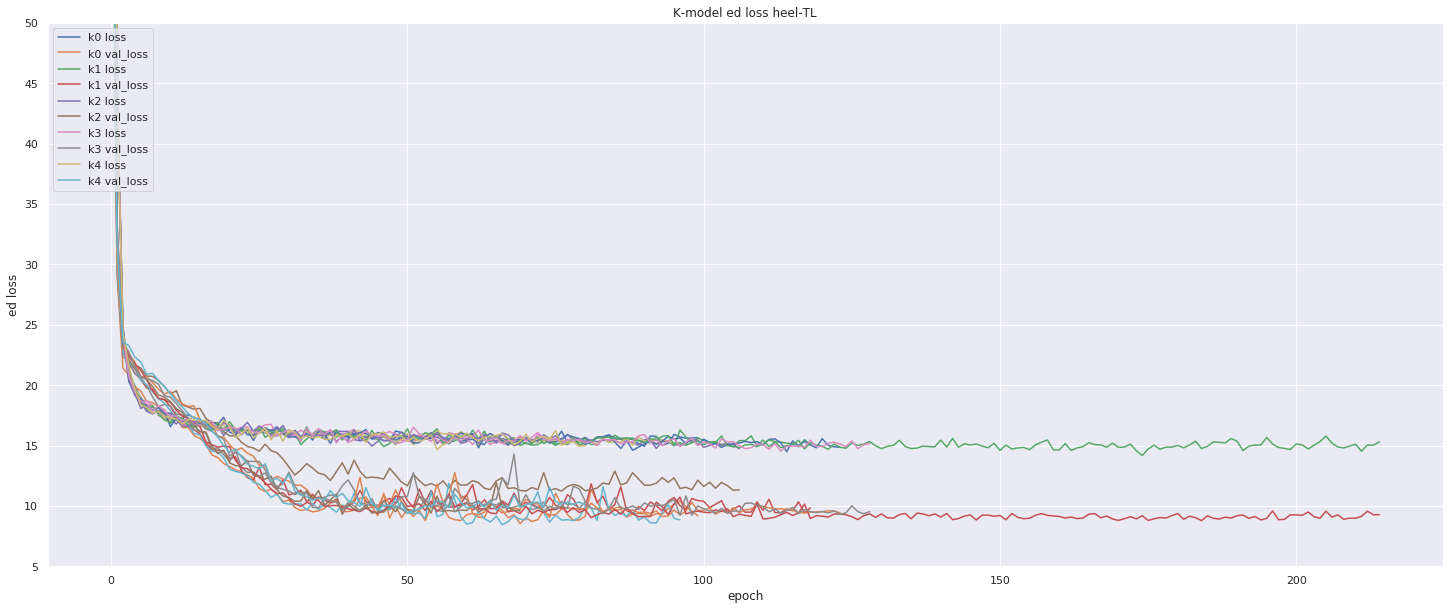

In [105]:
# Sum plot losses heel-tl

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])

    
plt.title('K-model ed loss heel-TL')
plt.ylabel('ed loss'), plt.ylim(5, 50)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_TL.png', bbox_inches = 'tight')

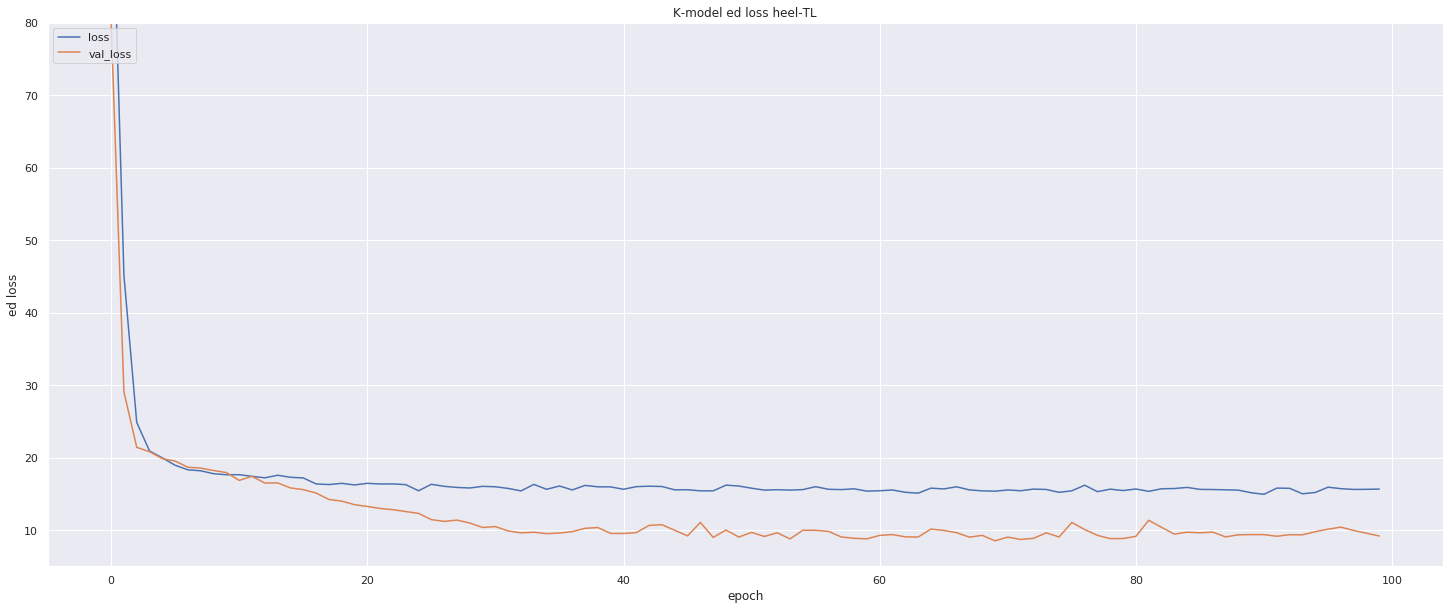

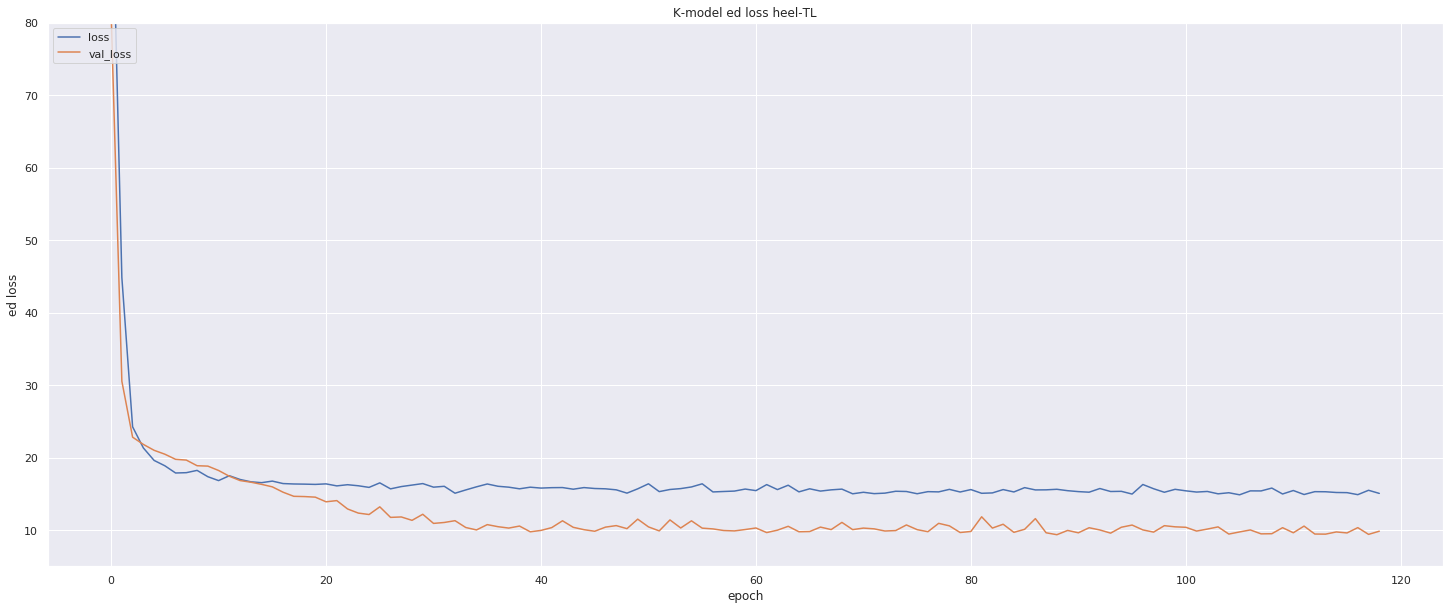

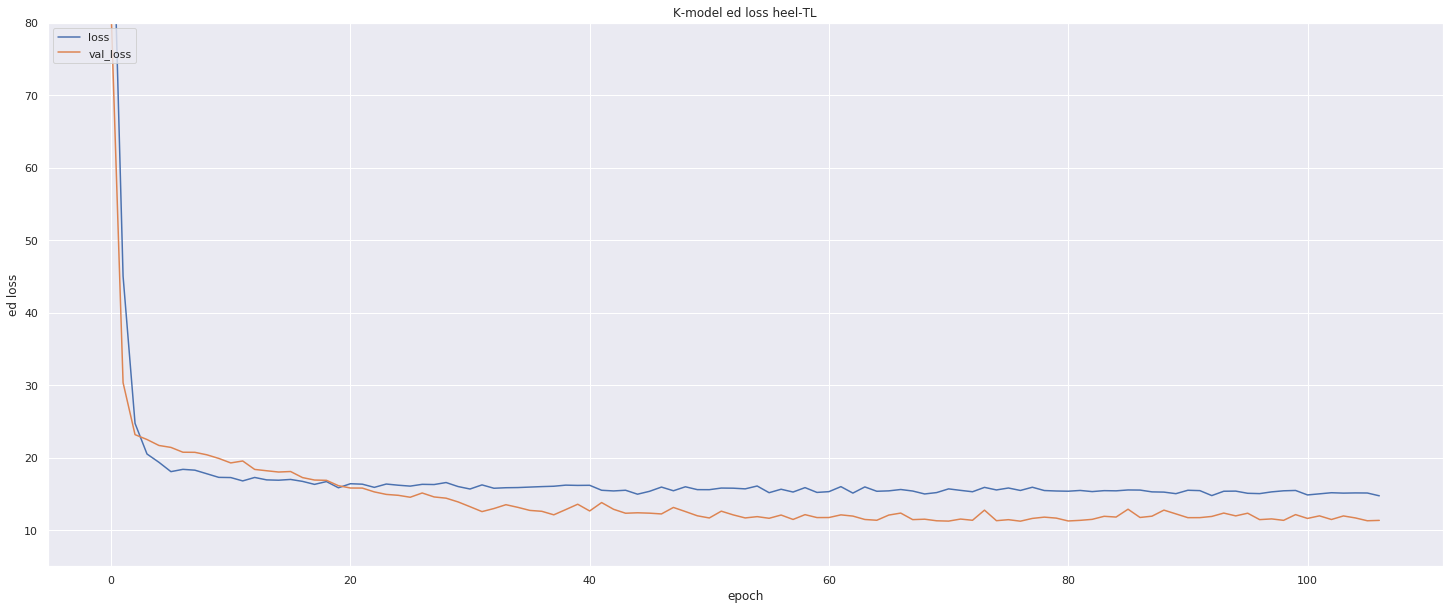

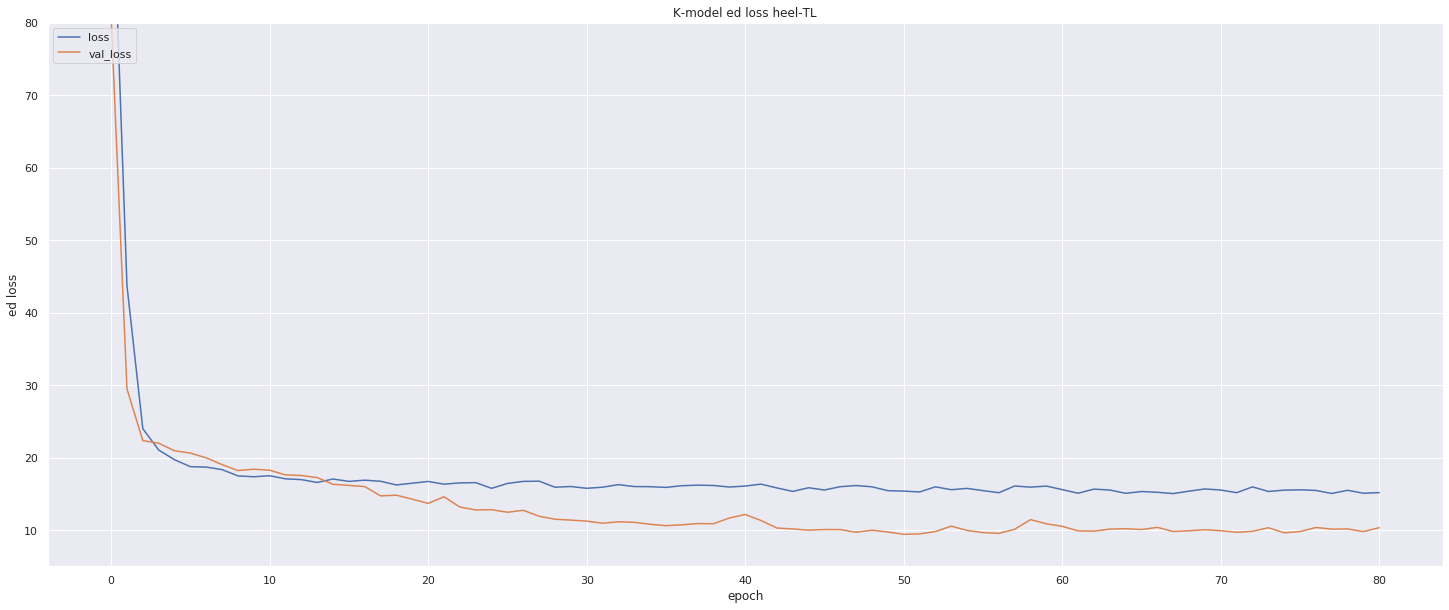

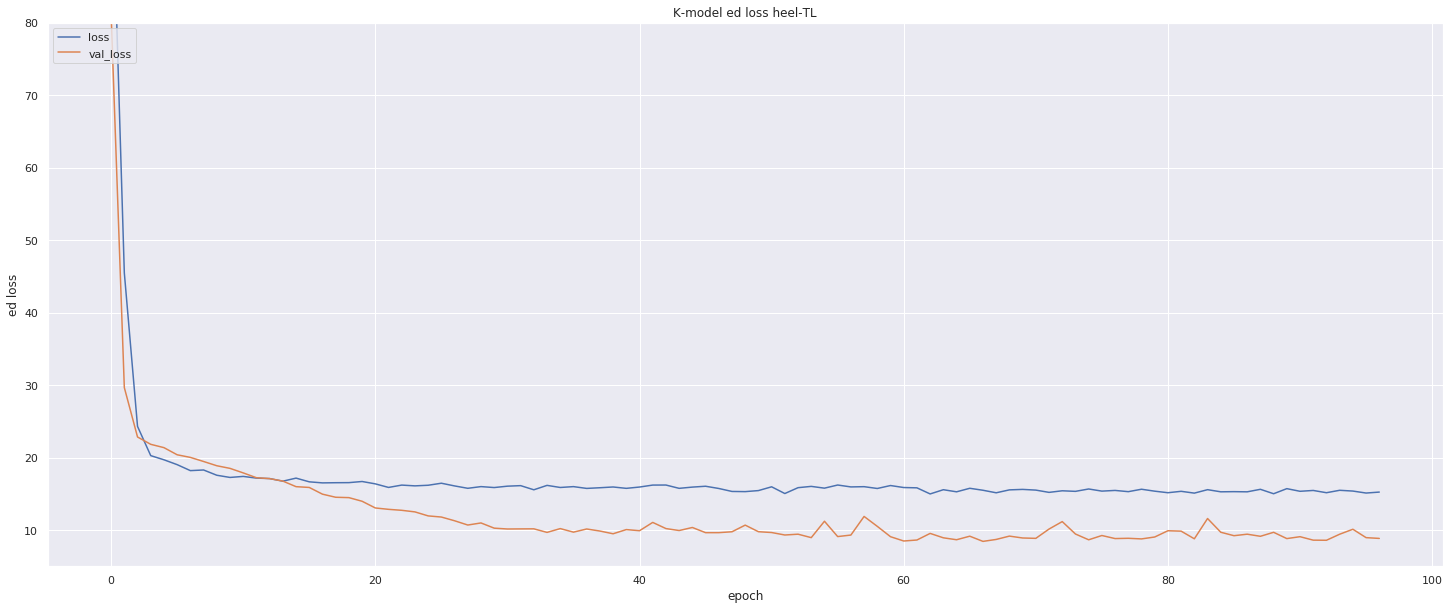

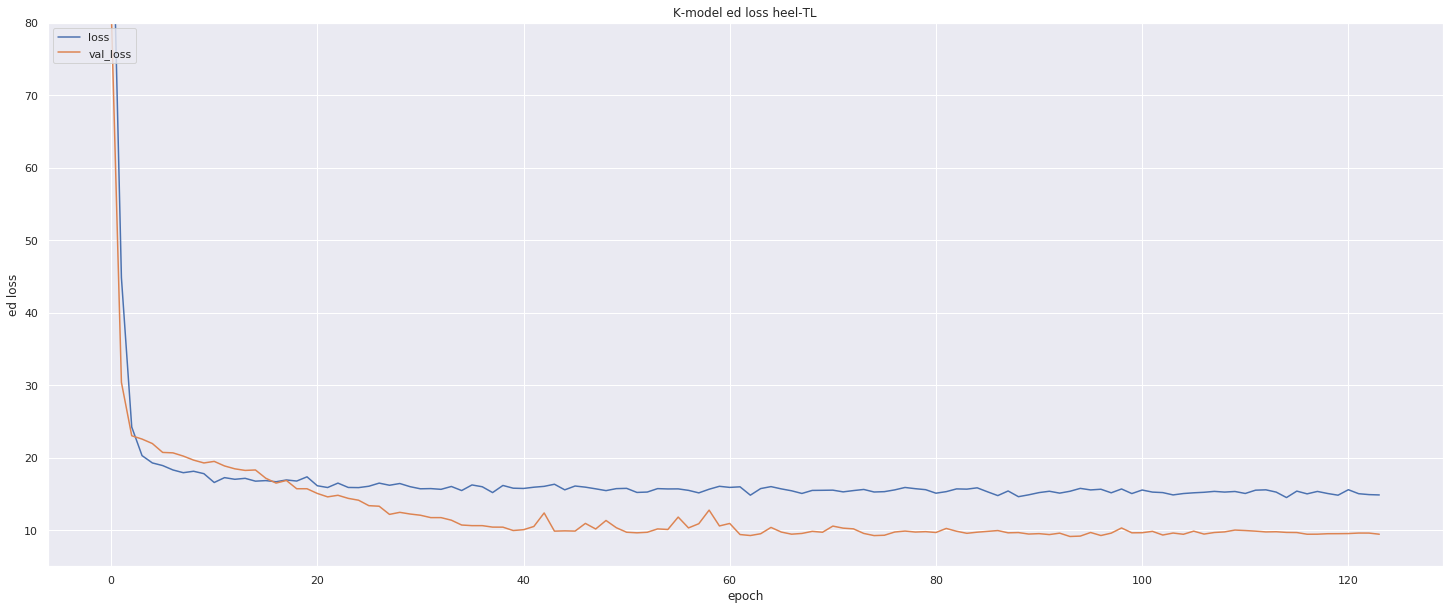

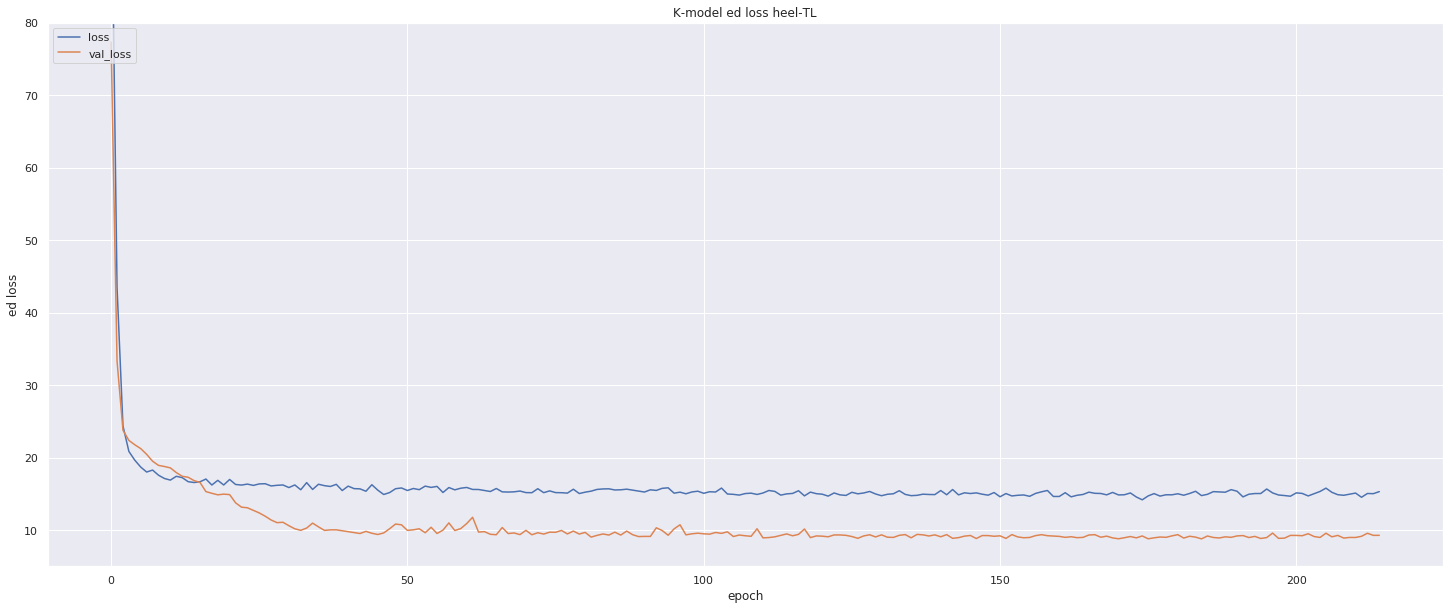

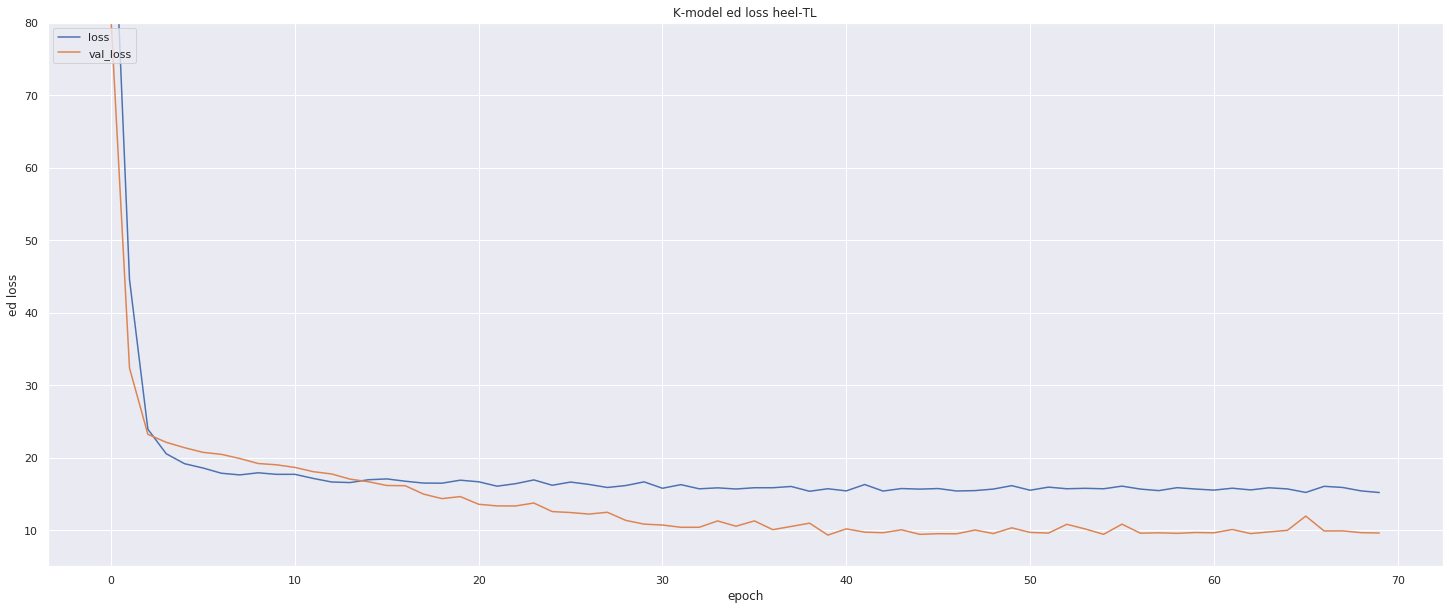

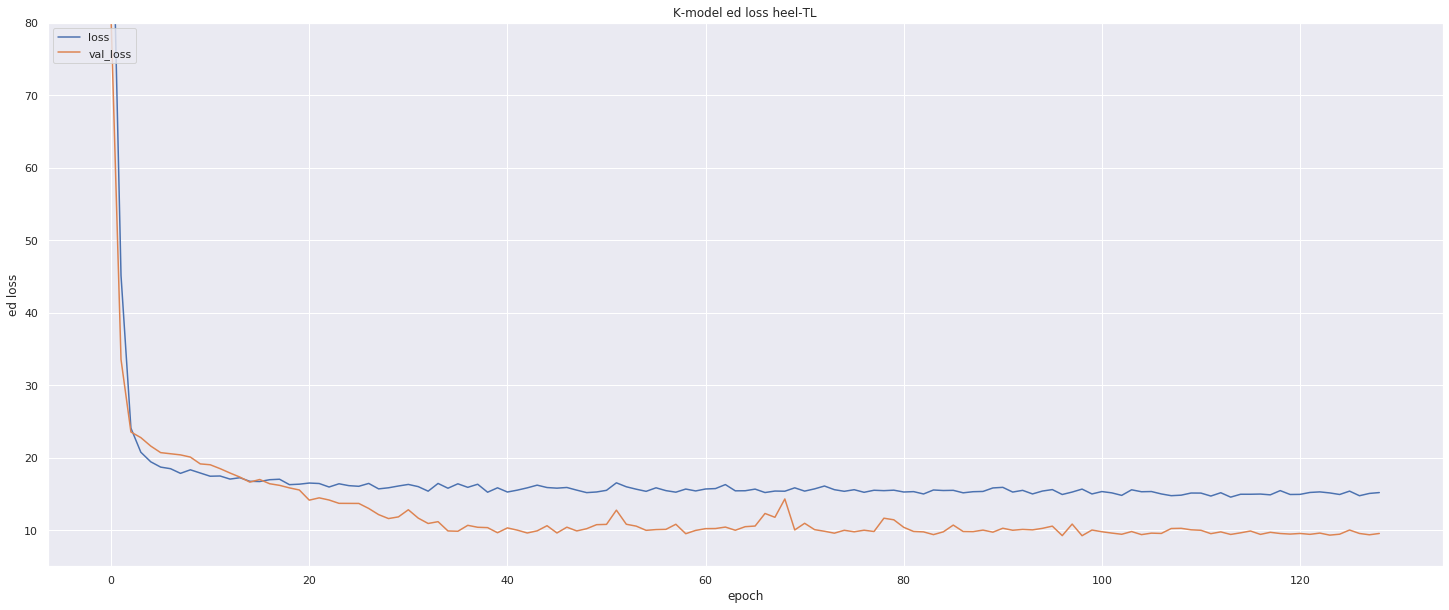

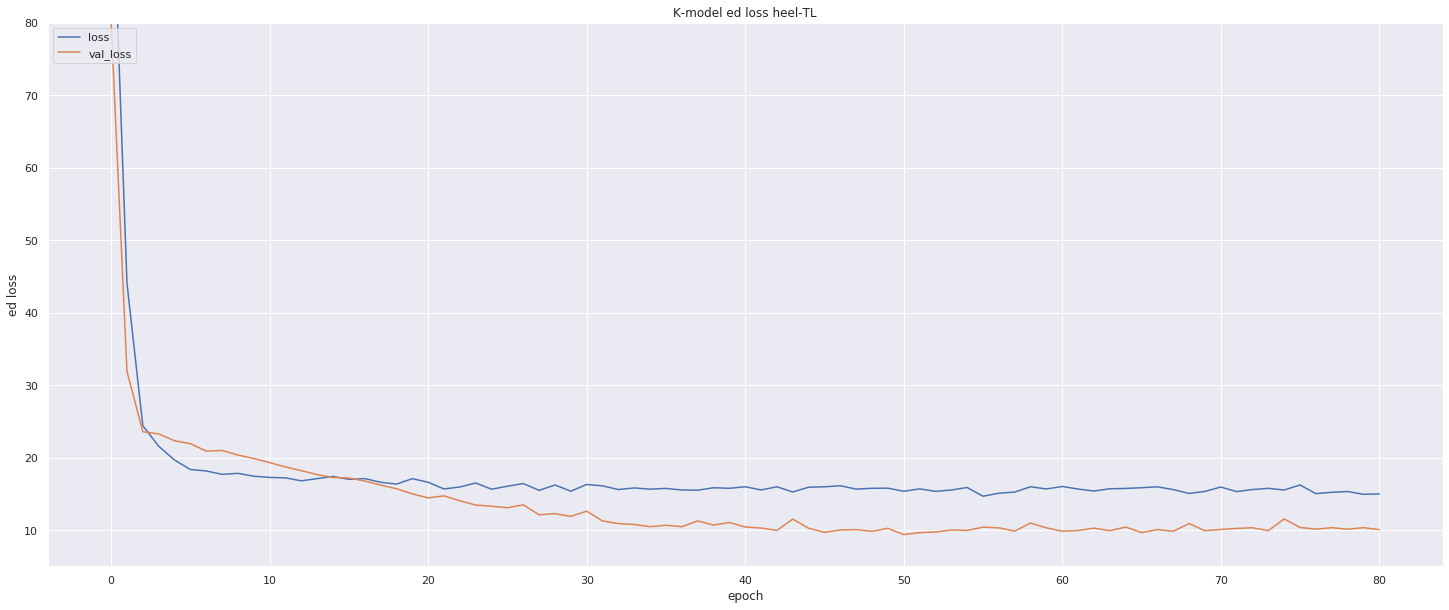

In [106]:
# Single plot loss heel-tl

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel[k].history['loss'])
    plt.plot(history_heel[k].history['val_loss'])
    plt.title('K-model ed loss heel-TL')
    plt.ylabel('ed loss'), plt.ylim(5, 80)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_TL_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9


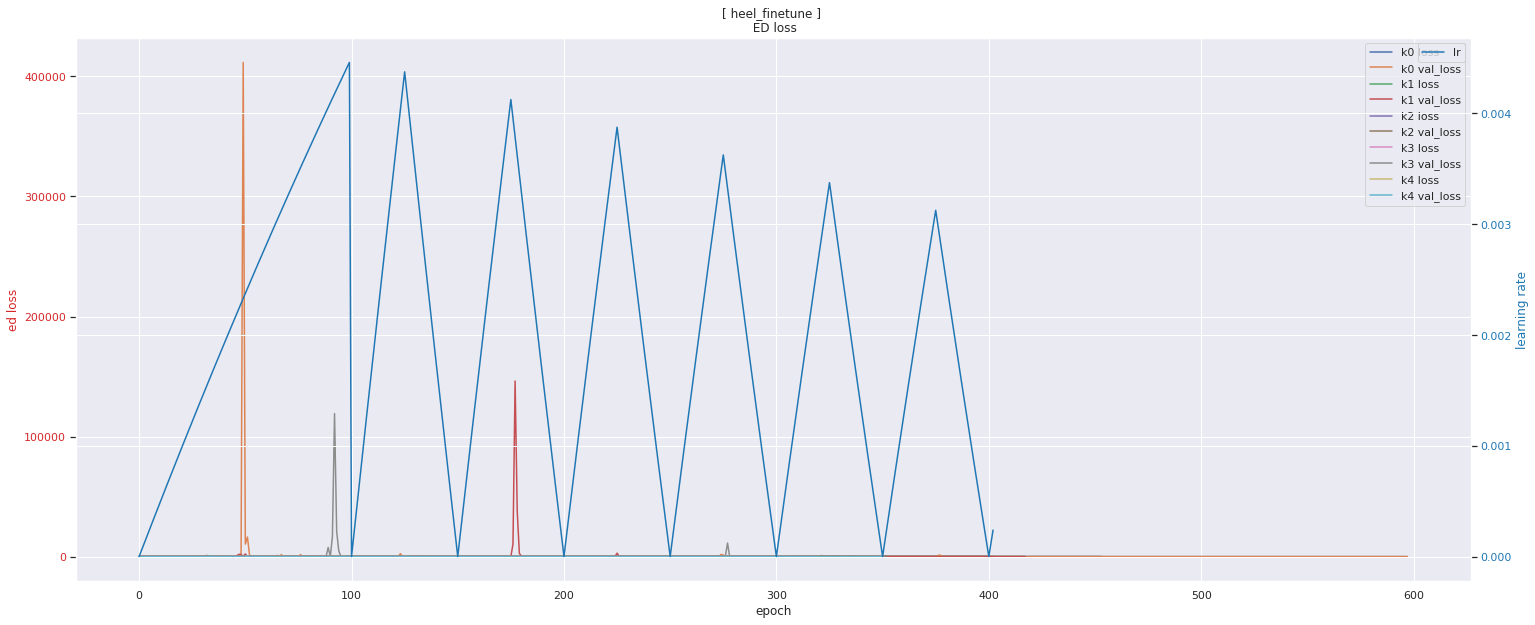

In [107]:
# check the loos the model trained.

def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

# t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
#     t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    h_vl.append(h_v)
    
# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ heel_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.
ax1.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper right') 

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune[0].history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# # save plot : comment plo.show in jupyter notebook.
# def get_valloss(his_v_l):   
#     return np.min(his_v_l), np.argmin(his_v_l)

# vl, ep = get_valloss(history_toe_finetune.history['val_loss'])


# t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_ft_Ksum-clr_ed{round(h_vl,4)}.png', bbox_inches = 'tight')

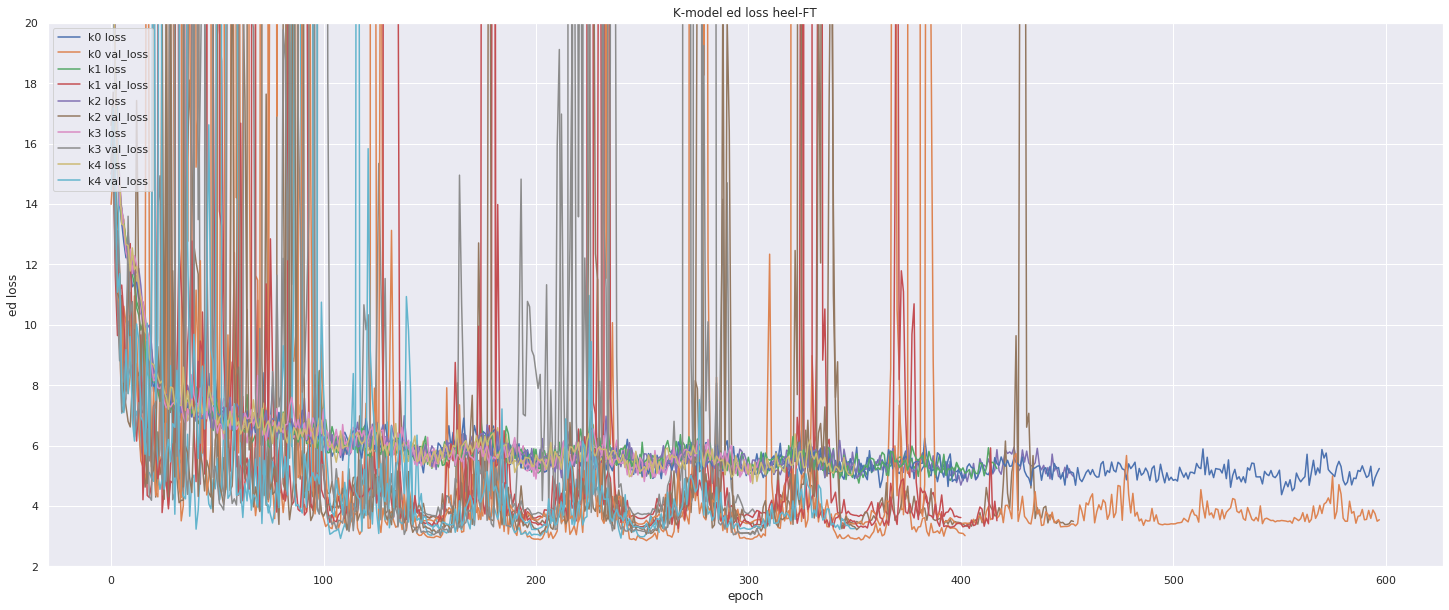

In [108]:
# Sum plot losses heel-ft

plt.figure(figsize=(25, 10))

for k in range(KFlodNum):

    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])

    
plt.title('K-model ed loss heel-FT')
plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['k0 loss', 'k0 val_loss', 'k1 loss', 'k1 val_loss', 'k2 loss', 'k2 val_loss', 
            'k3 loss', 'k3 val_loss', 'k4 loss', 'k4 val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_Ksum_FT.png', bbox_inches = 'tight')

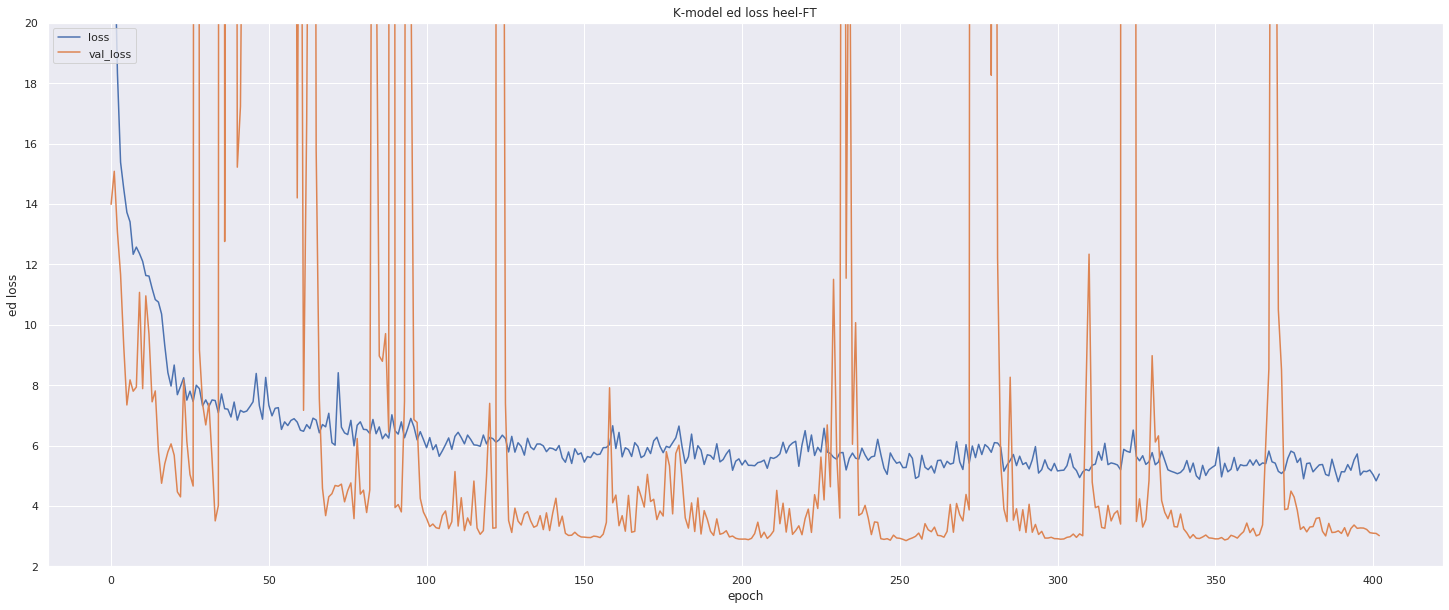

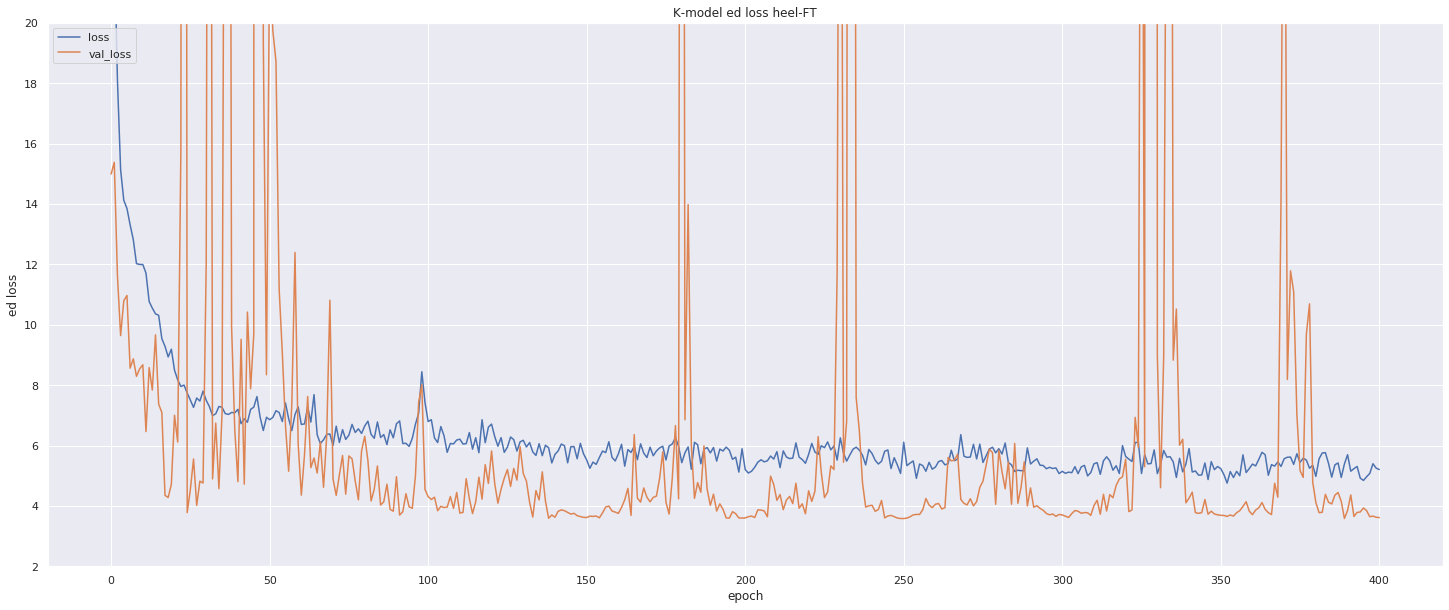

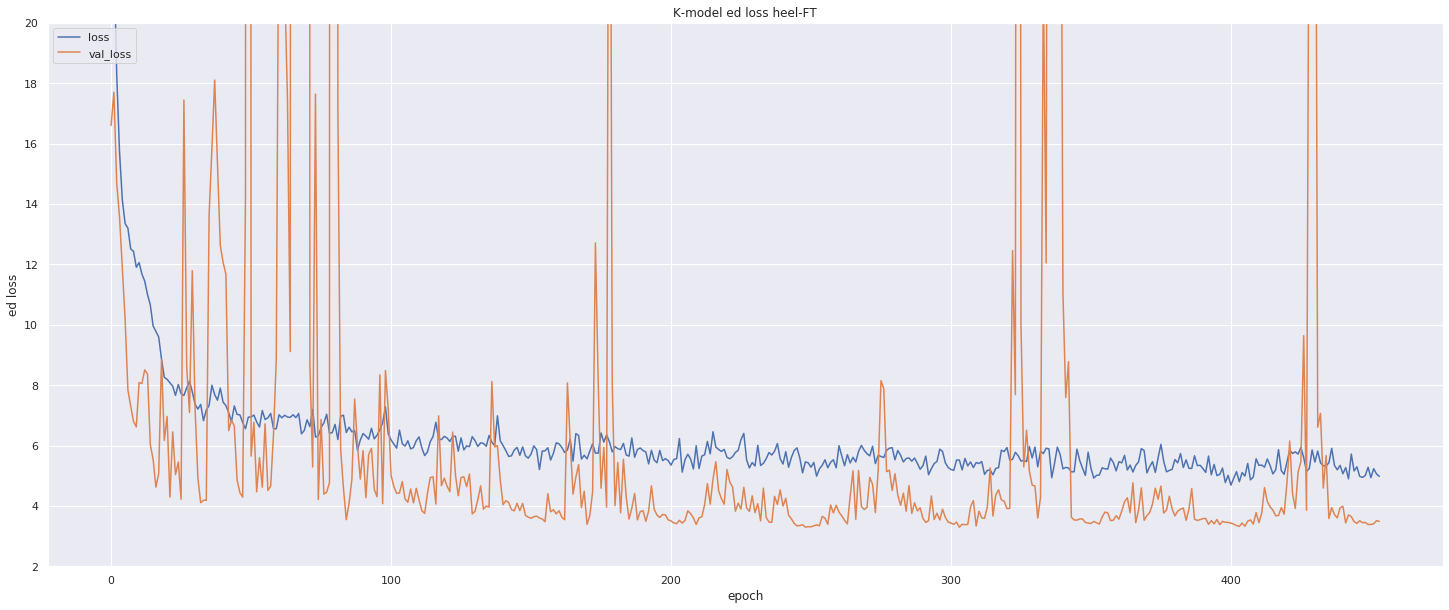

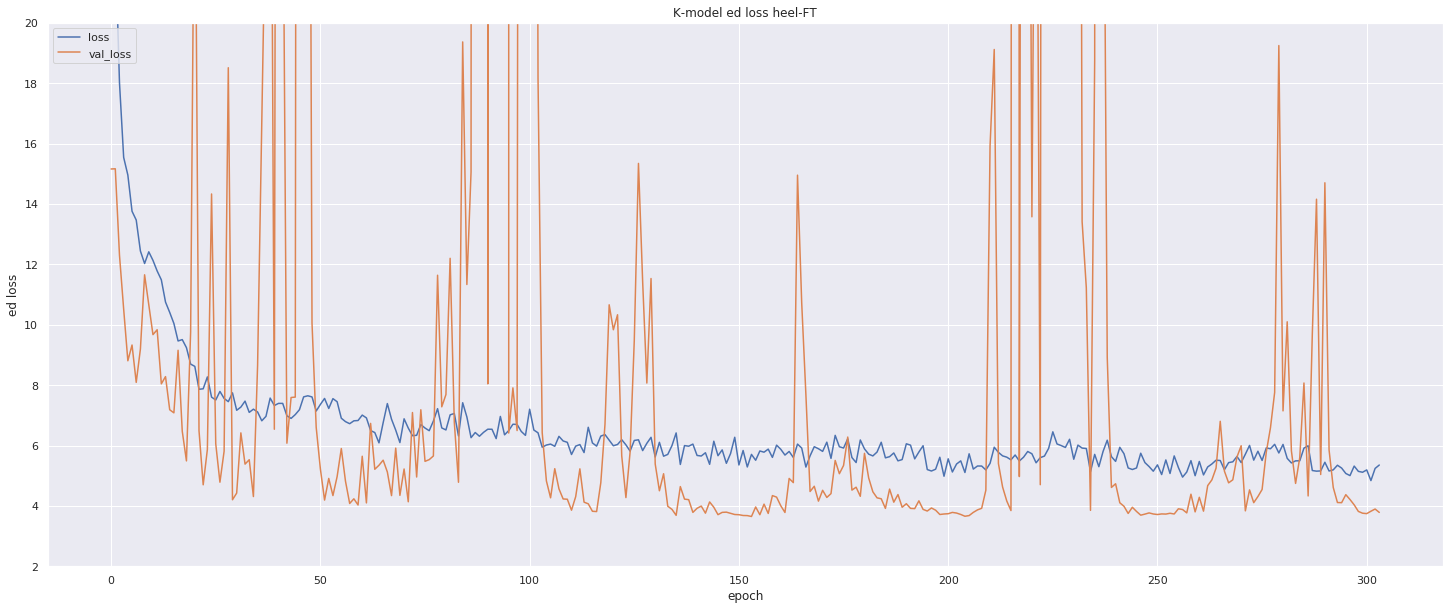

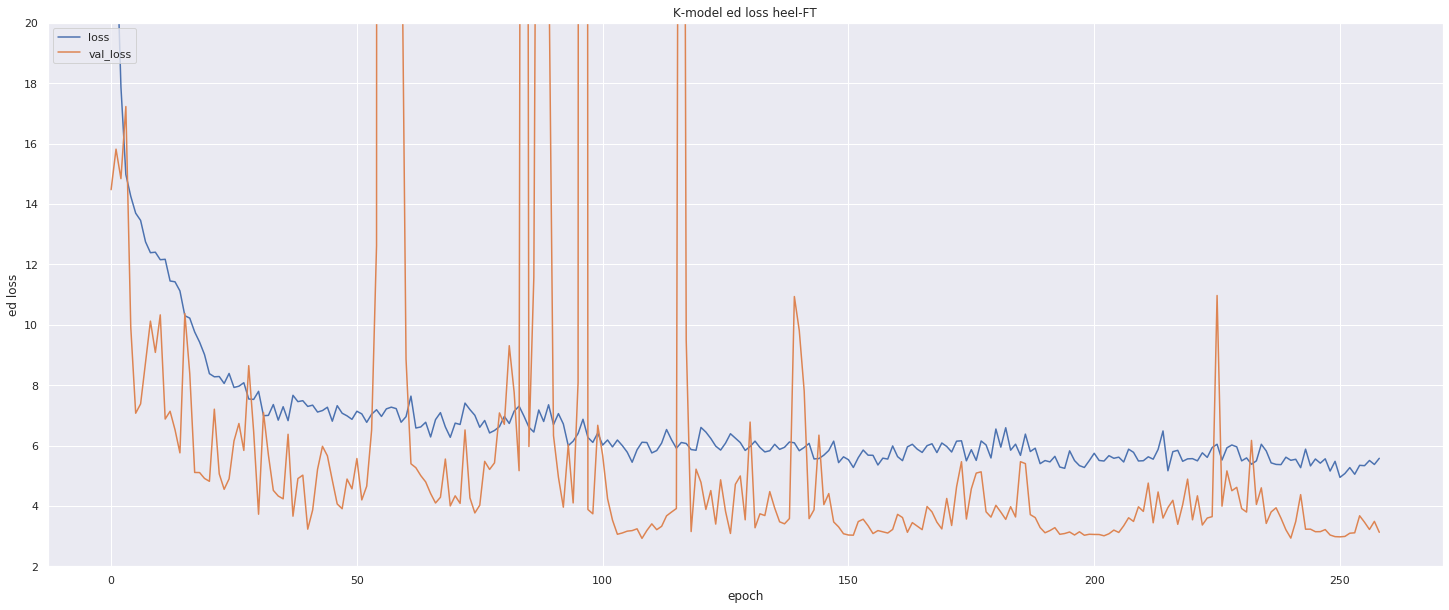

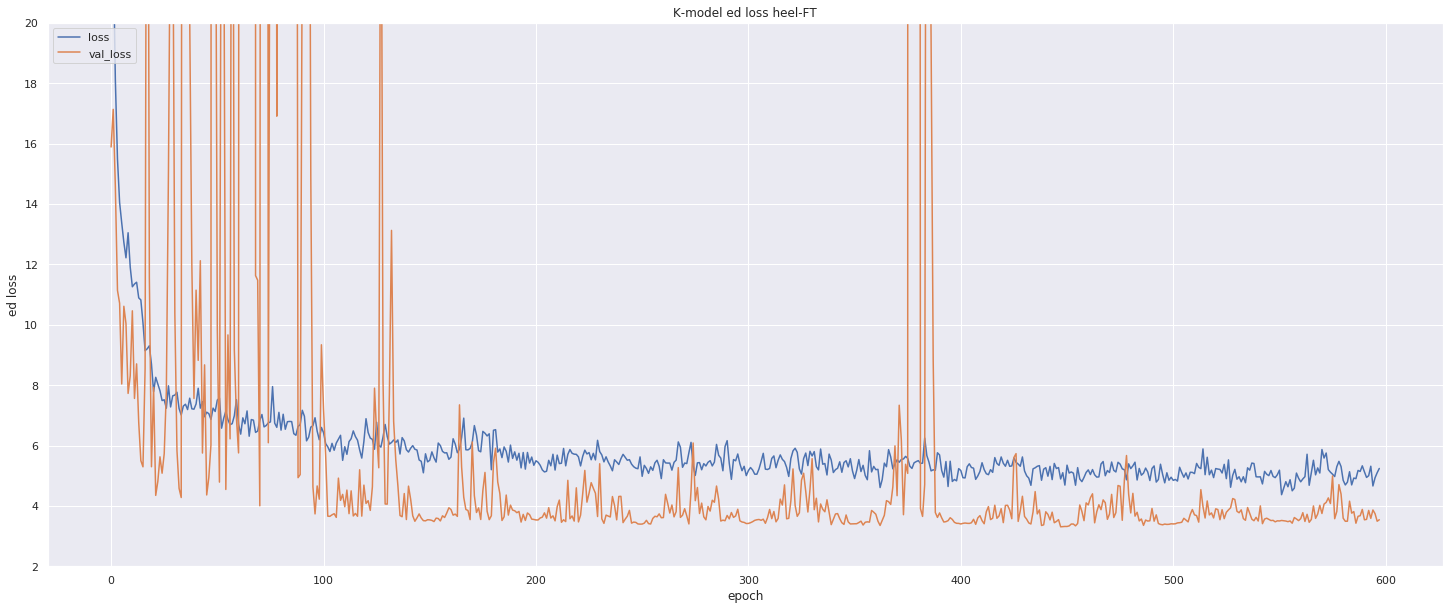

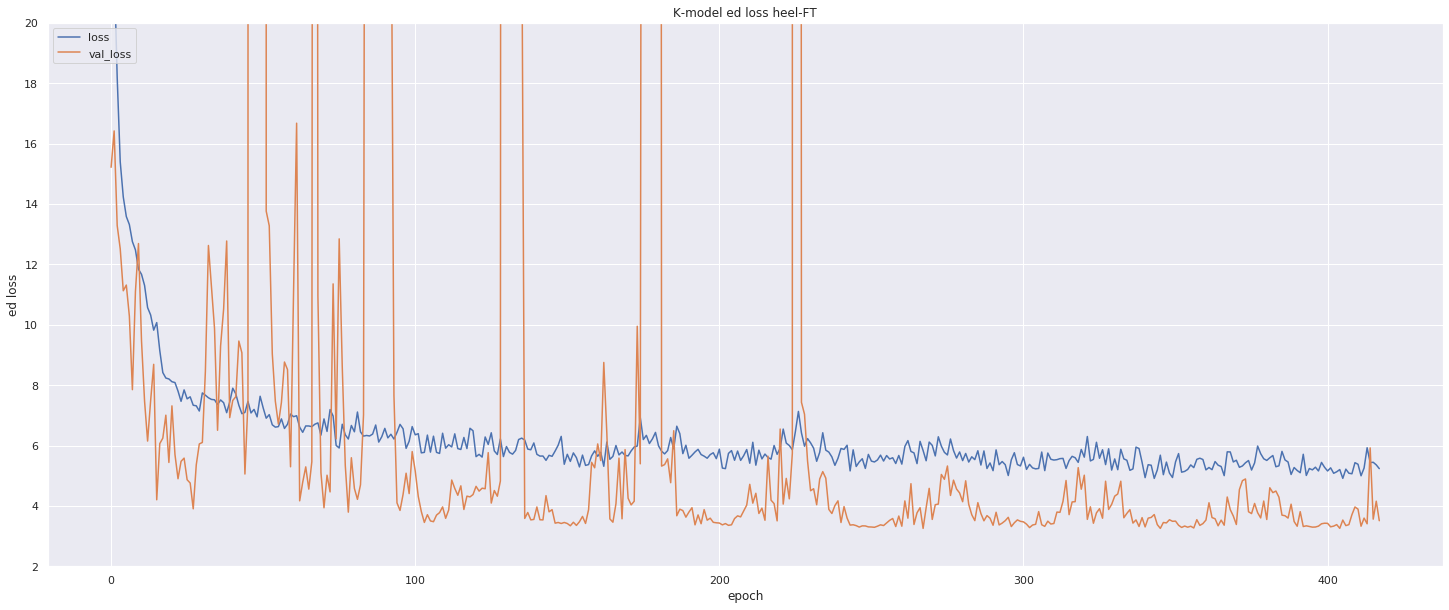

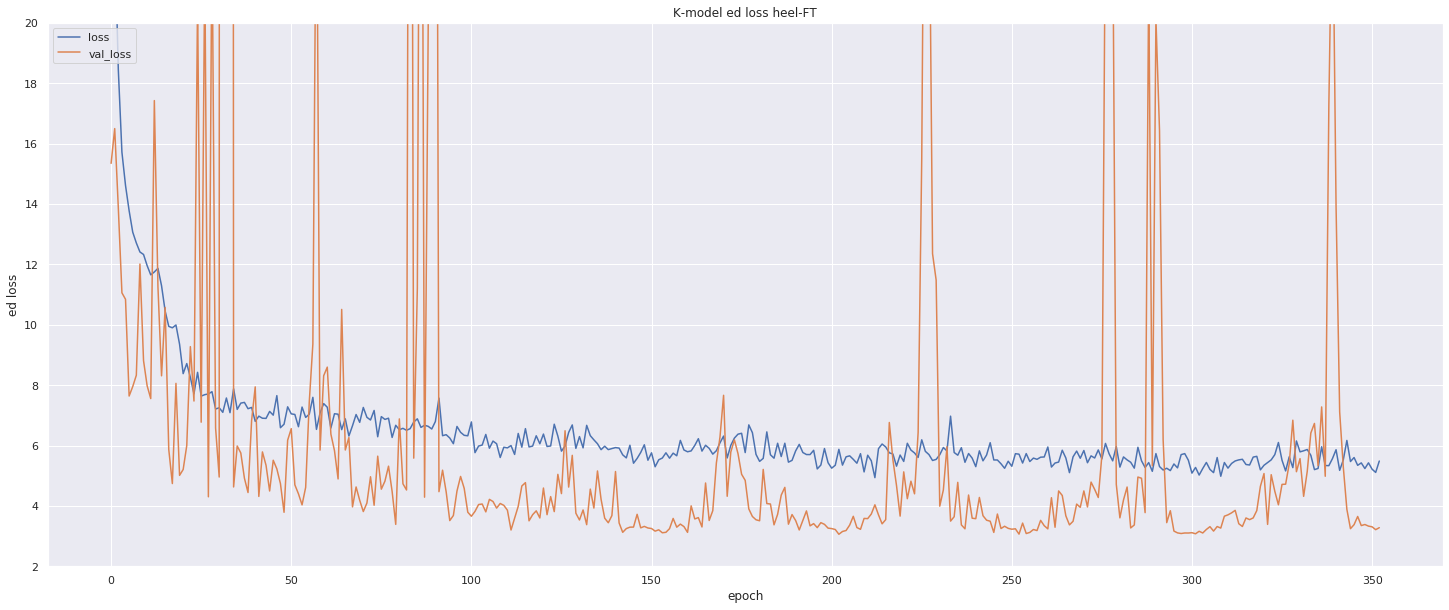

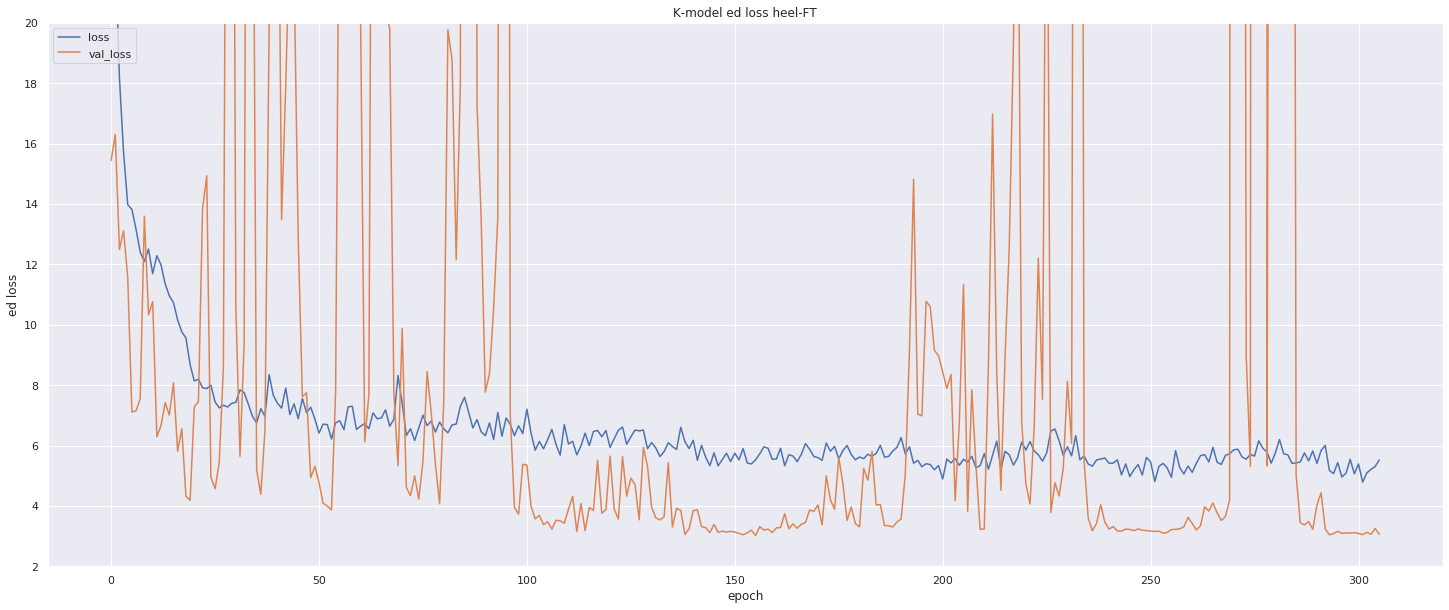

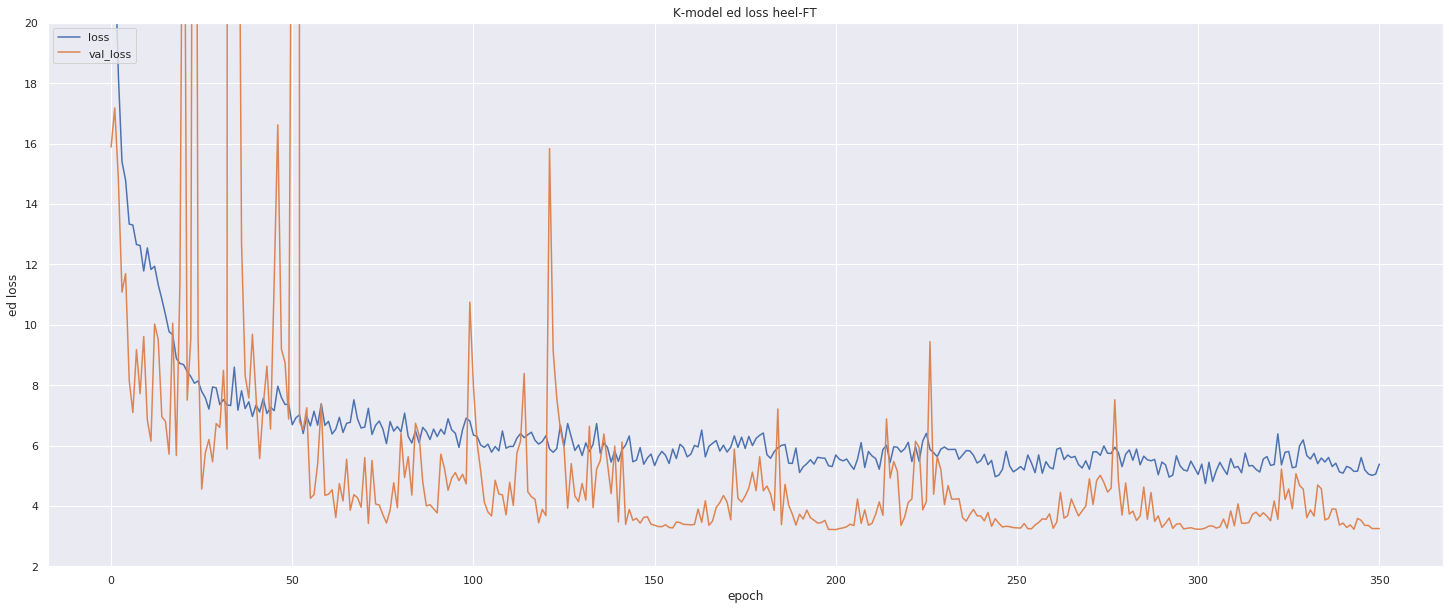

In [109]:
# Single plot loss heel-FT

for k in range(KFlodNum):
    plt.figure(figsize=(25, 10))
    plt.plot(history_heel_finetune[k].history['loss'])
    plt.plot(history_heel_finetune[k].history['val_loss'])
    plt.title('K-model ed loss heel-FT')
    plt.ylabel('ed loss'), plt.ylim(2, 20)# for too large loss
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left') 
    # plt.show()

    # save plot : comment plo.show in jupyter notebook.
    def get_valloss(his_v_l):   
        return np.min(his_v_l), np.argmin(his_v_l)

    vl, ep = get_valloss(history_heel_finetune[k].history['val_loss'])
    plt.savefig(f'{log_dir_name}/{log_dir_name}_heel_K{k}_FT_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

### Ploting your model

In [110]:
# model_toe.summary()

In [111]:
# # show after modl.fit
# model_toe.metrics_names

In [112]:
# # check metrics the model have.
# history_toe.history.keys()

In [113]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [114]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## show pp pred

* we can switch toe/hell by comment it

### EFN Toe

In [115]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [116]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_toe.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [117]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [118]:
# np.abs(neg)[:5]

In [119]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [120]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [121]:
# # it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [122]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# # image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# pred = model_heel.predict_on_batch(image_batch) #predictions
# # pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [123]:
# pred[:5]

In [124]:
# label_batch[:5]

In [125]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [126]:
# np.abs(neg)[:10]

In [127]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [128]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [129]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

images  x1  y1  x2  y2
0  image_0001.png NaN NaN NaN NaN
1  image_0002.png NaN NaN NaN NaN
2  image_0003.png NaN NaN NaN NaN
3  image_0004.png NaN NaN NaN NaN
4  image_0005.png NaN NaN NaN NaN

In [130]:
df_ts['images']

0      image_0001.png
1      image_0002.png
2      image_0003.png
3      image_0004.png
4      image_0005.png
            ...      
995    image_0996.png
996    image_0997.png
997    image_0998.png
998    image_0999.png
999    image_1000.png
Name: images, Length: 1000, dtype: object

In [131]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [132]:
len(list_ds_test)#.shape() #take(1)

1000

In [133]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [134]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

take test sample: b'image_0001.png'
take test sample: b'image_0002.png'
take test sample: b'image_0003.png'
take test sample: b'image_0004.png'
take test sample: b'image_0005.png'


### TEST DS: Process TEST path to image tensor

In [135]:
## TEST-DS: re-used from train/val-ds

im_test = 'test_images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [136]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [137]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

take sample: (120, 120, 3) b'image_0001.png'
take sample: (120, 120, 3) b'image_0002.png'
take sample: (120, 120, 3) b'image_0003.png'
take sample: (120, 120, 3) b'image_0004.png'
take sample: (120, 120, 3) b'image_0005.png'


### prepare TEST_ds_pre

In [138]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [139]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

Check cache in memory:Y True
Check cache in memory:Y True


# Load Best-K-models

In [140]:
# if K-models are in last time frame
# best_model_name = get_best_model_name(th, K=str(k))

predictions_toe = []
predictions_heel = []

for k in range(KFlodNum):
    print(f'K:{k}')
    best_model_toe_name = get_best_model_name('toe', K=str(k))
    best_model_heel_name = get_best_model_name('heel', K=str(k))

# # if models are in last time frame
# best_model_toe_name = get_best_model_name('toe')
# best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




    print(best_model_toe_name)
    print(best_model_heel_name)
    # log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

    best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
    best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)
    
    best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
    best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
        
        
    pred_toe = best_model_toe.predict(test_ds_pre_toe)
    pred_toe[:,1] = pred_toe[:,1] + y_offset_toe
    predictions_toe.append(pred_toe)
    
    pred_heel = best_model_heel.predict(test_ds_pre_heel)
    pred_heel[:,1] = pred_heel[:,1] + y_offset_heel
    predictions_heel.append(pred_heel)
    
    

K:0
./20210302-230617/toe_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K0_EfficientNetB0_bs64_w120_best_val_loss.h5
K:1
./20210302-230617/toe_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K1_EfficientNetB0_bs64_w120_best_val_loss.h5
K:2
./20210302-230617/toe_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K2_EfficientNetB0_bs64_w120_best_val_loss.h5
K:3
./20210302-230617/toe_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K3_EfficientNetB0_bs64_w120_best_val_loss.h5
K:4
./20210302-230617/toe_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K4_EfficientNetB0_bs64_w120_best_val_loss.h5
K:5
./20210302-230617/toe_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K5_EfficientNetB0_bs64_w120_best_val_loss.h5
K:6
./20210302-230617/toe_K6_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K6_EfficientNetB0_bs64_w120_best_val_loss.h5


K:7
./20210302-230617/toe_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K7_EfficientNetB0_bs64_w120_best_val_loss.h5
K:8
./20210302-230617/toe_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K8_EfficientNetB0_bs64_w120_best_val_loss.h5
K:9
./20210302-230617/toe_K9_EfficientNetB0_bs64_w120_best_val_loss.h5
./20210302-230617/heel_K9_EfficientNetB0_bs64_w120_best_val_loss.h5


In [141]:
len(predictions_toe[0])

1000

In [142]:
# make sure we got the k-pred as k models.
for i, _ in enumerate(predictions_toe):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [143]:
np.shape(predictions_toe)

(10, 1000, 2)

In [144]:
predictions_toe[0]

array([[ 59.532707, 135.17773 ],
       [ 54.216137, 141.57913 ],
       [ 56.163006, 146.2502  ],
       ...,
       [ 64.80265 , 134.12784 ],
       [ 63.843533, 122.88196 ],
       [ 60.868168, 120.99621 ]], dtype=float32)

In [145]:
predictions_toe[1]

array([[ 58.085484, 135.73584 ],
       [ 53.53565 , 145.63948 ],
       [ 53.671135, 147.75183 ],
       ...,
       [ 66.026505, 134.1742  ],
       [ 63.033825, 120.630844],
       [ 59.60519 , 122.64062 ]], dtype=float32)

In [146]:
predictions_heel[0]

array([[ 80.99584 , 379.15924 ],
       [ 22.693176, 376.0365  ],
       [ 79.53873 , 383.2863  ],
       ...,
       [ 29.434544, 381.74377 ],
       [ 76.05158 , 381.34113 ],
       [ 33.61462 , 381.46057 ]], dtype=float32)

In [147]:
predictions_heel[1]

array([[ 80.34776 , 379.48038 ],
       [ 25.555588, 375.457   ],
       [ 78.10987 , 383.02963 ],
       ...,
       [ 28.992558, 381.55237 ],
       [ 75.33211 , 381.66113 ],
       [ 34.121994, 381.35916 ]], dtype=float32)

In [148]:
# mean the k-predictions
k_predictions_toe = np.mean(predictions_toe, axis=0)
k_predictions_toe

array([[ 59.57362 , 136.15887 ],
       [ 54.86253 , 142.53065 ],
       [ 55.74582 , 147.08372 ],
       ...,
       [ 66.513084, 134.55511 ],
       [ 63.392426, 121.407715],
       [ 60.05442 , 121.130066]], dtype=float32)

In [149]:
np.shape(k_predictions_toe)

(1000, 2)

In [150]:
# mean the k-predictions
k_predictions_heel = np.mean(predictions_heel, axis=0)
k_predictions_heel

array([[ 80.622604, 379.47012 ],
       [ 24.64888 , 375.75763 ],
       [ 78.73796 , 383.22705 ],
       ...,
       [ 29.540655, 381.6916  ],
       [ 75.67736 , 381.72455 ],
       [ 34.06521 , 381.5866  ]], dtype=float32)

### Merge toe/hell pred

In [151]:
predictions_th = np.append(k_predictions_toe, k_predictions_heel, axis=1)#左右接
predictions_th.shape

(1000, 4)

In [152]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

(1000, 1)

In [153]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

(1000, 5)

In [154]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [155]:
submi_name = CSVNAME + '.' + log_dir_name +'.csv'

df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))

Save K1345K10L195.20210302-230617.csv as submission CSV.


In [156]:
df_submission.head()

images       x1       y1       x2       y2
0  image_0001.png  59.5736  136.159  80.6226   379.47
1  image_0002.png  54.8625  142.531  24.6489  375.758
2  image_0003.png  55.7458  147.084   78.738  383.227
3  image_0004.png  57.5992  138.874  29.6191  373.609
4  image_0005.png  60.5477  150.109  67.1064  370.255

In [157]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl = []
h_vl = []
for k in range(KFlodNum):
    print(f'K:{k}')
    t_v, _ = get_valloss(history_toe_finetune[k].history['val_loss'])
    h_v, _ = get_valloss(history_heel_finetune[k].history['val_loss'])
    
    t_vl.append(t_v)
    h_vl.append(h_v)

t_vl = np.mean(t_vl, axis=0)
h_vl = np.mean(h_vl, axis=0)
print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

K:0
K:1
K:2
K:3
K:4
K:5
K:6
K:7
K:8
K:9
5.29985 + 3.21534 = 8.51519


In [158]:
# K134520210224-114845.csv
# 5.63922 + 3.34466 = 8.98389 LB:8.4890610

In [159]:
t_vl

5.299849128723144

In [160]:
h_vl

3.2153428554534913

In [161]:
t_timer.toc() #Time elapsed since t.tic()

Elapsed time is 43778.387794 seconds.


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [162]:
# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [163]:
# %%time
# # inference all test_ds once
# predictions_toe = best_model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

### Offset Toe

In [164]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# # for [0,1]
# # predictions_toe[:,0] = predictions_toe[:,0]*120
# # predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # # for [-1,1]
# # # for re-scale back xy 
# # # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# # predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# # predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

# predictions_toe

In [165]:
# %%time
# # inference all test_ds once
# predictions_heel = best_model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

### Offset Heel

In [166]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# # for [0,1]
# # predictions_heel[:,0] = predictions_heel[:,0]*120
# # predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # # for [-1,1]
# # predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# # predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

# predictions_heel

### Merge toe/hell pred

In [167]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [168]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [169]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [170]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [171]:
# submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))

In [172]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [173]:
# df_submission.head()

In [174]:
# #ED sum
# def get_valloss(his_v_l):  
#     return np.min(his_v_l), np.argmin(his_v_l)

# t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
# h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

# print(f'{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

In [175]:
#

## save model

In [176]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/

